In [2]:
from google.colab import drive
drive.mount("/content/drive/", force_remount=True)

Mounted at /content/drive/


In [3]:
from google.colab import files
def getLocalFiles():
    _files = files.upload()
    if len(_files) >0:
       for k,v in _files.items():
         open(k,'wb').write(v)
getLocalFiles()

Saving outils_data.py to outils_data (1).py
Saving outils_model.py to outils_model (1).py
Saving outils_preprocessing.py to outils_preprocessing (1).py


In [4]:
!pip install shap
!pip install catboost
!pip install eli5
!pip install boruta
!pip install BorutaShap
!pip install MarkupSafe==2.0.1
!pip install pycodestyle_magic
!pip install pycodestyle
!pip install flake8

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# <span style='color:SteelBlue'>P7 - Implémentez un modèle de scoring</span>

![image.png](attachment:image.png)

 # <span class='bg-primary'>P7_01_06 - DASHBOARD</span>

Ce notebook traite de la préparation des différents champs et des graphiques du jeu de test pour affichage dans le dashboard.

En particulier :
- **jeu de test** : récupération des champs à afficher dans le dashboard sous une forme compréhensible (ex : âge en années plutôt qu'en nombre de jour, sexe en Féminin/Masculin plutôt que 0/1).
- **interprétabilité/transparence** :
    - récupération des 10 variables les plus importantes pour créer des graphiques pour chacune des ces variables en comparant les résultats des défaillants/non défaillant, de la moyenne global sur tous les clients pour situer la position du client à qui on accordera ou non le prêt.
    - récupération des 10 voisins les plus proches sur ces 10 variables pour le situer parmi ces 10 voisins ceux qui ont été défaillants ou non.
    - situer le patient parmi les défaillants ou non défaillants sur les variables âge, sexe, catégorie socio-professionnelle, revenus, montant du crédit, durée du crédit...

## <span style='background:Thistle'>Sommaire du notebook</span> 

In [ ]:
# from jyquickhelper import add_notebook_menu
# add_notebook_menu()

## <span style='background:Thistle'>1. Introduction</span>

*****
**Mission**
*****
**Développer un modèle de scoring de la probabilité de défaut de paiement du client** pour étayer la décision d'accorder ou non un prêt à un client potentiel en s’appuyant sur des sources de données variées (données comportementales, données provenant d'autres institutions financières...).

*****
**Objectifs**
*****
- analyser le jeu de données,
- Construire **un modèle de scoring** qui donnera une prédiction sur la probabilité de faillite d'un client de façon automatique,
- réaliser un **dashboard interactif** permettant aux chargés de clientèles d'expliquer de manière transparente la décision d'octroi ou non de crédit

*****
**Sources**
*****
- [Jeu de données](https://www.kaggle.com/c/home-credit-default-risk/data)

In [5]:
# Chargement des librairies
import datetime
import sys
import time
from datetime import datetime
import warnings
# import jyquickhelper
import numpy as np
import pandas as pd
import pickle
from joblib import dump, load
from collections import Counter

# Librairies personnelles
import outils_data
import outils_model
import outils_preprocessing

# Visualisation
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
import plotly.graph_objects as go

# Modèle
import sklearn
from sklearn.neighbors import KNeighborsClassifier

# Standardisation
from sklearn.preprocessing import StandardScaler

# Interprétation
import shap

# Warnings
import warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline
# Chargement à chaud des librairies personnelles
%load_ext autoreload
%autoreload 2
# Valide code pep8
%load_ext pycodestyle_magic
# %pycodestyle_on
# %pycodestyle_off

# Versions
print('Version des librairies utilisées :')
print('Python                : ' + sys.version)
print('NumPy                 : ' + np.version.full_version)
print('Pandas                : ' + pd.__version__)
print('Matplotlib            : ' + matplotlib.__version__)
print('Seaborn               : ' + sns.__version__)
print('Scikit-learn          : ' + sklearn.__version__)
print('Outils dataframe      : ' + outils_data.__version__)
print('Outils modélisation   : ' + outils_model.__version__)
print('Outils préprocessing  : ' + outils_preprocessing.__version__)
now = datetime.now().isoformat()
print('Lancé le           : ' + now)

Version des librairies utilisées :
Python                : 3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]
NumPy                 : 1.21.6
Pandas                : 1.3.5
Matplotlib            : 3.2.2
Seaborn               : 0.11.2
Scikit-learn          : 1.0.2
Outils dataframe      : 0.0.4
Outils modélisation   : 0.0.1
Outils préprocessing  : 0.0.0
Lancé le           : 2022-06-21T04:59:23.192813


pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.


In [6]:
dico_pd_option = {
    'display.max_rows': 500,
    'display.max_column': 200,
    'display.width': 300,
    'display.precision': 4,
    'display.max_colwidth': 1000,
    'mode.chained_assignment': None
}
for cle, val in dico_pd_option.items():
    pd.set_option(cle, val)

## <span style='background:Thistle'>2. Initialisation (test/meilleur modèle)</span>

<span style='background:Moccasin'>**Chargement du jeu de données du train set sans pré-processing**</span>

In [6]:
application_train = pd.read_csv('/content/drive/My Drive/data/application_train.csv')
application_train.shape

(307511, 122)

In [7]:
# Correction valeurs aberrantes
application_train['DAYS_EMPLOYED'][application_train['DAYS_EMPLOYED']
                                   == 365243] = 0

In [8]:
# Correction : difficile d'imputer le sexe par le mode de cette catégorie
# Comme il n'y a que 4 clients avec un sexe non renseigné, on supprime ces
# valeurs
application_train = \
    application_train[application_train['CODE_GENDER'] != 'XNA']
application_train.shape

(307507, 122)

<span style='background:Moccasin'>**Chargement du jeu de données du test set sans pré-processing**</span>

In [9]:
application_test = pd.read_csv('/content/drive/My Drive/data/application_test.csv')
application_test.shape

(48744, 121)

In [10]:
# Correction valeurs aberrantes
application_test['DAYS_EMPLOYED'][application_test['DAYS_EMPLOYED']
                                  == 365243] = 0

<span style='background:Moccasin'>**Chargement du jeu de données du train set issu du pré-processing et de la feature sélection**</span>

- **train_set** : jeu de données étiquetté (variable cible = TARGET) du train set, issu de la phase de pré-processing (nettoyage, gestion des valeurs manquantes, gestion des valeurs aberrantes, encodage, merge de tous les fichiers, feature engineering et feature sélection).

In [11]:
fic_sav_train_set_sans = \
    '/content/drive/My Drive/sauvegarde/features-selection/train_set_sans_var_magique.pickle'
# Chargement de train_set
with open(fic_sav_train_set_sans, 'rb') as df_appli_train_set_sans:
    train_set = pickle.load(df_appli_train_set_sans)
train_set.shape

(307507, 100)

<span style='background:Moccasin'>**Chargement du jeu de données du test set issu du pré-processing et de la feature sélection**</span>

- **test_set** : jeu de données non étiquetté (sans la variable cible TARGET) du test set, issu de la phase de pré-processing (nettoyage, gestion des valeurs manquantes, gestion des valeurs aberrantes, encodage, merge de tous les fichiers, feature engineering et feature sélection).

In [12]:
fic_sav_test_set_sans = \
    '/content/drive/My Drive/sauvegarde/features-selection/test_set_sans_var_magique.pickle'
# Chargement de test_set
with open(fic_sav_test_set_sans, 'rb') as df_appli_test_set_sans:
    test_set = pickle.load(df_appli_test_set_sans)
test_set.shape

(48744, 99)

In [13]:
filename = '/content/drive/My Drive/sauvegarde/pickle/test_set.pickle'
outfile = open(filename,'wb')
pickle.dump(test_set, outfile)
outfile.close()

<span style='background:Moccasin'>**Chargement du meilleur modèle LightGBM**</span>

In [14]:
# Chargement du meilleur modèle
fic_best_model = '/content/drive/My Drive/sauvegarde/modelisation/best_model.pickle'
with open(fic_best_model, 'rb') as df_best_model:
    best_model = pickle.load(df_best_model)
best_model

LGBMClassifier(class_weight='balanced', colsample_bytree=0.6165561461232584,
               force_col_wise=True, max_depth=3, min_child_samples=80,
               min_child_weight=0.816706751735683, num_leaves=225,
               objective='binary', reg_alpha=0.04036415503705408,
               reg_lambda=6.380429879874343e-06, silent='warn',
               subsample=0.18463058154981357, subsample_freq=4, verbosity=-1)

In [15]:
filename =  '/content/drive/My Drive/sauvegarde/pickle/best_model.pickle'
outfile = open(filename,'wb')
pickle.dump(best_model, outfile)
outfile.close()

In [16]:
dump(best_model, '/content/drive/My Drive/sauvegarde/joblib/best_model.joblib', compress=1)

['/content/drive/My Drive/sauvegarde/joblib/best_model.joblib']

## <span style='background:Thistle'>3. Scoring (prédictions/Probabilités)</span>

Le meilleur modèle entraîné sur le jeu d'entraînement est maintenant opérationnel pour effectuer des prédictions et calculer les probabiltés du score de chacun des clients du jeu de test fourni pour Home Crédit.

In [18]:
# Copie du jeu de test
test = test_set.copy(deep=True)
# Sauvegarde des identifiants des clients inutiles aux prédictions
id_client = test['SK_ID_CURR']
# Préparation de la matrice à soumettre aux prédictions 
X_test = test.drop('SK_ID_CURR', axis=1)

In [19]:
# Score des prédictions de probabiltés
y_proba = best_model.predict_proba(X_test)[:, 1]

In [20]:
# Prédictions pour le client :
# classe 0 : non défaillant, classe 1 : défaillant
y_pred = best_model.predict(X_test)

In [21]:
# Constitution du dataframe pour merge
df_score = pd.DataFrame({'SK_ID_CURR' : id_client,
                         'PRED_CLASSE_CLIENT' : y_pred,
                         'SCORE_CLIENT' : y_proba,
                         'SCORE_CLIENT_%' : np.round(y_proba * 100, 1)})
df_score.head(3)

,SK_ID_CURR,PRED_CLASSE_CLIENT,SCORE_CLIENT,SCORE_CLIENT_%
0,100001,0,0.3468,34.7
1,100005,1,0.6307,63.1
2,100013,0,0.2043,20.4


In [22]:
# Ajout des prédictions au dataframe du jeu de test
df_dashboard = df_score.merge(test_set, on='SK_ID_CURR', how='left')
df_dashboard.head(3)

,SK_ID_CURR,PRED_CLASSE_CLIENT,SCORE_CLIENT,SCORE_CLIENT_%,TARGET_NEIGHBORS_500_MEAN,PREV_APP_AMT_CREDIT_GOODS_RATIO_MIN,PREV_APP_AMT_ANNUITY_MIN,INST_PAY_DAYS_PAYMENT_DIFF_MIN,INST_PAY_AMT_INSTALMENT_MIN,PREV_APP_AMT_ANNUITY_MEAN,NAME_INCOME_TYPE_WORKING,PREV_APP_AMT_CREDIT_GOODS_RATIO_MEAN,INST_PAY_DAYS_INSTALMENT_MAX,INST_PAY_NUM_INSTALMENT_VERSION_SUM,BUREAU_AMT_CREDIT_SUM_DEBT_SUM,CREDIT_INCOME_RATIO,BUREAU_DAYS_CREDIT_MEAN,INST_PAY_AMT_PAYMENT_DIFF_MEAN,ENQ_CREDIT_RATIO,INST_PAY_DAYS_PAYMENT_RATIO_MIN,INST_PAY_AMT_PAYMENT_RATIO_MEAN,EXT_SOURCE_MAX,PREV_APP_INTEREST_SHARE_MEAN,CCB_CNT_DRAWINGS_ATM_CURRENT_MEAN,PREV_APP_DAYS_FIRST_DUE_SUM,FLAG_OWN_CAR,INST_PAY_DAYS_PAYMENT_RATIO_MAX,BUREAU_CREDIT_TYPE_MORTGAGE_MEAN,PREV_APP_NAME_CONTRACT_STATUS_MEAN,REGION_RATING_CLIENT,DEF_30_CNT_SOCIAL_CIRCLE,NAME_FAMILY_STATUS_MARRIED,PREV_APP_CNT_PAYMENT_MEAN,PREV_APP_AMT_DOWN_PAYMENT_MEAN,CCB_BALANCE_LIMIT_RATIO_MEAN,PREV_APP_AMT_CREDIT_GOODS_RATIO_MAX,POS_CASH_SK_DPD_DEF_MEAN,NAME_EDUCATION_TYPE_HIGHER_EDUCATION,POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_MEAN,BUREAU_AMT_CREDIT_SUM_DEBT_MEAN,POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_SUM,CODE_GENDER,INST_PAY_AMT_INSTALMENT_SUM,BUREAU_AMT_CREDIT_MAX_OVERDUE_MAX,CAR_EMPLOYED_RATIO,DAYS_ID_PUBLISH,PREV_APP_DAYS_FIRST_LAST_DUE_DIFF_MEAN,ANNUITY_INCOME_RATIO,INST_PAY_DAYS_PAYMENT_RATIO_MEAN,PREV_APP_DAYS_LAST_DUE_MAX,EXT_SOURCE_2,CREDIT_GOODS_RATIO,BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN,PREV_APP_INTEREST_SHARE_MAX,POS_CASH_CNT_INSTALMENT_MEAN,INST_PAY_AMT_INSTALMENT_MAX,BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN,EXT_SOURCE_1,AMT_CREDIT,BUREAU_DAYS_CREDIT_MAX,EXT_SOURCE_SUM,DAYS_EMPLOYED,EXT_SOURCE_3,PREV_APP_SELLERPLACE_AREA_MEAN,BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN,BUREAU_AMT_CREDIT_SUM_MEAN,BUREAU_AMT_CREDIT_SUM_SUM,AMT_ANNUITY,DAYS_BIRTH,REGION_POPULATION_RELATIVE,DAYS_LAST_PHONE_CHANGE,INST_PAY_DAYS_INSTALMENT_MIN,PREV_APP_AMT_INTEREST_MEAN,PREV_APP_AMT_ANNUITY_SUM,INCOME_GOODS_DIFF,FLOORSMAX_AVG,PREV_APP_PRODUCT_COMBINATION_POS_INDUSTRY_WITH_INTEREST_MEAN,PREV_APP_LOAN_RATE_MEAN,PREV_APP_ANNUITY_MEAN,OWN_CAR_AGE,INST_PAY_NUM_INSTALMENT_NUMBER_MAX,BUREAU_CREDIT_ACTIVE_ACTIVE_COUNT,PKPRET_BUREAU_BALANCE_STATUS_SUM_MEAN,PREV_APP_AMT_CREDIT_GOODS_DIFF_MAX,PREV_APP_CODE_REJECT_REASON_XAP_MEAN,PREV_APP_ANNUITY_GOODS_MEAN,PREV_APP_DAYS_DECISION_MEAN,BUREAU_CREDIT_TYPE_MICROLOAN_MEAN,PREV_APP_HOUR_APPR_PROCESS_START_MEAN,PREV_APP_APPLICATION_AMT_TO_DECISION_RATIO_MEAN,CREDIT_ANNUITY_RATIO,EXT_SOURCE_VAR,INST_PAY_DAYS_PAYMENT_DIFF_MAX,DAYS_REGISTRATION,INST_PAY_DAYS_PAYMENT_DIFF_MEAN,CCB_AMT_BALANCE_MEAN,REG_CITY_NOT_LIVE_CITY,INST_PAY_NUM_INSTALMENT_VERSION_MEAN,YEARS_BEGINEXPLUATATION_AVG,PKPRET_BUREAU_BALANCE_MONTHS_BALANCE_MAX_MEAN,PREV_APP_INTEREST_RATE_MAX,INST_PAY_AMT_INSTALMENT_MEAN
0,100001,0,0.3468,34.7,0.056,0.9578,3951.0000,-10.0,3951.0000,3951.0000,1.0,0.9578,-1619.0,8.0,596686.5,4.2148,-735.000,0.0000,0.0000e+00,0.9790,1.0000,0.7896,0.3289,0.2106,-1709.0,1,1.0039,0.0,0.0,2,0.0,1.0,8.0000,2520.0,0.1145,0.9578,0.7778,1.0,0.7778,85240.9297,7.0,0,4.1196e+04,0.0,-0.0039,-812,90.0,0.1523,0.9951,-1619.0,0.7896,1.2637,122382.6406,0.3289,4.0000,17397.9004,4761.0000,0.7524,568800.0,-49.0,1.7012,-2328.0,0.1595,23.0,0.2825,207623.5781,1453365.0,20560.5,-19241,0.0188,-1740.0,-2916.0,7821.0000,3951.0000,0.3000,0.1250,0.0,0.1661,2973.3750,9.0,4.0,7.0,13.0,-1048.5,1.0,3104.4375,-1740.0,0.0,13.0,14.2733,27.6719,0.0833,36.0,-5168.0,7.4297,16381.5674,0,1.1426,0.9731,23.5781,0.8770,5885.1323
1,100005,1,0.6307,63.1,0.118,0.8999,4813.2002,-1.0,4813.2002,4813.2002,1.0,0.8999,-466.0,10.0,568408.5,2.2500,-190.625,0.0000,1.3471e-05,0.9458,1.0000,0.5649,0.4385,0.2106,-706.0,1,1.0020,0.0,1.0,2,0.0,1.0,12.0000,4464.0,0.1145,0.8999,0.0000,0.0,0.8184,189469.5000,9.0,1,5.6162e+04,0.0,-0.0020,-1623,240.0,0.1754,0.9629,-466.0,0.2917,1.2373,29572.5000,0.4385,11.7031,17656.2441,4504.5000,0.5649,222768.0,-62.0,1.2891,-4468.0,0.4329,18.0,0.6013,219042.0000,657126.0,17370.0,-18064,0.0358,0.0,-706.0,17604.9023,4813.2002,0.5498,0.1667,0

In [23]:
# Sauvegarde de df_dashboard
fic_sav_df_dashboard ='/content/drive/My Drive/sauvegarde/dashboard/df_dashboard_1.pickle'
with open(fic_sav_df_dashboard, 'wb') as f:
    pickle.dump(df_dashboard, f, pickle.HIGHEST_PROTOCOL)

In [24]:
# Chargement du dataframe df_dashboard_1
fic_sav_df_dashboard_1 ='/content/drive/My Drive/sauvegarde/dashboard/df_dashboard_1.pickle'
with open(fic_sav_df_dashboard_1, 'rb') as df_dashboard_1:
    df_dashboard = pickle.load(df_dashboard_1)
df_dashboard.shape

(48744, 102)

## <span style='background:Thistle'>4. Préparation des données informatives</span>

### <span style='background:PowderBlue'>4.1. Informations sur le client</span>

Les données informatives sur le client à rendre disponible et lisible pour le chargé de clientèle :

| Variable | Description | Dans test_set et non transformé? |
| --- | --- | --- |
| <p style='text-align: justify; color:red'>**AMT_INCOME_TOTAL**</p> | <p style='text-align: justify;'>Total des revenus</p> | Non => à  ajouter |
| <p style='text-align: justify; color:green'>**AMT_CREDIT**</p> | <p style='text-align: justify;'>Montant du crédit</p> | Oui |
| <p style='text-align: justify; color:red'>**NAME_FAMILY_STATUS**</p> | <p style='text-align: justify;'>Statut familial</p> | Non => à  ajouter |
| <p style='text-align: justify; color:orange'>**DAYS_BIRTH**</p> | <p style='text-align: justify;'>Âge</p> | Oui mais passer de jours en années |
| <p style='text-align: justify; color:orange'>**DAYS_EMPLOYED**</p> | <p style='text-align: justify;'>Ancienneté dans l'emploi</p> | Oui mais passer de jours en années |
| <p style='text-align: justify; color:green'>**AMT_ANNUITY**</p> | <p style='text-align: justify;'>Annuités</p> | Oui |
| <p style='text-align: justify; color:red'>**AMT_GOODS_PRICE**</p> | <p style='text-align: justify;'>Montant du bien pour le crédit</p> | Non => à  ajouter |
| <p style='text-align: justify; color:red'>**CNT_CHILDREN**</p> | <p style='text-align: justify;'>Nombre d'enfants</p> | Non => à  ajouter |
| <p style='text-align: justify; color:red'>**NAME_CONTRACT_TYPE**</p> | <p style='text-align: justify;'>Type de prêt</p> | Non (encodage) => à  ajouter |
| <p style='text-align: justify; color:red'>**NAME_EDUCATION_TYPE**</p> | <p style='text-align: justify;'>Niveau d'éducation</p> | Non (encodage) => à  ajouter |
| <p style='text-align: justify; color:red'>**NAME_HOUSING_TYPE**</p> | <p style='text-align: justify;'>Type de logement</p> | Non (encodage) => à  ajouter |
| <p style='text-align: justify; color:red'>**NAME_INCOME_TYPE**</p> | <p style='text-align: justify;'>Type de revenu</p> | Non (encodage) => à  ajouter |
| <p style='text-align: justify; color:orange'>**CODE_GENDER**</p> | <p style='text-align: justify;'>Sexe</p> | Oui mais transformer '0' en 'Féminin' et '1' en 'Masculin' |

**Récupération des variables manquantes**

In [25]:
df_infos =application_test[['SK_ID_CURR',
                            'AMT_INCOME_TOTAL', 'NAME_FAMILY_STATUS',
                            'AMT_GOODS_PRICE', 'CNT_CHILDREN',
                            'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE',
                            'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE']]
df_infos.head(3)

,SK_ID_CURR,AMT_INCOME_TOTAL,NAME_FAMILY_STATUS,AMT_GOODS_PRICE,CNT_CHILDREN,NAME_CONTRACT_TYPE,NAME_EDUCATION_TYPE,NAME_HOUSING_TYPE,NAME_INCOME_TYPE
0,100001,135000.0,Married,450000.0,0,Cash loans,Higher education,House / apartment,Working
1,100005,99000.0,Married,180000.0,0,Cash loans,Secondary / secondary special,House / apartment,Working
2,100013,202500.0,Married,630000.0,0,Cash loans,Higher education,House / apartment,Working


In [26]:
# Ajout des varaibles manquantes au dataframe du dashboard
df_dashboard = df_dashboard.merge(df_infos, on='SK_ID_CURR', how='right')
df_dashboard.head(3)

,SK_ID_CURR,PRED_CLASSE_CLIENT,SCORE_CLIENT,SCORE_CLIENT_%,TARGET_NEIGHBORS_500_MEAN,PREV_APP_AMT_CREDIT_GOODS_RATIO_MIN,PREV_APP_AMT_ANNUITY_MIN,INST_PAY_DAYS_PAYMENT_DIFF_MIN,INST_PAY_AMT_INSTALMENT_MIN,PREV_APP_AMT_ANNUITY_MEAN,NAME_INCOME_TYPE_WORKING,PREV_APP_AMT_CREDIT_GOODS_RATIO_MEAN,INST_PAY_DAYS_INSTALMENT_MAX,INST_PAY_NUM_INSTALMENT_VERSION_SUM,BUREAU_AMT_CREDIT_SUM_DEBT_SUM,CREDIT_INCOME_RATIO,BUREAU_DAYS_CREDIT_MEAN,INST_PAY_AMT_PAYMENT_DIFF_MEAN,ENQ_CREDIT_RATIO,INST_PAY_DAYS_PAYMENT_RATIO_MIN,INST_PAY_AMT_PAYMENT_RATIO_MEAN,EXT_SOURCE_MAX,PREV_APP_INTEREST_SHARE_MEAN,CCB_CNT_DRAWINGS_ATM_CURRENT_MEAN,PREV_APP_DAYS_FIRST_DUE_SUM,FLAG_OWN_CAR,INST_PAY_DAYS_PAYMENT_RATIO_MAX,BUREAU_CREDIT_TYPE_MORTGAGE_MEAN,PREV_APP_NAME_CONTRACT_STATUS_MEAN,REGION_RATING_CLIENT,DEF_30_CNT_SOCIAL_CIRCLE,NAME_FAMILY_STATUS_MARRIED,PREV_APP_CNT_PAYMENT_MEAN,PREV_APP_AMT_DOWN_PAYMENT_MEAN,CCB_BALANCE_LIMIT_RATIO_MEAN,PREV_APP_AMT_CREDIT_GOODS_RATIO_MAX,POS_CASH_SK_DPD_DEF_MEAN,NAME_EDUCATION_TYPE_HIGHER_EDUCATION,POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_MEAN,BUREAU_AMT_CREDIT_SUM_DEBT_MEAN,POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_SUM,CODE_GENDER,INST_PAY_AMT_INSTALMENT_SUM,BUREAU_AMT_CREDIT_MAX_OVERDUE_MAX,CAR_EMPLOYED_RATIO,DAYS_ID_PUBLISH,PREV_APP_DAYS_FIRST_LAST_DUE_DIFF_MEAN,ANNUITY_INCOME_RATIO,INST_PAY_DAYS_PAYMENT_RATIO_MEAN,PREV_APP_DAYS_LAST_DUE_MAX,EXT_SOURCE_2,CREDIT_GOODS_RATIO,BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN,PREV_APP_INTEREST_SHARE_MAX,POS_CASH_CNT_INSTALMENT_MEAN,INST_PAY_AMT_INSTALMENT_MAX,BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN,EXT_SOURCE_1,AMT_CREDIT,BUREAU_DAYS_CREDIT_MAX,EXT_SOURCE_SUM,DAYS_EMPLOYED,EXT_SOURCE_3,PREV_APP_SELLERPLACE_AREA_MEAN,BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN,BUREAU_AMT_CREDIT_SUM_MEAN,BUREAU_AMT_CREDIT_SUM_SUM,AMT_ANNUITY,DAYS_BIRTH,REGION_POPULATION_RELATIVE,DAYS_LAST_PHONE_CHANGE,INST_PAY_DAYS_INSTALMENT_MIN,PREV_APP_AMT_INTEREST_MEAN,PREV_APP_AMT_ANNUITY_SUM,INCOME_GOODS_DIFF,FLOORSMAX_AVG,PREV_APP_PRODUCT_COMBINATION_POS_INDUSTRY_WITH_INTEREST_MEAN,PREV_APP_LOAN_RATE_MEAN,PREV_APP_ANNUITY_MEAN,OWN_CAR_AGE,INST_PAY_NUM_INSTALMENT_NUMBER_MAX,BUREAU_CREDIT_ACTIVE_ACTIVE_COUNT,PKPRET_BUREAU_BALANCE_STATUS_SUM_MEAN,PREV_APP_AMT_CREDIT_GOODS_DIFF_MAX,PREV_APP_CODE_REJECT_REASON_XAP_MEAN,PREV_APP_ANNUITY_GOODS_MEAN,PREV_APP_DAYS_DECISION_MEAN,BUREAU_CREDIT_TYPE_MICROLOAN_MEAN,PREV_APP_HOUR_APPR_PROCESS_START_MEAN,PREV_APP_APPLICATION_AMT_TO_DECISION_RATIO_MEAN,CREDIT_ANNUITY_RATIO,EXT_SOURCE_VAR,INST_PAY_DAYS_PAYMENT_DIFF_MAX,DAYS_REGISTRATION,INST_PAY_DAYS_PAYMENT_DIFF_MEAN,CCB_AMT_BALANCE_MEAN,REG_CITY_NOT_LIVE_CITY,INST_PAY_NUM_INSTALMENT_VERSION_MEAN,YEARS_BEGINEXPLUATATION_AVG,PKPRET_BUREAU_BALANCE_MONTHS_BALANCE_MAX_MEAN,PREV_APP_INTEREST_RATE_MAX,INST_PAY_AMT_INSTALMENT_MEAN,AMT_INCOME_TOTAL,NAME_FAMILY_STATUS,AMT_GOODS_PRICE,CNT_CHILDREN,NAME_CONTRACT_TYPE,NAME_EDUCATION_TYPE,NAME_HOUSING_TYPE,NAME_INCOME_TYPE
0,100001,0,0.3468,34.7,0.056,0.9578,3951.0000,-10.0,3951.0000,3951.0000,1.0,0.9578,-1619.0,8.0,596686.5,4.2148,-735.000,0.0000,0.0000e+00,0.9790,1.0000,0.7896,0.3289,0.2106,-1709.0,1,1.0039,0.0,0.0,2,0.0,1.0,8.0000,2520.0,0.1145,0.9578,0.7778,1.0,0.7778,85240.9297,7.0,0,4.1196e+04,0.0,-0.0039,-812,90.0,0.1523,0.9951,-1619.0,0.7896,1.2637,122382.6406,0.3289,4.0000,17397.9004,4761.0000,0.7524,568800.0,-49.0,1.7012,-2328.0,0.1595,23.0,0.2825,207623.5781,1453365.0,20560.5,-19241,0.0188,-1740.0,-2916.0,7821.0000,3951.0000,0.3000,0.1250,0.0,0.1661,2973.3750,9.0,4.0,7.0,13.0,-1048.5,1.0,3104.4375,-1740.0,0.0,13.0,14.2733,27.6719,0.0833,36.0,-5168.0,7.4297,16381.5674,0,1.1426,0.9731,23.5781,0.8770,5885.1323,135000.0,Married,450000.0,0,Cash loans,Higher education,House / apartment,Working
1,100005,1,0.6307,63.1,0.118,0.8999,4813.2002,-1.0,4813.2002,4813.2002,1.0,0.8999,-466.0,10.0,568408.5,2.2500,-190.625,0.0000,1.3471e-05,0.9458,1.0000,0.5649,0.4385,0.2106,-706.0,1,1.0020,0.0,1.0,2,0.0,1.0,12.0000,4464.0,0.1145,0.8999,0.0000,0.0,0.8184,189469.5000,9.0,1,5.6162e+04,0.0,-0.0020,-1623,240.0,0.1754,

**Modification des dates en années au lieu de jours (positif)**

In [27]:
# Transformer DAYS_BIRTH en années positives
df_dashboard['YEAR_BIRTH'] = \
    np.trunc(np.abs(df_dashboard['DAYS_BIRTH'] / 365)).astype('int8')

In [28]:
# Transformer DAYS_EMPLOYED en années positives
df_dashboard['YEAR_EMPLOYED'] = \
    np.trunc(np.abs(df_dashboard['DAYS_EMPLOYED'] / 365)).astype('int8')

In [29]:
# Transformer sexe : 0 = Féminin et 1 = Masculin
df_dashboard['SEXE'] = ['Féminin' if row == 0 else 'Masculin'
                        for row in df_dashboard['CODE_GENDER']] 

In [30]:
df_dashboard.head(3)

,SK_ID_CURR,PRED_CLASSE_CLIENT,SCORE_CLIENT,SCORE_CLIENT_%,TARGET_NEIGHBORS_500_MEAN,PREV_APP_AMT_CREDIT_GOODS_RATIO_MIN,PREV_APP_AMT_ANNUITY_MIN,INST_PAY_DAYS_PAYMENT_DIFF_MIN,INST_PAY_AMT_INSTALMENT_MIN,PREV_APP_AMT_ANNUITY_MEAN,NAME_INCOME_TYPE_WORKING,PREV_APP_AMT_CREDIT_GOODS_RATIO_MEAN,INST_PAY_DAYS_INSTALMENT_MAX,INST_PAY_NUM_INSTALMENT_VERSION_SUM,BUREAU_AMT_CREDIT_SUM_DEBT_SUM,CREDIT_INCOME_RATIO,BUREAU_DAYS_CREDIT_MEAN,INST_PAY_AMT_PAYMENT_DIFF_MEAN,ENQ_CREDIT_RATIO,INST_PAY_DAYS_PAYMENT_RATIO_MIN,INST_PAY_AMT_PAYMENT_RATIO_MEAN,EXT_SOURCE_MAX,PREV_APP_INTEREST_SHARE_MEAN,CCB_CNT_DRAWINGS_ATM_CURRENT_MEAN,PREV_APP_DAYS_FIRST_DUE_SUM,FLAG_OWN_CAR,INST_PAY_DAYS_PAYMENT_RATIO_MAX,BUREAU_CREDIT_TYPE_MORTGAGE_MEAN,PREV_APP_NAME_CONTRACT_STATUS_MEAN,REGION_RATING_CLIENT,DEF_30_CNT_SOCIAL_CIRCLE,NAME_FAMILY_STATUS_MARRIED,PREV_APP_CNT_PAYMENT_MEAN,PREV_APP_AMT_DOWN_PAYMENT_MEAN,CCB_BALANCE_LIMIT_RATIO_MEAN,PREV_APP_AMT_CREDIT_GOODS_RATIO_MAX,POS_CASH_SK_DPD_DEF_MEAN,NAME_EDUCATION_TYPE_HIGHER_EDUCATION,POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_MEAN,BUREAU_AMT_CREDIT_SUM_DEBT_MEAN,POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_SUM,CODE_GENDER,INST_PAY_AMT_INSTALMENT_SUM,BUREAU_AMT_CREDIT_MAX_OVERDUE_MAX,CAR_EMPLOYED_RATIO,DAYS_ID_PUBLISH,PREV_APP_DAYS_FIRST_LAST_DUE_DIFF_MEAN,ANNUITY_INCOME_RATIO,INST_PAY_DAYS_PAYMENT_RATIO_MEAN,PREV_APP_DAYS_LAST_DUE_MAX,EXT_SOURCE_2,CREDIT_GOODS_RATIO,BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN,PREV_APP_INTEREST_SHARE_MAX,POS_CASH_CNT_INSTALMENT_MEAN,INST_PAY_AMT_INSTALMENT_MAX,BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN,EXT_SOURCE_1,AMT_CREDIT,BUREAU_DAYS_CREDIT_MAX,EXT_SOURCE_SUM,DAYS_EMPLOYED,EXT_SOURCE_3,PREV_APP_SELLERPLACE_AREA_MEAN,BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN,BUREAU_AMT_CREDIT_SUM_MEAN,BUREAU_AMT_CREDIT_SUM_SUM,AMT_ANNUITY,DAYS_BIRTH,REGION_POPULATION_RELATIVE,DAYS_LAST_PHONE_CHANGE,INST_PAY_DAYS_INSTALMENT_MIN,PREV_APP_AMT_INTEREST_MEAN,PREV_APP_AMT_ANNUITY_SUM,INCOME_GOODS_DIFF,FLOORSMAX_AVG,PREV_APP_PRODUCT_COMBINATION_POS_INDUSTRY_WITH_INTEREST_MEAN,PREV_APP_LOAN_RATE_MEAN,PREV_APP_ANNUITY_MEAN,OWN_CAR_AGE,INST_PAY_NUM_INSTALMENT_NUMBER_MAX,BUREAU_CREDIT_ACTIVE_ACTIVE_COUNT,PKPRET_BUREAU_BALANCE_STATUS_SUM_MEAN,PREV_APP_AMT_CREDIT_GOODS_DIFF_MAX,PREV_APP_CODE_REJECT_REASON_XAP_MEAN,PREV_APP_ANNUITY_GOODS_MEAN,PREV_APP_DAYS_DECISION_MEAN,BUREAU_CREDIT_TYPE_MICROLOAN_MEAN,PREV_APP_HOUR_APPR_PROCESS_START_MEAN,PREV_APP_APPLICATION_AMT_TO_DECISION_RATIO_MEAN,CREDIT_ANNUITY_RATIO,EXT_SOURCE_VAR,INST_PAY_DAYS_PAYMENT_DIFF_MAX,DAYS_REGISTRATION,INST_PAY_DAYS_PAYMENT_DIFF_MEAN,CCB_AMT_BALANCE_MEAN,REG_CITY_NOT_LIVE_CITY,INST_PAY_NUM_INSTALMENT_VERSION_MEAN,YEARS_BEGINEXPLUATATION_AVG,PKPRET_BUREAU_BALANCE_MONTHS_BALANCE_MAX_MEAN,PREV_APP_INTEREST_RATE_MAX,INST_PAY_AMT_INSTALMENT_MEAN,AMT_INCOME_TOTAL,NAME_FAMILY_STATUS,AMT_GOODS_PRICE,CNT_CHILDREN,NAME_CONTRACT_TYPE,NAME_EDUCATION_TYPE,NAME_HOUSING_TYPE,NAME_INCOME_TYPE,YEAR_BIRTH,YEAR_EMPLOYED,SEXE
0,100001,0,0.3468,34.7,0.056,0.9578,3951.0000,-10.0,3951.0000,3951.0000,1.0,0.9578,-1619.0,8.0,596686.5,4.2148,-735.000,0.0000,0.0000e+00,0.9790,1.0000,0.7896,0.3289,0.2106,-1709.0,1,1.0039,0.0,0.0,2,0.0,1.0,8.0000,2520.0,0.1145,0.9578,0.7778,1.0,0.7778,85240.9297,7.0,0,4.1196e+04,0.0,-0.0039,-812,90.0,0.1523,0.9951,-1619.0,0.7896,1.2637,122382.6406,0.3289,4.0000,17397.9004,4761.0000,0.7524,568800.0,-49.0,1.7012,-2328.0,0.1595,23.0,0.2825,207623.5781,1453365.0,20560.5,-19241,0.0188,-1740.0,-2916.0,7821.0000,3951.0000,0.3000,0.1250,0.0,0.1661,2973.3750,9.0,4.0,7.0,13.0,-1048.5,1.0,3104.4375,-1740.0,0.0,13.0,14.2733,27.6719,0.0833,36.0,-5168.0,7.4297,16381.5674,0,1.1426,0.9731,23.5781,0.8770,5885.1323,135000.0,Married,450000.0,0,Cash loans,Higher education,House / apartment,Working,52,6,Féminin
1,100005,1,0.6307,63.1,0.118,0.8999,4813.2002,-1.0,4813.2002,4813.2002,1.0,0.8999,-466.0,10.0,568408.5,2.2500,-190.625,0.0000,1.3471e-05,0.9458,1.0000,0.5649,0.4385,0.2106,-706.0,1,1.0020,0.0,1.0,2,0.0,1.0,12.0000,4464.0,0.1145,0.8999,0.0000,0.0,0.8184,189469.5000,9.0,1

In [31]:
# Sauvegarde de df_dashboard_2
fic_sav_df_dashboard ='/content/drive/My Drive/sauvegarde/dashboard/df_dashboard_2.pickle'
with open(fic_sav_df_dashboard, 'wb') as f:
    pickle.dump(df_dashboard, f, pickle.HIGHEST_PROTOCOL)

In [32]:
# Chargement du dataframe df_dashboard_2
fic_sav_df_dashboard_2 ='/content/drive/My Drive/sauvegarde/dashboard/df_dashboard_2.pickle'
with open(fic_sav_df_dashboard_2, 'rb') as df_dashboard_2:
    df_dashboard = pickle.load(df_dashboard_2)
df_dashboard.shape

(48744, 113)

### <span style='background:PowderBlue'>4.2. Variables ayant le plus d'importance sur le modèle</span>

- Les variables ayant le plus d'importance sur le modèle constituent les variables à comparer pour situer notre client par rapport à la moyenne des valeurs de ces variables pour tous les clients et comparer ces valeurs avec celles des 10 plus proches voisins qui ont des valeurs similaires à notre client.
- Le but est de tracer un lineplot pour chacune de ces variables déterminantes pour comparer les valeurs du client, les valeurs moyennes sur l'ensemble des clients et les valeurs des 10 plus proches voisins séparés en 2 groupes : défaillant et non-défaillant.

<span style='background:Moccasin'>**Variables à comparer ?**</span>

<span style='background:Lightgreen'>**Features importances**</span>

D'après le notebook sur la modélisation, les 10 variables issus de l'analyse des features importances ayant le plus d'impact sur le meilleur modèle sont :

- [X] CREDIT_ANNUITY RATIO
- [x] EXT_SOURCE_SUM
- [X] INST_PAY_DAYS_PAYMENT_RATIO_MAX
- [X] PREV_APP_INTEREST_SHARE_MAX
- [X] EXT_SOURCE_1
- [X] CREDIT_GOODS_RATIO
- [X] CODE GENDER
- [X] INST_PAY_AMT_INSTALMENT_SUM
- [X] EXT_SOURCE_2
- [X] DAYS_BIRTH
- [X] AMT_ANNUITY
- [X] BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN

<span style='background:Lightgreen'>**Shapley values globales**</span>

D'après le notebook sur la modélisation, les variables issus de l'analyse des shapley values ayant le plus d'impact (>0.05) sur la prédiction du meilleur modèle sont :
- [X] EXT_SOURCE_SUM
- [X] INST_PAY_DAYS_PAYMENT_RATIO_MAX
- [X] CODE_GENDER
- [X] CREDIT_GOODS_RATIO
- [X] PREV_APP_INTEREST_SHARE_MAX
- [X] EXT_SOURCE_MAX
- [X] CREDIT_ANNUITY_RATIO
- [X] EXT_SOURCE_2
- [X] CAR_EMPLOYED_RATIO
- [X] NAME_EDUCATION_TYPE_HIGHER_EDUCATION
- [X] AMT_ANNUITY
- [X] EXT_SOURCE_3
- [X] BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN
- [X] BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN
- [X] BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN
- [X] POSH_CASH_NAME_CONTRACT_STATUS_ACTIVE_SUM
- [X] INST_PAY_AMT_INSTALLMENT_SUM
- [X] FLAG_OWN_CAR
- [X] DAYS_ID_PUBLISH
- [X] NAME_FAMILY_STATUS_MARRIED

<span style='background:Lightgreen'>**Combinaison des 2 = variables à zone de risque**</span>

En combinant les variables issus des features importances et celles des shapley values, les variables à fort impact sur le modèle qui permet de comparer notre client et les autres clients sont :

| Variable | Description |
| --- | --- |
| <p style='text-align: justify;'>**AMT_ANNUITY**</p> | <p style='text-align: justify;'>Annuité de prêt</p> |
| <p style='text-align: justify;'>**BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN**</p> | <p style='text-align: justify;'>Valeur minimale de la différence entre la limite de crédit actuelle de la carte de crédit et la dette actuelle sur le crédit</p> |
| <p style='text-align: justify;'>**BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN**</p> | <p style='text-align: justify;'>Valeur moyenne de la différence entre la limite de crédit actuelle de la carte de crédit et la dette actuelle sur le crédit</p> |
| <p style='text-align: justify;'>**BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN**</p> | <p style='text-align: justify;'>Moyenne du ratio des prêts précédents sur d'autres institution de : la dette actuelle sur le crédit et la limite de crédit actuelle de la carte de crédit</p> |
| <p style='text-align: justify;'>**CAR_EMPLOYED_RATIO**</p> | <p style='text-align: justify;'>Ratio : Âge de la voiture du demandeur / Ancienneté dans l'emploi à la date de la demande</p> |
| <p style='text-align: justify;'>**CODE_GENDER**</p> | <p style='text-align: justify;'>Sexe</p> |
| <p style='text-align: justify;'>**CREDIT_ANNUITY_RATIO**</p> | <p style='text-align: justify;'>Ratio : montant du crédit du prêt / Annuité de prêt</p> |
| <p style='text-align: justify;'>**CREDIT_GOODS_RATIO**</p> | <p style='text-align: justify;'>Ratio : Montant du crédit du prêt / prix des biens pour lesquels le prêt est accordé / Crédit est supérieur au prix des biens ?</p> |
| <p style='text-align: justify;'>**DAYS_BIRTH**</p> | <p style='text-align: justify;'>Âge</p> |
| <p style='text-align: justify;'>**DAYS_ID_PUBLISH**</p> | <p style='text-align: justify;'>Combien de jours avant la demande le client a-t-il changé la pièce d'identité avec laquelle il a demandé le prêt ?</p> |
| <p style='text-align: justify;'>**EXT_SOURCE_1**</p> | <p style='text-align: justify;'>Source externe normalisée </p> |
| <p style='text-align: justify;'>**EXT_SOURCE_2**</p> | <p style='text-align: justify;'>Source externe normalisée </p> |
| <p style='text-align: justify;'>**EXT_SOURCE_3**</p> | <p style='text-align: justify;'>Source externe normalisée </p> |
| <p style='text-align: justify;'>**EXT_SOURCE_MAX**</p> | <p style='text-align: justify;'>Valeur maximale des 3 sources externes normalisées (EXT_SOURCE_1, EXT_SOURCE_2 et EXT_SOURCE_3)</p> |
| <p style='text-align: justify;'>**EXT_SOURCE_SUM**</p> | <p style='text-align: justify;'>Somme des 3 sources externes normalisées (EXT_SOURCE_1, EXT_SOURCE_2 et EXT_SOURCE_3) </p> |
| <p style='text-align: justify;'>**FLAG_OWN_CAR**</p> | <p style='text-align: justify;'>Indicateur si le client possède une voiture</p> |
| <p style='text-align: justify;'>**INST_PAY_AMT_INSTALMENT_SUM**</p> | <p style='text-align: justify;'>Somme du montant de l'acompte prescrit des crédits précédents sur cet acompte</p> |
| <p style='text-align: justify;'>**INST_PAY_DAYS_PAYMENT_RATIO_MAX**</p> | <p style='text-align: justify;'>Valeur maximal dans l'historique des précédents crédits remboursés dans Home Crédit du ratio : La date à laquelle le versement du crédit précédent était censé être payé (par rapport à la date de demande du prêt actuel) \ Quand les échéances du crédit précédent ont-elles été effectivement payées (par rapport à la date de demande du prêt</p> |
| <p style='text-align: justify;'>**NAME_EDUCATION_TYPE**</p> | <p style='text-align: justify;'>Niveau d'éducation le plus élévé</p> |
| <p style='text-align: justify;'>**NAME_FAMILY_STATUS**</p> | <p style='text-align: justify;'>Situation de famille</p> |
| <p style='text-align: justify;'>**POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_SUM**</p> | <p style='text-align: justify;'>Somme des contrats actifs au cours du mois</p> |
| <p style='text-align: justify;'>**PREV_APP_INTEREST_SHARE_MAX**</p> | <p style='text-align: justify;'>La valeur maximale de tous les précédents crédit dans d'autres institution : de la durée du crédit multiplié par l'annuité du prêt moins le montant final du crédit</p> |

<span style='background:Moccasin'>**10 plus proches voisins pour ces variables ?**</span>

On applique l'exemple de constitution de la variable magique du kernel kaggle pour récupérer les 10 plus proches voisins pour les variables les plus déterminantes sur la décision client défaillant/non-défaillant.

[Source Kaggle](https://www.kaggle.com/c/home-credit-default-risk/discussion/64821) 

[Source KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier.kneighbors)

#### <span style='background:Moccasin'>4.2.1. Préparation des données</span>

**Préparation des données**

In [33]:
# Liste des variables les plus déterminantes
feat_imp = ['AMT_ANNUITY',
            'BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN',
            'BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN',
            'BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN',
            'CAR_EMPLOYED_RATIO',
            'CODE_GENDER',
            'CREDIT_ANNUITY_RATIO',
            'CREDIT_GOODS_RATIO',
            'DAYS_BIRTH',
            'DAYS_ID_PUBLISH',
            'EXT_SOURCE_1',
            'EXT_SOURCE_2',
            'EXT_SOURCE_3',
            'EXT_SOURCE_MAX',
            'EXT_SOURCE_SUM',
            'FLAG_OWN_CAR',
            'INST_PAY_AMT_INSTALMENT_SUM',
            'INST_PAY_DAYS_PAYMENT_RATIO_MAX',
            'NAME_EDUCATION_TYPE_HIGHER_EDUCATION',
            'NAME_FAMILY_STATUS_MARRIED',
            'POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_SUM',
            'PREV_APP_INTEREST_SHARE_MAX']

In [34]:
# Matrice X - variables les plus déterminantes
X = train_set[feat_imp]

In [35]:
# Standardisation KNN utilise les distances - train set
scaler_std = StandardScaler()
X_std = scaler_std.fit_transform(X)
X_std = pd.DataFrame(X_std, index=X.index, columns=X.columns.to_list())
X_std.shape

(307507, 22)

In [36]:
# Vecteur y
# y = df_dashboard['SCORE_CLIENT'].astype('int64')
y = train_set['TARGET']
y.shape

(307507,)

In [37]:
# Matrice X_test - variables les plus déterminantes
X_test = test_set[feat_imp]

In [38]:
# Standardisation KNN utilise les distances - test set
scaler_std = StandardScaler()
X_test_std = scaler_std.fit_transform(X_test)
X_test_std = pd.DataFrame(X_test_std, index=X_test.index,
                          columns=X_test.columns.to_list())
X_test_std.shape

(48744, 22)

In [39]:
# Vecteur y
y_test = df_dashboard['SCORE_CLIENT'].astype('int64')
y_test.shape

(48744,)

#### <span style='background:Moccasin'>4.2.2. 10 voisins les plus proches du train set</span>

<span style='background:Lightgreen'>**10 voisins les plus proches du train set**</span>

In [50]:
# Instanciation du modèle
knn = KNeighborsClassifier(10, n_jobs = -1)

In [51]:
# Entraînement du modèle
knn.fit(X_std, y)

KNeighborsClassifier(n_jobs=-1, n_neighbors=10)

In [52]:
# Sauvegarde du modèle entraîné
fic_knn ='/content/drive/My Drive/sauvegarde/dashboard/knn_10_voisins_train.pickle'
with open(fic_knn, 'wb') as f:
    pickle.dump(knn, f, pickle.HIGHEST_PROTOCOL)

In [53]:
# Récupération des index des 10 voisins similaires
liste_index_10_voisins = knn.kneighbors(X_test_std)[1]

In [54]:
# Index des 10 clients voisins dans le train set
df_dashboard['INDEX_10_VOISINS_TRAIN'] = \
    [index for index in liste_index_10_voisins]

In [55]:
# Nombre de clients défaillants parmi les 10 voisins
df_dashboard['NB_10_VOISINS_DEFAILLANT_TRAIN'] = \
    [Counter(train_set['TARGET'].iloc[index])[1]
     for index in liste_index_10_voisins]

In [56]:
# Pourcentage de clients défaillants parmi les 10 voisins
df_dashboard['%_NB_10_VOISINS_DEFAILLANT_TRAIN'] = \
    [(row / 10) * 100
     for row in df_dashboard['NB_10_VOISINS_DEFAILLANT_TRAIN']]

In [57]:
df_dashboard[['SCORE_CLIENT', 'PRED_CLASSE_CLIENT', 
              '%_NB_10_VOISINS_DEFAILLANT_TRAIN']].head(10)

,SCORE_CLIENT,PRED_CLASSE_CLIENT,%_NB_10_VOISINS_DEFAILLANT_TRAIN
0,0.3468,0,20.0
1,0.6307,1,20.0
2,0.2043,0,20.0
3,0.1971,0,0.0
4,0.6579,1,20.0
5,0.3295,0,0.0
6,0.0936,0,0.0
7,0.3681,0,10.0
8,0.1711,0,0.0
9,0.4057,0,0.0


In [58]:
# Sauvegarde de df_dashboard_3
fic_sav_df_dashboard_3 ='/content/drive/My Drive/sauvegarde/dashboard/df_dashboard_3.pickle'
with open(fic_sav_df_dashboard_3, 'wb') as f:
    pickle.dump(df_dashboard, f, pickle.HIGHEST_PROTOCOL)

In [40]:
# Chargement du dataframe df_dashboard_3
fic_sav_df_dashboard_3 ='/content/drive/My Drive/sauvegarde/dashboard/df_dashboard_3.pickle'
with open(fic_sav_df_dashboard_3, 'rb') as df_dashboard_3:
    df_dashboard = pickle.load(df_dashboard_3)
df_dashboard.shape

(48744, 116)

**Constitution du dataframe des voisins pour le dashboard**

In [60]:
df_index_voisins = \
    pd.DataFrame({'ID_CLIENT' : test_set['SK_ID_CURR'],
                  'INDEX_10_VOISINS' : liste_index_10_voisins.tolist()})
df_index_voisins.shape

(48744, 2)

In [61]:
# Sauvegarde de df_index_voisins
fic_sav_df_index_voisins ='/content/drive/My Drive/sauvegarde/dashboard/df_index_voisins.pickle'
with open(fic_sav_df_index_voisins, 'wb') as f:
    pickle.dump(df_index_voisins, f, pickle.HIGHEST_PROTOCOL)

In [41]:
# Chargement du dataframe df_index_voisins
fic_sav_df_index_voisins ='/content/drive/My Drive/sauvegarde/dashboard/df_index_voisins.pickle'
with open(fic_sav_df_index_voisins, 'rb') as df_index_voisins:
    df_index_voisins = pickle.load(df_index_voisins)
df_index_voisins.shape

(48744, 2)

In [42]:
df_voisin_train = pd.DataFrame({})

In [43]:
# Chargement du dataframe df_voisin_train
fic_sav_df_voisin_train ='/content/drive/My Drive/sauvegarde/dashboard/df_voisin_train.pickle'
with open(fic_sav_df_voisin_train, 'rb') as df_voisin_train:
    df_voisin_train = pickle.load(df_voisin_train)
df_voisin_train.shape

(273920, 34)

In [44]:
# ID_CLIENT entre 100001 et 150000 : 6804 clients
mask = df_index_voisins['ID_CLIENT'] >= 100001 
mask2 = df_index_voisins['ID_CLIENT'] < 150000 
df1 = df_index_voisins[mask & mask2]
df1.shape

(6804, 2)

In [45]:
for id_cli, row in zip(df1['ID_CLIENT'],
                       df1['INDEX_10_VOISINS']):
     for index in row:
            var_imp = train_set.iloc[index]
            info = application_train.iloc[index]
            df_voisin_train = df_voisin_train.append(pd.DataFrame({
                                           'ID_CLIENT': [id_cli],
                                           'INDEX_VOISIN': [index],
                                           'AMT_ANNUITY': [var_imp['AMT_ANNUITY']],
                                           'BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN': [var_imp['BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN']],
                                           'BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN': [var_imp['BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN']],
                                           'BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN': [var_imp['BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN']],
                                           'CAR_EMPLOYED_RATIO': [var_imp['CAR_EMPLOYED_RATIO']],
                                           'CODE_GENDER': [var_imp['CODE_GENDER']],
                                           'CREDIT_ANNUITY_RATIO': [var_imp['CREDIT_ANNUITY_RATIO']],
                                           'CREDIT_GOODS_RATIO': [var_imp['CREDIT_GOODS_RATIO']],
                                           'DAYS_BIRTH': [var_imp['DAYS_BIRTH']],
                                           'DAYS_ID_PUBLISH': [var_imp['DAYS_ID_PUBLISH']],
                                           'EXT_SOURCE_1': [var_imp['EXT_SOURCE_1']],
                                           'EXT_SOURCE_2': [var_imp['EXT_SOURCE_2']],
                                           'EXT_SOURCE_3': [var_imp['EXT_SOURCE_3']],
                                           'EXT_SOURCE_MAX': [var_imp['EXT_SOURCE_MAX']],
                                           'EXT_SOURCE_SUM': [var_imp['EXT_SOURCE_SUM']],
                                           'FLAG_OWN_CAR': [var_imp['FLAG_OWN_CAR']],
                                           'INST_PAY_AMT_INSTALMENT_SUM': [var_imp['INST_PAY_AMT_INSTALMENT_SUM']],
                                           'INST_PAY_DAYS_PAYMENT_RATIO_MAX': [var_imp['INST_PAY_DAYS_PAYMENT_RATIO_MAX']],
                                           'NAME_EDUCATION_TYPE_HIGHER_EDUCATION': [var_imp['NAME_EDUCATION_TYPE_HIGHER_EDUCATION']],
                                           'NAME_FAMILY_STATUS_MARRIED ': [var_imp['NAME_FAMILY_STATUS_MARRIED']],
                                           'POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_SUM': [var_imp['POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_SUM']],
                                           'PREV_APP_INTEREST_SHARE_MAX': [var_imp['PREV_APP_INTEREST_SHARE_MAX']],
                                           'AMT_INCOME_TOTAL': [info['AMT_INCOME_TOTAL']],
                                           'AMT_CREDIT': [info['AMT_CREDIT']],
                                           'NAME_FAMILY_STATUS': [info['NAME_FAMILY_STATUS']],
                                           'DAYS_EMPLOYED': [info['DAYS_EMPLOYED']],
                                           'AMT_GOODS_PRICE': [info['AMT_GOODS_PRICE']],
                                           'CNT_CHILDREN': [info['CNT_CHILDREN']],
                                           'NAME_CONTRACT_TYPE': [info['NAME_CONTRACT_TYPE']],
                                           'NAME_EDUCATION_TYPE': [info['NAME_EDUCATION_TYPE']],
                                           'NAME_HOUSING_TYPE': [info['NAME_HOUSING_TYPE']],
                                           'NAME_INCOME_TYPE': [info['NAME_INCOME_TYPE']]
                                           }), ignore_index=True)         
df_voisin_train.head()

,ID_CLIENT,INDEX_VOISIN,AMT_ANNUITY,BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN,BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN,BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN,CAR_EMPLOYED_RATIO,CODE_GENDER,CREDIT_ANNUITY_RATIO,CREDIT_GOODS_RATIO,DAYS_BIRTH,DAYS_ID_PUBLISH,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,EXT_SOURCE_MAX,EXT_SOURCE_SUM,FLAG_OWN_CAR,INST_PAY_AMT_INSTALMENT_SUM,INST_PAY_DAYS_PAYMENT_RATIO_MAX,NAME_EDUCATION_TYPE_HIGHER_EDUCATION,NAME_FAMILY_STATUS_MARRIED,POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_SUM,PREV_APP_INTEREST_SHARE_MAX,AMT_INCOME_TOTAL,AMT_CREDIT,NAME_FAMILY_STATUS,DAYS_EMPLOYED,AMT_GOODS_PRICE,CNT_CHILDREN,NAME_CONTRACT_TYPE,NAME_EDUCATION_TYPE,NAME_HOUSING_TYPE,NAME_INCOME_TYPE
0,100001,77677,21609.0,31356.0,104587.8750,0.3222,-0.0018,0.0,30.8125,1.3965,-15678.0,-538.0,0.7534,0.6982,0.2957,0.7534,1.7471,1.0,88719.0312,1.0000,1.0,1.0,11.0,0.1538,135000.0,665892.0,Married,-5107,477000.0,0,Cash loans,Higher education,House / apartment,Working
1,100001,257447,29214.0,50287.5,254271.1562,0.2663,-0.0018,0.0,31.0000,1.1982,-17358.0,-778.0,0.8647,0.6846,0.1830,0.8647,1.7314,1.0,167623.5625,0.9644,1.0,1.0,13.0,0.0870,315000.0,905688.0,Married,-5093,756000.0,0,Cash loans,Higher education,House / apartment,State servant
2,100001,109458,19039.5,66123.0,96661.5000,0.1876,-0.0017,0.0,27.6562,1.1582,-17745.0,-358.0,0.8037,0.6958,0.3047,0.8037,1.8047,1.0,472126.9375,1.0107,1.0,1.0,24.0,0.4551,171000.0,526491.0,Married,-5453,454500.0,0,Cash loans,Higher education,House / apartment,Working
3,100001,212270,35860.5,13500.0,66274.5000,0.6045,-0.0123,0.0,34.1875,1.1455,-17599.0,-639.0,0.7939,0.7363,0.0839,0.7939,1.6143,1.0,888188.3125,1.0186,1.0,1.0,21.0,0.4824,202500.0,1226511.0,Married,-730,1071000.0,1,Cash loans,Higher education,House / apartment,Commercial associate
4,100001,139230,35842.5,12816.0,245472.0000,0.5658,-0.0077,0.0,36.2188,1.1455,-18962.0,-2482.0,0.8213,0.7285,0.1885,0.8213,1.7383,1.0,619353.3750,1.0000,1.0,1.0,15.0,0.2401,225000.0,1298655.0,Married,-1165,1134000.0,0,Cash loans,Higher education,House / apartment,Working


In [46]:
# Sauvegarde de df_voisin_train
with open(fic_sav_df_voisin_train, 'wb') as f:
    pickle.dump(df_voisin_train, f, pickle.HIGHEST_PROTOCOL)

In [47]:
# ID_CLIENT entre 150000 et 200000 :  clients
mask = df_index_voisins['ID_CLIENT'] >= 150000
mask2 = df_index_voisins['ID_CLIENT'] < 200000 
df2 = df_index_voisins[mask & mask2]
df2.shape

(7023, 2)

In [70]:
for id_cli, row in zip(df2['ID_CLIENT'],
                       df2['INDEX_10_VOISINS']):
     for index in row:
            var_imp = train_set.iloc[index]
            info = application_train.iloc[index]
            df_voisin_train = df_voisin_train.append(pd.DataFrame({
                                           'ID_CLIENT': [id_cli],
                                           'INDEX_VOISIN': [index],
                                           'AMT_ANNUITY': [var_imp['AMT_ANNUITY']],
                                           'BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN': [var_imp['BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN']],
                                           'BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN': [var_imp['BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN']],
                                           'BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN': [var_imp['BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN']],
                                           'CAR_EMPLOYED_RATIO': [var_imp['CAR_EMPLOYED_RATIO']],
                                           'CODE_GENDER': [var_imp['CODE_GENDER']],
                                           'CREDIT_ANNUITY_RATIO': [var_imp['CREDIT_ANNUITY_RATIO']],
                                           'CREDIT_GOODS_RATIO': [var_imp['CREDIT_GOODS_RATIO']],
                                           'DAYS_BIRTH': [var_imp['DAYS_BIRTH']],
                                           'DAYS_ID_PUBLISH': [var_imp['DAYS_ID_PUBLISH']],
                                           'EXT_SOURCE_1': [var_imp['EXT_SOURCE_1']],
                                           'EXT_SOURCE_2': [var_imp['EXT_SOURCE_2']],
                                           'EXT_SOURCE_3': [var_imp['EXT_SOURCE_3']],
                                           'EXT_SOURCE_MAX': [var_imp['EXT_SOURCE_MAX']],
                                           'EXT_SOURCE_SUM': [var_imp['EXT_SOURCE_SUM']],
                                           'FLAG_OWN_CAR': [var_imp['FLAG_OWN_CAR']],
                                           'INST_PAY_AMT_INSTALMENT_SUM': [var_imp['INST_PAY_AMT_INSTALMENT_SUM']],
                                           'INST_PAY_DAYS_PAYMENT_RATIO_MAX': [var_imp['INST_PAY_DAYS_PAYMENT_RATIO_MAX']],
                                           'NAME_EDUCATION_TYPE_HIGHER_EDUCATION': [var_imp['NAME_EDUCATION_TYPE_HIGHER_EDUCATION']],
                                           'NAME_FAMILY_STATUS_MARRIED ': [var_imp['NAME_FAMILY_STATUS_MARRIED']],
                                           'POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_SUM': [var_imp['POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_SUM']],
                                           'PREV_APP_INTEREST_SHARE_MAX': [var_imp['PREV_APP_INTEREST_SHARE_MAX']],
                                           'AMT_INCOME_TOTAL': [info['AMT_INCOME_TOTAL']],
                                           'AMT_CREDIT': [info['AMT_CREDIT']],
                                           'NAME_FAMILY_STATUS': [info['NAME_FAMILY_STATUS']],
                                           'DAYS_EMPLOYED': [info['DAYS_EMPLOYED']],
                                           'AMT_GOODS_PRICE': [info['AMT_GOODS_PRICE']],
                                           'CNT_CHILDREN': [info['CNT_CHILDREN']],
                                           'NAME_CONTRACT_TYPE': [info['NAME_CONTRACT_TYPE']],
                                           'NAME_EDUCATION_TYPE': [info['NAME_EDUCATION_TYPE']],
                                           'NAME_HOUSING_TYPE': [info['NAME_HOUSING_TYPE']],
                                           'NAME_INCOME_TYPE': [info['NAME_INCOME_TYPE']]
                                           }), ignore_index=True)         
df_voisin_train.head()

,ID_CLIENT,INDEX_VOISIN,AMT_ANNUITY,BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN,BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN,BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN,CAR_EMPLOYED_RATIO,CODE_GENDER,CREDIT_ANNUITY_RATIO,CREDIT_GOODS_RATIO,DAYS_BIRTH,DAYS_ID_PUBLISH,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,EXT_SOURCE_MAX,EXT_SOURCE_SUM,FLAG_OWN_CAR,INST_PAY_AMT_INSTALMENT_SUM,INST_PAY_DAYS_PAYMENT_RATIO_MAX,NAME_EDUCATION_TYPE_HIGHER_EDUCATION,NAME_FAMILY_STATUS_MARRIED,POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_SUM,PREV_APP_INTEREST_SHARE_MAX,AMT_INCOME_TOTAL,AMT_CREDIT,NAME_FAMILY_STATUS,DAYS_EMPLOYED,AMT_GOODS_PRICE,CNT_CHILDREN,NAME_CONTRACT_TYPE,NAME_EDUCATION_TYPE,NAME_HOUSING_TYPE,NAME_INCOME_TYPE
0,100001,77677,21609.0,31356.0,104587.8750,0.3222,-0.0018,0.0,30.8125,1.3965,-15678.0,-538.0,0.7534,0.6982,0.2957,0.7534,1.7471,1.0,88719.0312,1.0000,1.0,1.0,11.0,0.1538,135000.0,665892.0,Married,-5107,477000.0,0,Cash loans,Higher education,House / apartment,Working
1,100001,257447,29214.0,50287.5,254271.1562,0.2663,-0.0018,0.0,31.0000,1.1982,-17358.0,-778.0,0.8647,0.6846,0.1830,0.8647,1.7314,1.0,167623.5625,0.9644,1.0,1.0,13.0,0.0870,315000.0,905688.0,Married,-5093,756000.0,0,Cash loans,Higher education,House / apartment,State servant
2,100001,109458,19039.5,66123.0,96661.5000,0.1876,-0.0017,0.0,27.6562,1.1582,-17745.0,-358.0,0.8037,0.6958,0.3047,0.8037,1.8047,1.0,472126.9375,1.0107,1.0,1.0,24.0,0.4551,171000.0,526491.0,Married,-5453,454500.0,0,Cash loans,Higher education,House / apartment,Working
3,100001,212270,35860.5,13500.0,66274.5000,0.6045,-0.0123,0.0,34.1875,1.1455,-17599.0,-639.0,0.7939,0.7363,0.0839,0.7939,1.6143,1.0,888188.3125,1.0186,1.0,1.0,21.0,0.4824,202500.0,1226511.0,Married,-730,1071000.0,1,Cash loans,Higher education,House / apartment,Commercial associate
4,100001,139230,35842.5,12816.0,245472.0000,0.5658,-0.0077,0.0,36.2188,1.1455,-18962.0,-2482.0,0.8213,0.7285,0.1885,0.8213,1.7383,1.0,619353.3750,1.0000,1.0,1.0,15.0,0.2401,225000.0,1298655.0,Married,-1165,1134000.0,0,Cash loans,Higher education,House / apartment,Working


In [48]:
# Sauvegarde de df_voisin_train
with open(fic_sav_df_voisin_train, 'wb') as f:
    pickle.dump(df_voisin_train, f, pickle.HIGHEST_PROTOCOL)

**Note** :
***
C'est l'idée mais comme on va utiliser le déploiement gratuit via Streamlite, on doit utiliser un répertoire github qui limite les fichiers à 25Mo, on ne procédera donc qu'avec un jeu limité de données pour ne pas dépasser cette limite.

In [49]:
# ID_CLIENT entre 250000 et 300000 :  clients
mask = df_index_voisins['ID_CLIENT'] >= 250000
mask2 = df_index_voisins['ID_CLIENT'] < 300000 
df4 = df_index_voisins[mask & mask2]
df4.shape

(6733, 2)

In [73]:
for id_cli, row in zip(df4['ID_CLIENT'],
                       df4['INDEX_10_VOISINS']):
     for index in row:
            var_imp = train_set.iloc[index]
            info = application_train.iloc[index]
            df_voisin_train = df_voisin_train.append(pd.DataFrame({
                                           'ID_CLIENT': [id_cli],
                                           'INDEX_VOISIN': [index],
                                           'AMT_ANNUITY': [var_imp['AMT_ANNUITY']],
                                           'BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN': [var_imp['BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN']],
                                           'BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN': [var_imp['BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN']],
                                           'BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN': [var_imp['BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN']],
                                           'CAR_EMPLOYED_RATIO': [var_imp['CAR_EMPLOYED_RATIO']],
                                           'CODE_GENDER': [var_imp['CODE_GENDER']],
                                           'CREDIT_ANNUITY_RATIO': [var_imp['CREDIT_ANNUITY_RATIO']],
                                           'CREDIT_GOODS_RATIO': [var_imp['CREDIT_GOODS_RATIO']],
                                           'DAYS_BIRTH': [var_imp['DAYS_BIRTH']],
                                           'DAYS_ID_PUBLISH': [var_imp['DAYS_ID_PUBLISH']],
                                           'EXT_SOURCE_1': [var_imp['EXT_SOURCE_1']],
                                           'EXT_SOURCE_2': [var_imp['EXT_SOURCE_2']],
                                           'EXT_SOURCE_3': [var_imp['EXT_SOURCE_3']],
                                           'EXT_SOURCE_MAX': [var_imp['EXT_SOURCE_MAX']],
                                           'EXT_SOURCE_SUM': [var_imp['EXT_SOURCE_SUM']],
                                           'FLAG_OWN_CAR': [var_imp['FLAG_OWN_CAR']],
                                           'INST_PAY_AMT_INSTALMENT_SUM': [var_imp['INST_PAY_AMT_INSTALMENT_SUM']],
                                           'INST_PAY_DAYS_PAYMENT_RATIO_MAX': [var_imp['INST_PAY_DAYS_PAYMENT_RATIO_MAX']],
                                           'NAME_EDUCATION_TYPE_HIGHER_EDUCATION': [var_imp['NAME_EDUCATION_TYPE_HIGHER_EDUCATION']],
                                           'NAME_FAMILY_STATUS_MARRIED ': [var_imp['NAME_FAMILY_STATUS_MARRIED']],
                                           'POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_SUM': [var_imp['POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_SUM']],
                                           'PREV_APP_INTEREST_SHARE_MAX': [var_imp['PREV_APP_INTEREST_SHARE_MAX']],
                                           'AMT_INCOME_TOTAL': [info['AMT_INCOME_TOTAL']],
                                           'AMT_CREDIT': [info['AMT_CREDIT']],
                                           'NAME_FAMILY_STATUS': [info['NAME_FAMILY_STATUS']],
                                           'DAYS_EMPLOYED': [info['DAYS_EMPLOYED']],
                                           'AMT_GOODS_PRICE': [info['AMT_GOODS_PRICE']],
                                           'CNT_CHILDREN': [info['CNT_CHILDREN']],
                                           'NAME_CONTRACT_TYPE': [info['NAME_CONTRACT_TYPE']],
                                           'NAME_EDUCATION_TYPE': [info['NAME_EDUCATION_TYPE']],
                                           'NAME_HOUSING_TYPE': [info['NAME_HOUSING_TYPE']],
                                           'NAME_INCOME_TYPE': [info['NAME_INCOME_TYPE']]
                                           }), ignore_index=True)         
df_voisin_train.head()

,ID_CLIENT,INDEX_VOISIN,AMT_ANNUITY,BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN,BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN,BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN,CAR_EMPLOYED_RATIO,CODE_GENDER,CREDIT_ANNUITY_RATIO,CREDIT_GOODS_RATIO,DAYS_BIRTH,DAYS_ID_PUBLISH,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,EXT_SOURCE_MAX,EXT_SOURCE_SUM,FLAG_OWN_CAR,INST_PAY_AMT_INSTALMENT_SUM,INST_PAY_DAYS_PAYMENT_RATIO_MAX,NAME_EDUCATION_TYPE_HIGHER_EDUCATION,NAME_FAMILY_STATUS_MARRIED,POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_SUM,PREV_APP_INTEREST_SHARE_MAX,AMT_INCOME_TOTAL,AMT_CREDIT,NAME_FAMILY_STATUS,DAYS_EMPLOYED,AMT_GOODS_PRICE,CNT_CHILDREN,NAME_CONTRACT_TYPE,NAME_EDUCATION_TYPE,NAME_HOUSING_TYPE,NAME_INCOME_TYPE
0,100001,77677,21609.0,31356.0,104587.8750,0.3222,-0.0018,0.0,30.8125,1.3965,-15678.0,-538.0,0.7534,0.6982,0.2957,0.7534,1.7471,1.0,88719.0312,1.0000,1.0,1.0,11.0,0.1538,135000.0,665892.0,Married,-5107,477000.0,0,Cash loans,Higher education,House / apartment,Working
1,100001,257447,29214.0,50287.5,254271.1562,0.2663,-0.0018,0.0,31.0000,1.1982,-17358.0,-778.0,0.8647,0.6846,0.1830,0.8647,1.7314,1.0,167623.5625,0.9644,1.0,1.0,13.0,0.0870,315000.0,905688.0,Married,-5093,756000.0,0,Cash loans,Higher education,House / apartment,State servant
2,100001,109458,19039.5,66123.0,96661.5000,0.1876,-0.0017,0.0,27.6562,1.1582,-17745.0,-358.0,0.8037,0.6958,0.3047,0.8037,1.8047,1.0,472126.9375,1.0107,1.0,1.0,24.0,0.4551,171000.0,526491.0,Married,-5453,454500.0,0,Cash loans,Higher education,House / apartment,Working
3,100001,212270,35860.5,13500.0,66274.5000,0.6045,-0.0123,0.0,34.1875,1.1455,-17599.0,-639.0,0.7939,0.7363,0.0839,0.7939,1.6143,1.0,888188.3125,1.0186,1.0,1.0,21.0,0.4824,202500.0,1226511.0,Married,-730,1071000.0,1,Cash loans,Higher education,House / apartment,Commercial associate
4,100001,139230,35842.5,12816.0,245472.0000,0.5658,-0.0077,0.0,36.2188,1.1455,-18962.0,-2482.0,0.8213,0.7285,0.1885,0.8213,1.7383,1.0,619353.3750,1.0000,1.0,1.0,15.0,0.2401,225000.0,1298655.0,Married,-1165,1134000.0,0,Cash loans,Higher education,House / apartment,Working


In [50]:
# Sauvegarde de df_voisin_train
with open(fic_sav_df_voisin_train, 'wb') as f:
    pickle.dump(df_voisin_train, f, pickle.HIGHEST_PROTOCOL)

In [51]:
# ID_CLIENT entre 300000 et 350000 :  clients
mask = df_index_voisins['ID_CLIENT'] >= 300000
mask2 = df_index_voisins['ID_CLIENT'] < 350000 
df5 = df_index_voisins[mask & mask2]
df5.shape

(6832, 2)

In [76]:
for id_cli, row in zip(df5['ID_CLIENT'],
                       df5['INDEX_10_VOISINS']):
     for index in row:
            var_imp = train_set.iloc[index]
            info = application_train.iloc[index]
            df_voisin_train = df_voisin_train.append(pd.DataFrame({
                                           'ID_CLIENT': [id_cli],
                                           'INDEX_VOISIN': [index],
                                           'AMT_ANNUITY': [var_imp['AMT_ANNUITY']],
                                           'BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN': [var_imp['BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN']],
                                           'BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN': [var_imp['BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN']],
                                           'BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN': [var_imp['BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN']],
                                           'CAR_EMPLOYED_RATIO': [var_imp['CAR_EMPLOYED_RATIO']],
                                           'CODE_GENDER': [var_imp['CODE_GENDER']],
                                           'CREDIT_ANNUITY_RATIO': [var_imp['CREDIT_ANNUITY_RATIO']],
                                           'CREDIT_GOODS_RATIO': [var_imp['CREDIT_GOODS_RATIO']],
                                           'DAYS_BIRTH': [var_imp['DAYS_BIRTH']],
                                           'DAYS_ID_PUBLISH': [var_imp['DAYS_ID_PUBLISH']],
                                           'EXT_SOURCE_1': [var_imp['EXT_SOURCE_1']],
                                           'EXT_SOURCE_2': [var_imp['EXT_SOURCE_2']],
                                           'EXT_SOURCE_3': [var_imp['EXT_SOURCE_3']],
                                           'EXT_SOURCE_MAX': [var_imp['EXT_SOURCE_MAX']],
                                           'EXT_SOURCE_SUM': [var_imp['EXT_SOURCE_SUM']],
                                           'FLAG_OWN_CAR': [var_imp['FLAG_OWN_CAR']],
                                           'INST_PAY_AMT_INSTALMENT_SUM': [var_imp['INST_PAY_AMT_INSTALMENT_SUM']],
                                           'INST_PAY_DAYS_PAYMENT_RATIO_MAX': [var_imp['INST_PAY_DAYS_PAYMENT_RATIO_MAX']],
                                           'NAME_EDUCATION_TYPE_HIGHER_EDUCATION': [var_imp['NAME_EDUCATION_TYPE_HIGHER_EDUCATION']],
                                           'NAME_FAMILY_STATUS_MARRIED ': [var_imp['NAME_FAMILY_STATUS_MARRIED']],
                                           'POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_SUM': [var_imp['POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_SUM']],
                                           'PREV_APP_INTEREST_SHARE_MAX': [var_imp['PREV_APP_INTEREST_SHARE_MAX']],
                                           'AMT_INCOME_TOTAL': [info['AMT_INCOME_TOTAL']],
                                           'AMT_CREDIT': [info['AMT_CREDIT']],
                                           'NAME_FAMILY_STATUS': [info['NAME_FAMILY_STATUS']],
                                           'DAYS_EMPLOYED': [info['DAYS_EMPLOYED']],
                                           'AMT_GOODS_PRICE': [info['AMT_GOODS_PRICE']],
                                           'CNT_CHILDREN': [info['CNT_CHILDREN']],
                                           'NAME_CONTRACT_TYPE': [info['NAME_CONTRACT_TYPE']],
                                           'NAME_EDUCATION_TYPE': [info['NAME_EDUCATION_TYPE']],
                                           'NAME_HOUSING_TYPE': [info['NAME_HOUSING_TYPE']],
                                           'NAME_INCOME_TYPE': [info['NAME_INCOME_TYPE']]
                                           }), ignore_index=True)         
df_voisin_train.head()

,ID_CLIENT,INDEX_VOISIN,AMT_ANNUITY,BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN,BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN,BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN,CAR_EMPLOYED_RATIO,CODE_GENDER,CREDIT_ANNUITY_RATIO,CREDIT_GOODS_RATIO,DAYS_BIRTH,DAYS_ID_PUBLISH,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,EXT_SOURCE_MAX,EXT_SOURCE_SUM,FLAG_OWN_CAR,INST_PAY_AMT_INSTALMENT_SUM,INST_PAY_DAYS_PAYMENT_RATIO_MAX,NAME_EDUCATION_TYPE_HIGHER_EDUCATION,NAME_FAMILY_STATUS_MARRIED,POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_SUM,PREV_APP_INTEREST_SHARE_MAX,AMT_INCOME_TOTAL,AMT_CREDIT,NAME_FAMILY_STATUS,DAYS_EMPLOYED,AMT_GOODS_PRICE,CNT_CHILDREN,NAME_CONTRACT_TYPE,NAME_EDUCATION_TYPE,NAME_HOUSING_TYPE,NAME_INCOME_TYPE
0,100001,77677,21609.0,31356.0,104587.8750,0.3222,-0.0018,0.0,30.8125,1.3965,-15678.0,-538.0,0.7534,0.6982,0.2957,0.7534,1.7471,1.0,88719.0312,1.0000,1.0,1.0,11.0,0.1538,135000.0,665892.0,Married,-5107,477000.0,0,Cash loans,Higher education,House / apartment,Working
1,100001,257447,29214.0,50287.5,254271.1562,0.2663,-0.0018,0.0,31.0000,1.1982,-17358.0,-778.0,0.8647,0.6846,0.1830,0.8647,1.7314,1.0,167623.5625,0.9644,1.0,1.0,13.0,0.0870,315000.0,905688.0,Married,-5093,756000.0,0,Cash loans,Higher education,House / apartment,State servant
2,100001,109458,19039.5,66123.0,96661.5000,0.1876,-0.0017,0.0,27.6562,1.1582,-17745.0,-358.0,0.8037,0.6958,0.3047,0.8037,1.8047,1.0,472126.9375,1.0107,1.0,1.0,24.0,0.4551,171000.0,526491.0,Married,-5453,454500.0,0,Cash loans,Higher education,House / apartment,Working
3,100001,212270,35860.5,13500.0,66274.5000,0.6045,-0.0123,0.0,34.1875,1.1455,-17599.0,-639.0,0.7939,0.7363,0.0839,0.7939,1.6143,1.0,888188.3125,1.0186,1.0,1.0,21.0,0.4824,202500.0,1226511.0,Married,-730,1071000.0,1,Cash loans,Higher education,House / apartment,Commercial associate
4,100001,139230,35842.5,12816.0,245472.0000,0.5658,-0.0077,0.0,36.2188,1.1455,-18962.0,-2482.0,0.8213,0.7285,0.1885,0.8213,1.7383,1.0,619353.3750,1.0000,1.0,1.0,15.0,0.2401,225000.0,1298655.0,Married,-1165,1134000.0,0,Cash loans,Higher education,House / apartment,Working


In [52]:
# Sauvegarde de df_voisin_train
with open(fic_sav_df_voisin_train, 'wb') as f:
    pickle.dump(df_voisin_train, f, pickle.HIGHEST_PROTOCOL)

In [53]:
# ID_CLIENT entre 350000 et 400000 :  clients
mask = df_index_voisins['ID_CLIENT'] >= 350000
mask2 = df_index_voisins['ID_CLIENT'] < 400000 
df6 = df_index_voisins[mask & mask2]
df6.shape

(6534, 2)

In [79]:
for id_cli, row in zip(df6['ID_CLIENT'],
                       df6['INDEX_10_VOISINS']):
     for index in row:
            var_imp = train_set.iloc[index]
            info = application_train.iloc[index]
            df_voisin_train = df_voisin_train.append(pd.DataFrame({
                                           'ID_CLIENT': [id_cli],
                                           'INDEX_VOISIN': [index],
                                           'AMT_ANNUITY': [var_imp['AMT_ANNUITY']],
                                           'BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN': [var_imp['BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN']],
                                           'BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN': [var_imp['BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN']],
                                           'BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN': [var_imp['BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN']],
                                           'CAR_EMPLOYED_RATIO': [var_imp['CAR_EMPLOYED_RATIO']],
                                           'CODE_GENDER': [var_imp['CODE_GENDER']],
                                           'CREDIT_ANNUITY_RATIO': [var_imp['CREDIT_ANNUITY_RATIO']],
                                           'CREDIT_GOODS_RATIO': [var_imp['CREDIT_GOODS_RATIO']],
                                           'DAYS_BIRTH': [var_imp['DAYS_BIRTH']],
                                           'DAYS_ID_PUBLISH': [var_imp['DAYS_ID_PUBLISH']],
                                           'EXT_SOURCE_1': [var_imp['EXT_SOURCE_1']],
                                           'EXT_SOURCE_2': [var_imp['EXT_SOURCE_2']],
                                           'EXT_SOURCE_3': [var_imp['EXT_SOURCE_3']],
                                           'EXT_SOURCE_MAX': [var_imp['EXT_SOURCE_MAX']],
                                           'EXT_SOURCE_SUM': [var_imp['EXT_SOURCE_SUM']],
                                           'FLAG_OWN_CAR': [var_imp['FLAG_OWN_CAR']],
                                           'INST_PAY_AMT_INSTALMENT_SUM': [var_imp['INST_PAY_AMT_INSTALMENT_SUM']],
                                           'INST_PAY_DAYS_PAYMENT_RATIO_MAX': [var_imp['INST_PAY_DAYS_PAYMENT_RATIO_MAX']],
                                           'NAME_EDUCATION_TYPE_HIGHER_EDUCATION': [var_imp['NAME_EDUCATION_TYPE_HIGHER_EDUCATION']],
                                           'NAME_FAMILY_STATUS_MARRIED ': [var_imp['NAME_FAMILY_STATUS_MARRIED']],
                                           'POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_SUM': [var_imp['POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_SUM']],
                                           'PREV_APP_INTEREST_SHARE_MAX': [var_imp['PREV_APP_INTEREST_SHARE_MAX']],
                                           'AMT_INCOME_TOTAL': [info['AMT_INCOME_TOTAL']],
                                           'AMT_CREDIT': [info['AMT_CREDIT']],
                                           'NAME_FAMILY_STATUS': [info['NAME_FAMILY_STATUS']],
                                           'DAYS_EMPLOYED': [info['DAYS_EMPLOYED']],
                                           'AMT_GOODS_PRICE': [info['AMT_GOODS_PRICE']],
                                           'CNT_CHILDREN': [info['CNT_CHILDREN']],
                                           'NAME_CONTRACT_TYPE': [info['NAME_CONTRACT_TYPE']],
                                           'NAME_EDUCATION_TYPE': [info['NAME_EDUCATION_TYPE']],
                                           'NAME_HOUSING_TYPE': [info['NAME_HOUSING_TYPE']],
                                           'NAME_INCOME_TYPE': [info['NAME_INCOME_TYPE']]
                                           }), ignore_index=True)         
df_voisin_train.head()

,ID_CLIENT,INDEX_VOISIN,AMT_ANNUITY,BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN,BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN,BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN,CAR_EMPLOYED_RATIO,CODE_GENDER,CREDIT_ANNUITY_RATIO,CREDIT_GOODS_RATIO,DAYS_BIRTH,DAYS_ID_PUBLISH,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,EXT_SOURCE_MAX,EXT_SOURCE_SUM,FLAG_OWN_CAR,INST_PAY_AMT_INSTALMENT_SUM,INST_PAY_DAYS_PAYMENT_RATIO_MAX,NAME_EDUCATION_TYPE_HIGHER_EDUCATION,NAME_FAMILY_STATUS_MARRIED,POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_SUM,PREV_APP_INTEREST_SHARE_MAX,AMT_INCOME_TOTAL,AMT_CREDIT,NAME_FAMILY_STATUS,DAYS_EMPLOYED,AMT_GOODS_PRICE,CNT_CHILDREN,NAME_CONTRACT_TYPE,NAME_EDUCATION_TYPE,NAME_HOUSING_TYPE,NAME_INCOME_TYPE
0,100001,77677,21609.0,31356.0,104587.8750,0.3222,-0.0018,0.0,30.8125,1.3965,-15678.0,-538.0,0.7534,0.6982,0.2957,0.7534,1.7471,1.0,88719.0312,1.0000,1.0,1.0,11.0,0.1538,135000.0,665892.0,Married,-5107,477000.0,0,Cash loans,Higher education,House / apartment,Working
1,100001,257447,29214.0,50287.5,254271.1562,0.2663,-0.0018,0.0,31.0000,1.1982,-17358.0,-778.0,0.8647,0.6846,0.1830,0.8647,1.7314,1.0,167623.5625,0.9644,1.0,1.0,13.0,0.0870,315000.0,905688.0,Married,-5093,756000.0,0,Cash loans,Higher education,House / apartment,State servant
2,100001,109458,19039.5,66123.0,96661.5000,0.1876,-0.0017,0.0,27.6562,1.1582,-17745.0,-358.0,0.8037,0.6958,0.3047,0.8037,1.8047,1.0,472126.9375,1.0107,1.0,1.0,24.0,0.4551,171000.0,526491.0,Married,-5453,454500.0,0,Cash loans,Higher education,House / apartment,Working
3,100001,212270,35860.5,13500.0,66274.5000,0.6045,-0.0123,0.0,34.1875,1.1455,-17599.0,-639.0,0.7939,0.7363,0.0839,0.7939,1.6143,1.0,888188.3125,1.0186,1.0,1.0,21.0,0.4824,202500.0,1226511.0,Married,-730,1071000.0,1,Cash loans,Higher education,House / apartment,Commercial associate
4,100001,139230,35842.5,12816.0,245472.0000,0.5658,-0.0077,0.0,36.2188,1.1455,-18962.0,-2482.0,0.8213,0.7285,0.1885,0.8213,1.7383,1.0,619353.3750,1.0000,1.0,1.0,15.0,0.2401,225000.0,1298655.0,Married,-1165,1134000.0,0,Cash loans,Higher education,House / apartment,Working


In [54]:
# Sauvegarde de df_voisin_train
with open(fic_sav_df_voisin_train, 'wb') as f:
    pickle.dump(df_voisin_train, f, pickle.HIGHEST_PROTOCOL)

In [55]:
# ID_CLIENT entre 400000 et 460000 :  clients
mask = df_index_voisins['ID_CLIENT'] >= 400000
mask2 = df_index_voisins['ID_CLIENT'] < 460000 
df7 = df_index_voisins[mask & mask2]
df7.shape

(7970, 2)

In [ ]:
for id_cli, row in zip(df7['ID_CLIENT'],
                       df7['INDEX_10_VOISINS']):
     for index in row:
            var_imp = train_set.iloc[index]
            info = application_train.iloc[index]
            df_voisin_train = df_voisin_train.append(pd.DataFrame({
                                           'ID_CLIENT': [id_cli],
                                           'INDEX_VOISIN': [index],
                                           'AMT_ANNUITY': [var_imp['AMT_ANNUITY']],
                                           'BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN': [var_imp['BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN']],
                                           'BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN': [var_imp['BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN']],
                                           'BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN': [var_imp['BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN']],
                                           'CAR_EMPLOYED_RATIO': [var_imp['CAR_EMPLOYED_RATIO']],
                                           'CODE_GENDER': [var_imp['CODE_GENDER']],
                                           'CREDIT_ANNUITY_RATIO': [var_imp['CREDIT_ANNUITY_RATIO']],
                                           'CREDIT_GOODS_RATIO': [var_imp['CREDIT_GOODS_RATIO']],
                                           'DAYS_BIRTH': [var_imp['DAYS_BIRTH']],
                                           'DAYS_ID_PUBLISH': [var_imp['DAYS_ID_PUBLISH']],
                                           'EXT_SOURCE_1': [var_imp['EXT_SOURCE_1']],
                                           'EXT_SOURCE_2': [var_imp['EXT_SOURCE_2']],
                                           'EXT_SOURCE_3': [var_imp['EXT_SOURCE_3']],
                                           'EXT_SOURCE_MAX': [var_imp['EXT_SOURCE_MAX']],
                                           'EXT_SOURCE_SUM': [var_imp['EXT_SOURCE_SUM']],
                                           'FLAG_OWN_CAR': [var_imp['FLAG_OWN_CAR']],
                                           'INST_PAY_AMT_INSTALMENT_SUM': [var_imp['INST_PAY_AMT_INSTALMENT_SUM']],
                                           'INST_PAY_DAYS_PAYMENT_RATIO_MAX': [var_imp['INST_PAY_DAYS_PAYMENT_RATIO_MAX']],
                                           'NAME_EDUCATION_TYPE_HIGHER_EDUCATION': [var_imp['NAME_EDUCATION_TYPE_HIGHER_EDUCATION']],
                                           'NAME_FAMILY_STATUS_MARRIED ': [var_imp['NAME_FAMILY_STATUS_MARRIED']],
                                           'POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_SUM': [var_imp['POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_SUM']],
                                           'PREV_APP_INTEREST_SHARE_MAX': [var_imp['PREV_APP_INTEREST_SHARE_MAX']],
                                           'AMT_INCOME_TOTAL': [info['AMT_INCOME_TOTAL']],
                                           'AMT_CREDIT': [info['AMT_CREDIT']],
                                           'NAME_FAMILY_STATUS': [info['NAME_FAMILY_STATUS']],
                                           'DAYS_EMPLOYED': [info['DAYS_EMPLOYED']],
                                           'AMT_GOODS_PRICE': [info['AMT_GOODS_PRICE']],
                                           'CNT_CHILDREN': [info['CNT_CHILDREN']],
                                           'NAME_CONTRACT_TYPE': [info['NAME_CONTRACT_TYPE']],
                                           'NAME_EDUCATION_TYPE': [info['NAME_EDUCATION_TYPE']],
                                           'NAME_HOUSING_TYPE': [info['NAME_HOUSING_TYPE']],
                                           'NAME_INCOME_TYPE': [info['NAME_INCOME_TYPE']]
                                           }), ignore_index=True)         
df_voisin_train.head()

In [56]:
# Sauvegarde de df_voisin_train
with open(fic_sav_df_voisin_train, 'wb') as f:
    pickle.dump(df_voisin_train, f, pickle.HIGHEST_PROTOCOL)

In [57]:
# Ajout YEAR_BIRTH : DAYS_BIRTH en années positives
df_voisin_train['YEAR_BIRTH'] = \
    np.trunc(np.abs(df_voisin_train['DAYS_BIRTH'] / 365)).astype('int8')

In [58]:
# Ajout YEAR_EMPLOYED : DAYS_EMPLOYED en années positives
df_voisin_train['YEAR_EMPLOYED'] = \
    np.trunc(np.abs(df_voisin_train['DAYS_EMPLOYED'] / 365)).astype('int8')

In [59]:
# Ajout SEXE : de CODE_GENDER : 0 = Féminin et 1 = Masculin
df_voisin_train['SEXE'] = ['Féminin' if row == 0 else 'Masculin'
                           for row in df_voisin_train['CODE_GENDER']] 

In [60]:
# Ajout de la variable cible
df_voisin_train['TARGET'] = [train_set.loc[index, 'TARGET']
                             for index in df_voisin_train['INDEX_VOISIN']]

**Réduction de la taille des variables pour optimisation mémoire**

In [61]:
df_voisin_train = outils_preprocessing.reduce_mem_usage(df_voisin_train)

-------------------------------------------------------------------------------
Memory usage du dataframe: 92.29 MB
Memory usage après optimization: 41.74 MB
Diminution de 54.8%
-------------------------------------------------------------------------------


**Sauvegarde du dataframe des voisins dans le train set**

In [62]:
# Sauvegarde du dataframe des 10 voisins du train set
fic_sav_df_voisins_train = '/content/drive/My Drive/sauvegarde/dashboard/df_voisin_train.pickle'
with open(fic_sav_df_voisins_train, 'wb') as f:
    pickle.dump(df_voisin_train, f, pickle.HIGHEST_PROTOCOL)

#### <span style='background:Moccasin'>4.2.3. 10 voisins les plus proches du test set</span>

<span style='background:Lightgreen'>**10 voisins les plus proches du test_set**</span>

- Ajout du score prévisionnel moyen des 10 voisins les plus proches pour les variables les plus importantes à afficher dans la jauge sous le score de notre client.
- Ce score moyen permet de savoir comment se situe notre client parmi ses 10 voisins. Par exemple, si son score est de 0.54 donc défaillant (le seuil est fixé à 0.5) et que les voisins ont un score moyen de 0.42 donc non-défaillant, le dossier devra être revu par un humain pour la décision d'accourd ou non du prêt.
- On a également un pourcentage du nombre des voisins classés défaillants parmi ces 10 voisins.

In [63]:
# Instanciation du modèle
knn_test = KNeighborsClassifier(10, n_jobs = -1)

In [64]:
# Entraînement du modèle
knn_test.fit(X_test_std, y_test)

KNeighborsClassifier(n_jobs=-1, n_neighbors=10)

In [65]:
# Sauvegarde du modèle entraîné
fic_knn_test ='/content/drive/My Drive/sauvegarde/dashboard/knn_10_voisins_test.pickle'
with open(fic_knn_test, 'wb') as f:
    pickle.dump(knn_test, f, pickle.HIGHEST_PROTOCOL)

In [66]:
# Récupération des index des 10 voisins similaire
liste_index_10_voisins_test = knn_test.kneighbors(X_test_std)[1]

In [67]:
# Index des 10 clients voisins
df_dashboard['INDEX_10_VOISINS_MEAN_TEST'] = \
    [index for index in liste_index_10_voisins_test]

In [68]:
# Index des 10 clients voisins
df_dashboard['SCORE_10_VOISINS_MEAN_TEST'] = \
    [df_dashboard['SCORE_CLIENT'].iloc[index].mean()
     for index in liste_index_10_voisins_test]

In [69]:
# Nombre de clients défaillants parmi les 10 voisins
df_dashboard['NB_10_VOISINS_DEFAILLANT_TEST'] = \
    [Counter(df_dashboard['PRED_CLASSE_CLIENT'].iloc[index])[1]
     for index in liste_index_10_voisins_test]

In [70]:
# Pourcentage de clients défaillants parmi les 10 voisins
df_dashboard['%_NB_10_VOISINS_DEFAILLANT_TEST'] = \
    [(row / 10) * 100
     for row in df_dashboard['NB_10_VOISINS_DEFAILLANT_TEST']]

In [71]:
df_dashboard[['SK_ID_CURR', 'SCORE_CLIENT', 'PRED_CLASSE_CLIENT', 
              '%_NB_10_VOISINS_DEFAILLANT_TEST']].head(10)

,SK_ID_CURR,SCORE_CLIENT,PRED_CLASSE_CLIENT,%_NB_10_VOISINS_DEFAILLANT_TEST
0,100001,0.3468,0,0.0
1,100005,0.6307,1,80.0
2,100013,0.2043,0,0.0
3,100028,0.1971,0,0.0
4,100038,0.6579,1,90.0
5,100042,0.3295,0,10.0
6,100057,0.0936,0,0.0
7,100065,0.3681,0,30.0
8,100066,0.1711,0,0.0
9,100067,0.4057,0,50.0


In [72]:
# Sauvegarde de df_dashboard_4
fic_sav_df_dashboard_4 ='/content/drive/My Drive/sauvegarde/dashboard/df_dashboard_4.pickle'
with open(fic_sav_df_dashboard_4, 'wb') as f:
    pickle.dump(df_dashboard, f, pickle.HIGHEST_PROTOCOL)

In [73]:
# Chargement du dataframe df_dashboard_4
fic_sav_df_dashboard_4 ='/content/drive/My Drive/sauvegarde/dashboard/df_dashboard_4.pickle'
with open(fic_sav_df_dashboard_4, 'rb') as df_dashboard_4:
    df_dashboard = pickle.load(df_dashboard_4)
df_dashboard.shape

(48744, 120)

In [74]:
dump(df_dashboard,
     '/content/drive/My Drive/sauvegarde/joblib/df_dashboard.joblib', compress=1)

['/content/drive/My Drive/sauvegarde/joblib/df_dashboard.joblib']

In [75]:
# Réduction de la taille des variables pour optimisation mémoire
df_dashboard = outils_preprocessing.reduce_mem_usage(df_dashboard)

-------------------------------------------------------------------------------
Memory usage du dataframe: 19.20 MB
Memory usage après optimization: 16.46 MB
Diminution de 14.3%
-------------------------------------------------------------------------------


In [76]:
# Extraction du dashboard final
fic_sav_df_dashboard ='/content/drive/My Drive/sauvegarde/dashboard/df_dashboard.pickle'
with open(fic_sav_df_dashboard, 'wb') as f:
    pickle.dump(df_dashboard, f, pickle.HIGHEST_PROTOCOL)

In [77]:
filename =  '/content/drive/My Drive/sauvegarde/pickle/df_dashboard.pickle'
outfile = open(filename,'wb')
pickle.dump(df_dashboard, outfile)
outfile.close()

In [78]:
# Score du client en pourcentage?
client_id = 100038
score_client = int(np.rint(df_dashboard[df_dashboard['SK_ID_CURR'] == 100038]['SCORE_CLIENT_%']))
score_client

66

In [79]:
# Score du client en pourcentage?
client_id = 100038
score_moy_voisins_test = int(np.rint(df_dashboard[df_dashboard['SK_ID_CURR'] == 100038]['SCORE_10_VOISINS_MEAN_TEST'] * 100))
score_moy_voisins_test

64

## <span style='background:Thistle'>5. Préparation des graphiques</span>

### <span style='background:PowderBlue'>5.1. Informations générales</span>

#### <span style='background:Moccasin'>**Client courant**</span>

Les données informatives à afficher une fois le client sélectionner :

- sur les traits stricts du client :

| Variable | Description |
| --- | --- |
| <p style='text-align: justify;'>**YEAR_BIRTH**</p> | <p style='text-align: justify;'>Âge</p> |
| <p style='text-align: justify;'>**SEXE**</p> | <p style='text-align: justify;'>Sexe</p> |
| <p style='text-align: justify;'>**NAME_FAMILY_STATUS**</p> | <p style='text-align: justify;'>Statut familial</p> |
| <p style='text-align: justify;'>**CNT_CHILDREN**</p> | <p style='text-align: justify;'>Nombre d'enfants</p> |
| <p style='text-align: justify;'>**NAME_EDUCATION_TYPE**</p> | <p style='text-align: justify;'>Niveau d'éducation</p> |
| <p style='text-align: justify;'>**NAME_INCOME_TYPE**</p> | <p style='text-align: justify;'>Type de revenu</p> |
| <p style='text-align: justify;'>**YEAR_EMPLOYED**</p> | <p style='text-align: justify;'>Ancienneté dans l'emploi</p> |
| <p style='text-align: justify;'>**AMT_INCOME_TOTAL**</p> | <p style='text-align: justify;'>Total des revenus</p> |

- sur le prêt :

| Variable | Description |
| --- | --- |
| <p style='text-align: justify;'>**NAME_CONTRACT_TYPE**</p> | <p style='text-align: justify;'>Type de prêt</p> |
| <p style='text-align: justify;'>**AMT_CREDIT**</p> | <p style='text-align: justify;'>Montant du crédit</p> |
| <p style='text-align: justify;'>**AMT_ANNUITY**</p> | <p style='text-align: justify;'>Annuités</p> |
| <p style='text-align: justify;'>**AMT_GOODS_PRICE**</p> | <p style='text-align: justify;'>Montant du bien pour le crédit</p> |
| <p style='text-align: justify;'>**NAME_HOUSING_TYPE**</p> | <p style='text-align: justify;'>Type de logement</p> |

##### **Traits stricts du client**

In [80]:
# Traits stricts du client
df_info_client = df_dashboard[['SK_ID_CURR', 'YEAR_BIRTH', 'SEXE',
                               'NAME_FAMILY_STATUS',
                               'CNT_CHILDREN', 'NAME_EDUCATION_TYPE',
                               'NAME_INCOME_TYPE', 'YEAR_EMPLOYED',
                               'AMT_INCOME_TOTAL']]

In [81]:
df_info_client = df_info_client.rename(columns = {
     'YEAR_BIRTH' : 'Âge (ans)',
     'SEXE' : 'Sexe',
     'NAME_FAMILY_STATUS' : 'Statut familial',
     'CNT_CHILDREN' : 'Nbre enfants',
     'NAME_EDUCATION_TYPE' : 'Niveau éducation',
     'NAME_INCOME_TYPE' : 'Type revenu',
     'YEAR_EMPLOYED' : 'Ancienneté emploi',
     'AMT_INCOME_TOTAL' : 'Revenus ($)'})
df_info_client.head(3)

,SK_ID_CURR,Âge (ans),Sexe,Statut familial,Nbre enfants,Niveau éducation,Type revenu,Ancienneté emploi,Revenus ($)
0,100001,52,Féminin,Married,0,Higher education,Working,6,135000.0
1,100005,49,Masculin,Married,0,Secondary / secondary special,Working,12,99000.0
2,100013,54,Masculin,Married,0,Higher education,Working,12,202500.0


In [82]:
# Réduction de la taille des variables pour optimisation mémoire
df_info_client = outils_preprocessing.reduce_mem_usage(df_info_client)

-------------------------------------------------------------------------------
Memory usage du dataframe: 2.37 MB
Memory usage après optimization: 2.37 MB
Diminution de 0.0%
-------------------------------------------------------------------------------


In [83]:
# Sauvegarde de df_info_client
fic_sav_df_info_client ='/content/drive/My Drive/sauvegarde/dashboard/df_info_client.pickle'
with open(fic_sav_df_info_client, 'wb') as f:
    pickle.dump(df_info_client, f, pickle.HIGHEST_PROTOCOL)

In [84]:
# Chargement du dataframe df_info_client
fic_sav_df_info_client ='/content/drive/My Drive/sauvegarde/dashboard/df_info_client.pickle'
with open(fic_sav_df_info_client, 'rb') as df_info_client:
    df_info_client = pickle.load(df_info_client)
df_info_client.shape

(48744, 9)

In [85]:
filename = '/content/drive/My Drive/sauvegarde/pickle/df_info_client.pickle'
outfile = open(filename,'wb')
pickle.dump(df_info_client, outfile)
outfile.close()

In [86]:
# Infos principales client
client_id = 100001
client_info = df_info_client[df_info_client['SK_ID_CURR'
                                           ] == client_id].iloc[:, 2:]
client_info.style.hide_index()

Sexe,Statut familial,Nbre enfants,Niveau éducation,Type revenu,Ancienneté emploi,Revenus ($)
Féminin,Married,0,Higher education,Working,6,135000.0000


##### **Informations sur la demande de prêt du client**

In [87]:
# Informations sur la demande prêt
df_pret_client = df_dashboard[['SK_ID_CURR', 'NAME_CONTRACT_TYPE',
                               'AMT_CREDIT',
                               'AMT_ANNUITY', 'AMT_GOODS_PRICE',
                               'NAME_HOUSING_TYPE']]

In [88]:
df_pret_client = df_pret_client.rename(columns = {
     'NAME_CONTRACT_TYPE' : 'Type de prêt',
     'AMT_CREDIT' : 'Montant du crédit ($)',
     'AMT_ANNUITY' : 'Annuités ($)',
     'AMT_GOODS_PRICE' : 'Montant du bien ($)',
     'NAME_HOUSING_TYPE' : 'Type de logement'})
df_pret_client.head(3)

,SK_ID_CURR,Type de prêt,Montant du crédit ($),Annuités ($),Montant du bien ($),Type de logement
0,100001,Cash loans,568800.0,20560.5,450000.0,House / apartment
1,100005,Cash loans,222768.0,17370.0,180000.0,House / apartment
2,100013,Cash loans,663264.0,69777.0,630000.0,House / apartment


In [89]:
# Réduction de la taille des variables pour optimisation mémoire
df_pret_client = outils_preprocessing.reduce_mem_usage(df_pret_client)

-------------------------------------------------------------------------------
Memory usage du dataframe: 1.86 MB
Memory usage après optimization: 1.86 MB
Diminution de 0.0%
-------------------------------------------------------------------------------


In [90]:
# Sauvegarde de df_pret_client
fic_sav_df_pret_client ='/content/drive/My Drive/sauvegarde/dashboard/df_pret_client.pickle'
with open(fic_sav_df_pret_client, 'wb') as f:
    pickle.dump(df_pret_client, f, pickle.HIGHEST_PROTOCOL)

In [91]:
# Chargement du dataframe df_pret_client
fic_sav_df_pret_client ='/content/drive/My Drive/sauvegarde/dashboard/df_pret_client.pickle'
with open(fic_sav_df_pret_client, 'rb') as df_pret_client:
    df_pret_client = pickle.load(df_pret_client)
df_pret_client.shape

(48744, 6)

In [92]:
filename = '/content/drive/My Drive/sauvegarde/pickle/df_pret_client.pickle'
outfile = open(filename,'wb')
pickle.dump(df_pret_client, outfile)
outfile.close()

#### <span style='background:Moccasin'>**10 clients voisins du train set**</span>

In [93]:
# Chargement du dataframe des 10 voisins du train set
fic_sav_df_voisin_train = '/content/drive/My Drive/sauvegarde/dashboard/df_voisin_train.pickle'
with open(fic_sav_df_voisin_train, 'rb') as df_voisin_train:
    df_voisin_train = pickle.load(df_voisin_train)
df_voisin_train.shape

(341960, 38)

##### **Traits stricts des 10 voisins du train set du client**

In [94]:
# Traits stricts du client
df_info_voisins = df_voisin_train[['ID_CLIENT', 'INDEX_VOISIN',
                                   'YEAR_BIRTH', 'SEXE',
                                   'NAME_FAMILY_STATUS',
                                   'CNT_CHILDREN', 'NAME_EDUCATION_TYPE',
                                   'NAME_INCOME_TYPE', 'YEAR_EMPLOYED',
                                   'AMT_INCOME_TOTAL']]

In [95]:
df_info_voisins = df_info_voisins.rename(columns = {
    'YEAR_BIRTH' : 'Âge (ans)',
    'SEXE' : 'Sexe',
    'NAME_FAMILY_STATUS' : 'Statut familial',
    'CNT_CHILDREN' : 'Nbre enfants',
    'NAME_EDUCATION_TYPE' : 'Niveau éducation',
    'NAME_INCOME_TYPE' : 'Type revenu',
    'YEAR_EMPLOYED' : 'Ancienneté emploi',
    'AMT_INCOME_TOTAL' : 'Revenus ($)'})
df_info_voisins.head(3)

,ID_CLIENT,INDEX_VOISIN,Âge (ans),Sexe,Statut familial,Nbre enfants,Niveau éducation,Type revenu,Ancienneté emploi,Revenus ($)
0,100001,77677,42,Féminin,Married,0,Higher education,Working,13,135000.0
1,100001,257447,47,Féminin,Married,0,Higher education,State servant,13,315000.0
2,100001,109458,48,Féminin,Married,0,Higher education,Working,14,171000.0


In [96]:
df_info_voisins['ID_CLIENT'].unique()

array([100001, 100005, 100013, ..., 349982, 349992, 349994], dtype=int32)

In [97]:
# Pour trouver les voisins d'un client
client = df_info_voisins['ID_CLIENT'] == 100001  # Identifiant du client
df_info_voisins[client].iloc[:, 2:]

,Âge (ans),Sexe,Statut familial,Nbre enfants,Niveau éducation,Type revenu,Ancienneté emploi,Revenus ($)
0,42,Féminin,Married,0,Higher education,Working,13,135000.0
1,47,Féminin,Married,0,Higher education,State servant,13,315000.0
2,48,Féminin,Married,0,Higher education,Working,14,171000.0
3,48,Féminin,Married,1,Higher education,Commercial associate,2,202500.0
4,51,Féminin,Married,0,Higher education,Working,3,225000.0
5,54,Féminin,Married,0,Higher education,Pensioner,0,90000.0
6,53,Féminin,Married,0,Higher education,State servant,5,157500.0
7,51,Féminin,Married,0,Higher education,Working,25,292500.0
8,44,Féminin,Married,0,Higher education,Working,5,153000.0
9,50,Féminin,Married,0,Higher education,Commercial associate,1,495000.0


In [98]:
# Réduction de la taille des variables pour optimisation mémoire
df_info_voisins = outils_preprocessing.reduce_mem_usage(df_info_voisins)

-------------------------------------------------------------------------------
Memory usage du dataframe: 15.33 MB
Memory usage après optimization: 15.33 MB
Diminution de 0.0%
-------------------------------------------------------------------------------


In [99]:
# Sauvegarde de df_info_voisins
fic_sav_df_info_voisins ='/content/drive/My Drive/sauvegarde/dashboard/df_info_voisins.pickle'
with open(fic_sav_df_info_voisins, 'wb') as f:
    pickle.dump(df_info_voisins, f, pickle.HIGHEST_PROTOCOL)

In [100]:
# Chargement du dataframe df_info_voisins
fic_sav_df_info_voisins ='/content/drive/My Drive/sauvegarde/dashboard/df_info_voisins.pickle'
with open(fic_sav_df_info_voisins, 'rb') as df_info_voisins:
    df_info_voisins = pickle.load(df_info_voisins)
df_info_voisins.shape

(341960, 10)

In [101]:
filename = '/content/drive/My Drive/sauvegarde/pickle/df_info_voisins.pickle'
outfile = open(filename,'wb')
pickle.dump(df_info_voisins, outfile)
outfile.close()

##### **Informations sur la demande de prêt des 10 voisins du client**

In [102]:
# Informations sur la demande prêt
df_pret_voisins = df_voisin_train[['ID_CLIENT', 'INDEX_VOISIN',
                                   'NAME_CONTRACT_TYPE', 'AMT_CREDIT',
                                   'AMT_ANNUITY', 'AMT_GOODS_PRICE',
                                   'NAME_HOUSING_TYPE']]
df_pret_voisins.head(3)

,ID_CLIENT,INDEX_VOISIN,NAME_CONTRACT_TYPE,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_HOUSING_TYPE
0,100001,77677,Cash loans,665892.0,21609.0,477000.0,House / apartment
1,100001,257447,Cash loans,905688.0,29214.0,756000.0,House / apartment
2,100001,109458,Cash loans,526491.0,19039.5,454500.0,House / apartment


In [103]:
df_pret_voisins = df_pret_voisins.rename(columns = {   
     'NAME_CONTRACT_TYPE' : 'Type de prêt',
     'AMT_CREDIT' : 'Montant du crédit ($)',
     'AMT_ANNUITY' : 'Annuités ($)',
     'AMT_GOODS_PRICE' : 'Montant du bien ($)',
     'NAME_HOUSING_TYPE' : 'Type de logement'})
df_pret_voisins.head(3)

,ID_CLIENT,INDEX_VOISIN,Type de prêt,Montant du crédit ($),Annuités ($),Montant du bien ($),Type de logement
0,100001,77677,Cash loans,665892.0,21609.0,477000.0,House / apartment
1,100001,257447,Cash loans,905688.0,29214.0,756000.0,House / apartment
2,100001,109458,Cash loans,526491.0,19039.5,454500.0,House / apartment


In [104]:
# Pour trouver les voisins d'un client
client = df_pret_voisins['ID_CLIENT'] == 100001  # Identifiant du client
df_pret_voisins[client].iloc[:, 2:]

,Type de prêt,Montant du crédit ($),Annuités ($),Montant du bien ($),Type de logement
0,Cash loans,665892.0,21609.0,477000.0,House / apartment
1,Cash loans,905688.0,29214.0,756000.0,House / apartment
2,Cash loans,526491.0,19039.5,454500.0,House / apartment
3,Cash loans,1226511.0,35860.5,1071000.0,House / apartment
4,Cash loans,1298655.0,35842.5,1134000.0,House / apartment
5,Cash loans,781920.0,23706.0,675000.0,House / apartment
6,Cash loans,545040.0,20677.5,450000.0,House / apartment
7,Cash loans,840951.0,33480.0,679500.0,House / apartment
8,Cash loans,545040.0,17712.0,450000.0,House / apartment
9,Cash loans,1206954.0,34717.5,945000.0,House / apartment


In [105]:
# Réduction de la taille des variables pour optimisation mémoire
df_pret_voisins = outils_preprocessing.reduce_mem_usage(df_pret_voisins)

-------------------------------------------------------------------------------
Memory usage du dataframe: 11.74 MB
Memory usage après optimization: 11.74 MB
Diminution de 0.0%
-------------------------------------------------------------------------------


In [106]:
# Sauvegarde de df_pret_voisins
fic_sav_df_pret_voisins ='/content/drive/My Drive/sauvegarde/dashboard/df_pret_voisins.pickle'
with open(fic_sav_df_pret_voisins, 'wb') as f:
    pickle.dump(df_pret_voisins, f, pickle.HIGHEST_PROTOCOL)

In [107]:
# Chargement du dataframe df_pret_voisins
fic_sav_df_pret_voisins ='/content/drive/My Drive/sauvegarde/dashboard/df_pret_voisins.pickle'
with open(fic_sav_df_pret_voisins, 'rb') as df_pret_voisins:
    df_pret_voisins = pickle.load(df_pret_voisins)
df_pret_voisins.shape

(341960, 7)

In [108]:
filename = '/content/drive/My Drive/sauvegarde/pickle/df_pret_voisins.pickle'
outfile = open(filename,'wb')
pickle.dump(df_pret_voisins, outfile)
outfile.close()

### <span style='background:PowderBlue'>5.2. Variables les plus impactantes</span>

#### <span style='background:Moccasin'>5.2.1. 10 voisins les plus proches du train set</span>

In [109]:
# Chargement du dataframe df_voisin_train
fic_sav_df_voisin_train ='/content/drive/My Drive/sauvegarde/dashboard/df_voisin_train.pickle'
with open(fic_sav_df_voisin_train, 'rb') as df_voisin_train:
    df_voisin_train = pickle.load(df_voisin_train)
df_voisin_train.shape

(341960, 38)

In [110]:
df_voisin_train.columns.to_list()

['ID_CLIENT',
 'INDEX_VOISIN',
 'AMT_ANNUITY',
 'BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN',
 'BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN',
 'BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN',
 'CAR_EMPLOYED_RATIO',
 'CODE_GENDER',
 'CREDIT_ANNUITY_RATIO',
 'CREDIT_GOODS_RATIO',
 'DAYS_BIRTH',
 'DAYS_ID_PUBLISH',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'EXT_SOURCE_MAX',
 'EXT_SOURCE_SUM',
 'FLAG_OWN_CAR',
 'INST_PAY_AMT_INSTALMENT_SUM',
 'INST_PAY_DAYS_PAYMENT_RATIO_MAX',
 'NAME_EDUCATION_TYPE_HIGHER_EDUCATION',
 'NAME_FAMILY_STATUS_MARRIED ',
 'POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_SUM',
 'PREV_APP_INTEREST_SHARE_MAX',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'NAME_FAMILY_STATUS',
 'DAYS_EMPLOYED',
 'AMT_GOODS_PRICE',
 'CNT_CHILDREN',
 'NAME_CONTRACT_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_HOUSING_TYPE',
 'NAME_INCOME_TYPE',
 'YEAR_BIRTH',
 'YEAR_EMPLOYED',
 'SEXE',
 'TARGET']

In [111]:
# 25th Percentile
def q25(x):
    return x.quantile(0.25)

# 75th Percentile
def q75(x):
    return x.quantile(0.75)

# 90th Percentile
def q90(x):
    return x.quantile(0.90)

In [112]:
# Récupération des valeurs min, max, mean et percentiles 25, 75 et 90
# pour toutes les variables impactantes
df_voisin_train_agg = \
    df_voisin_train.groupby(['ID_CLIENT']).agg({
    'AMT_ANNUITY': ['min', 'max', q25, 'mean', q75, q90],
    'BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN': ['min', 'max', q25, 'mean', q75, q90],
    'BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN': ['min', 'max', q25, 'mean', q75, q90],
    'BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN': ['min', 'max', q25, 'mean', q75, q90],
    'CAR_EMPLOYED_RATIO': ['min', 'max', q25, 'mean', q75, q90],
    'CODE_GENDER': ['min', 'max', q25, 'mean', q75, q90],
    'CREDIT_ANNUITY_RATIO': ['min', 'max', q25, 'mean', q75, q90],
    'CREDIT_GOODS_RATIO': ['min', 'max', q25, 'mean', q75, q90],
    'DAYS_BIRTH': ['min', 'max', q25, 'mean', q75, q90],
    'DAYS_ID_PUBLISH': ['min', 'max', q25, 'mean', q75, q90],
    'EXT_SOURCE_1': ['min', 'max', q25, 'mean', q75, q90],
    'EXT_SOURCE_2': ['min', 'max', q25, 'mean', q75, q90],
    'EXT_SOURCE_3': ['min', 'max', q25, 'mean', q75, q90],
    'EXT_SOURCE_MAX': ['min', 'max', q25, 'mean', q75, q90],
    'EXT_SOURCE_SUM': ['min', 'max', q25, 'mean', q75, q90],
    'FLAG_OWN_CAR': ['min', 'max', q25, 'mean', q75, q90],
    'INST_PAY_AMT_INSTALMENT_SUM': ['min', 'max', q25, 'mean', q75, q90],
    'INST_PAY_DAYS_PAYMENT_RATIO_MAX': ['min', 'max', q25, 'mean', q75, q90],
    'NAME_EDUCATION_TYPE_HIGHER_EDUCATION': ['min', 'max', q25, 'mean', q75, q90],
    'NAME_FAMILY_STATUS_MARRIED ': ['min', 'max', q25, 'mean', q75, q90],
    'POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_SUM': ['min', 'max', q25, 'mean', q75, q90],
    'PREV_APP_INTEREST_SHARE_MAX': ['min', 'max', q25, 'mean', q75, q90]
    })

In [113]:
# Ajout des colonnes sous forme nom_min ou max..
df_voisin_train_agg.columns = ['_'.join(tup).strip().upper()
                               for tup in df_voisin_train_agg.columns.values]

In [114]:
# Replace les index multiples comme simples colonnes
df_voisin_train_agg.reset_index(inplace=True) 

In [115]:
# Sauvegarde des scores df_voisins_train
fic_sav_df_voisins_train_agg = '/content/drive/My Drive/sauvegarde/dashboard/df_voisin_train_agg.pickle'
with open(fic_sav_df_voisins_train_agg, 'wb') as f:
    pickle.dump(df_voisin_train_agg, f, pickle.HIGHEST_PROTOCOL)
print(df_voisin_train_agg.shape)
df_voisin_train_agg.head(4)

(27392, 133)


,ID_CLIENT,AMT_ANNUITY_MIN,AMT_ANNUITY_MAX,AMT_ANNUITY_Q25,AMT_ANNUITY_MEAN,AMT_ANNUITY_Q75,AMT_ANNUITY_Q90,BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN_MIN,BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN_MAX,BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN_Q25,BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN_MEAN,BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN_Q75,BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN_Q90,BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN_MIN,BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN_MAX,BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN_Q25,BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN_MEAN,BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN_Q75,BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN_Q90,BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN_MIN,BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN_MAX,BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN_Q25,BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN_MEAN,BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN_Q75,BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN_Q90,CAR_EMPLOYED_RATIO_MIN,CAR_EMPLOYED_RATIO_MAX,CAR_EMPLOYED_RATIO_Q25,CAR_EMPLOYED_RATIO_MEAN,CAR_EMPLOYED_RATIO_Q75,CAR_EMPLOYED_RATIO_Q90,CODE_GENDER_MIN,CODE_GENDER_MAX,CODE_GENDER_Q25,CODE_GENDER_MEAN,CODE_GENDER_Q75,CODE_GENDER_Q90,CREDIT_ANNUITY_RATIO_MIN,CREDIT_ANNUITY_RATIO_MAX,CREDIT_ANNUITY_RATIO_Q25,CREDIT_ANNUITY_RATIO_MEAN,CREDIT_ANNUITY_RATIO_Q75,CREDIT_ANNUITY_RATIO_Q90,CREDIT_GOODS_RATIO_MIN,CREDIT_GOODS_RATIO_MAX,CREDIT_GOODS_RATIO_Q25,CREDIT_GOODS_RATIO_MEAN,CREDIT_GOODS_RATIO_Q75,CREDIT_GOODS_RATIO_Q90,DAYS_BIRTH_MIN,DAYS_BIRTH_MAX,DAYS_BIRTH_Q25,DAYS_BIRTH_MEAN,DAYS_BIRTH_Q75,DAYS_BIRTH_Q90,DAYS_ID_PUBLISH_MIN,DAYS_ID_PUBLISH_MAX,DAYS_ID_PUBLISH_Q25,DAYS_ID_PUBLISH_MEAN,DAYS_ID_PUBLISH_Q75,DAYS_ID_PUBLISH_Q90,EXT_SOURCE_1_MIN,EXT_SOURCE_1_MAX,EXT_SOURCE_1_Q25,EXT_SOURCE_1_MEAN,EXT_SOURCE_1_Q75,EXT_SOURCE_1_Q90,EXT_SOURCE_2_MIN,EXT_SOURCE_2_MAX,EXT_SOURCE_2_Q25,EXT_SOURCE_2_MEAN,EXT_SOURCE_2_Q75,EXT_SOURCE_2_Q90,EXT_SOURCE_3_MIN,EXT_SOURCE_3_MAX,EXT_SOURCE_3_Q25,EXT_SOURCE_3_MEAN,EXT_SOURCE_3_Q75,EXT_SOURCE_3_Q90,EXT_SOURCE_MAX_MIN,EXT_SOURCE_MAX_MAX,EXT_SOURCE_MAX_Q25,EXT_SOURCE_MAX_MEAN,EXT_SOURCE_MAX_Q75,EXT_SOURCE_MAX_Q90,EXT_SOURCE_SUM_MIN,EXT_SOURCE_SUM_MAX,EXT_SOURCE_SUM_Q25,EXT_SOURCE_SUM_MEAN,EXT_SOURCE_SUM_Q75,EXT_SOURCE_SUM_Q90,FLAG_OWN_CAR_MIN,FLAG_OWN_CAR_MAX,FLAG_OWN_CAR_Q25,FLAG_OWN_CAR_MEAN,FLAG_OWN_CAR_Q75,FLAG_OWN_CAR_Q90,INST_PAY_AMT_INSTALMENT_SUM_MIN,INST_PAY_AMT_INSTALMENT_SUM_MAX,INST_PAY_AMT_INSTALMENT_SUM_Q25,INST_PAY_AMT_INSTALMENT_SUM_MEAN,INST_PAY_AMT_INSTALMENT_SUM_Q75,INST_PAY_AMT_INSTALMENT_SUM_Q90,INST_PAY_DAYS_PAYMENT_RATIO_MAX_MIN,INST_PAY_DAYS_PAYMENT_RATIO_MAX_MAX,INST_PAY_DAYS_PAYMENT_RATIO_MAX_Q25,INST_PAY_DAYS_PAYMENT_RATIO_MAX_MEAN,INST_PAY_DAYS_PAYMENT_RATIO_MAX_Q75,INST_PAY_DAYS_PAYMENT_RATIO_MAX_Q90,NAME_EDUCATION_TYPE_HIGHER_EDUCATION_MIN,NAME_EDUCATION_TYPE_HIGHER_EDUCATION_MAX,NAME_EDUCATION_TYPE_HIGHER_EDUCATION_Q25,NAME_EDUCATION_TYPE_HIGHER_EDUCATION_MEAN,NAME_EDUCATION_TYPE_HIGHER_EDUCATION_Q75,NAME_EDUCATION_TYPE_HIGHER_EDUCATION_Q90,NAME_FAMILY_STATUS_MARRIED _MIN,NAME_FAMILY_STATUS_MARRIED _MAX,NAME_FAMILY_STATUS_MARRIED _Q25,NAME_FAMILY_STATUS_MARRIED _MEAN,NAME_FAMILY_STATUS_MARRIED _Q75,NAME_FAMILY_STATUS_MARRIED _Q90,POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_SUM_MIN,POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_SUM_MAX,POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_SUM_Q25,POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_SUM_MEAN,POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_SUM_Q75,POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_SUM_Q90,PREV_APP_INTEREST_SHARE_MAX_MIN,PREV_APP_INTEREST_SHARE_MAX_MAX,PREV_APP_INTEREST_SHARE_MAX_Q25,PREV_APP_INTEREST_SHARE_MAX_MEAN,PREV_APP_INTEREST_SHARE_MAX_Q75,PREV_APP_INTEREST_SHARE_MAX_Q90
0,100001,17712.0,35860.5,20677.5,27185.8496,34717.5,35844.30,-10152.0,66123.0,0.0000,18713.8027,31356.0,51871.05,23720.5352,371635.5000,90000.0000,155068.9844,245472.0000,266007.5906,0.0,0.6045,0.1876,0.3345,0.5482,0.5697,-0.0175,-0.0010,-0.0077,-0.0058,-0.0018,-0.0016,0.0,0.0,0.0,0.0,0.0,0.0,25.1250,36.2188,27.6562,30.9844,34.1875,34.8969,1.1455,1.3965,1.1582,1.2139,1.2373,1.2893,-19840.0,-15680.0,-18960.0,-18016.0,-17360.0,-16025.6,-

In [116]:
# Chargement du dataframe df_info_voisins
fic_sav_df_voisins_train_agg ='/content/drive/My Drive/sauvegarde/dashboard/df_voisin_train_agg.pickle'
with open(fic_sav_df_voisins_train_agg, 'rb') as df_voisin_train_agg:
    df_voisin_train_agg = pickle.load(df_voisin_train_agg)
df_voisin_train_agg.shape

(27392, 133)

In [117]:
filename = '/content/drive/My Drive/sauvegarde/pickle/df_voisin_train_agg.pickle'
outfile = open(filename,'wb')
pickle.dump(df_voisin_train_agg, outfile)
outfile.close()

[Source_plotly_Indicator](https://plotly.github.io/plotly.py-docs/generated/plotly.graph_objects.Indicator.html)

**Lineplot**

In [118]:
# Exemple id_client = 100001
df_client = \
    df_voisin_train_agg[df_voisin_train_agg['ID_CLIENT'] == 100001].astype(int)

In [119]:
group_val1 = ['AMT_ANNUITY',
              'BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN',
              'BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN',
              'INST_PAY_AMT_INSTALMENT_SUM']

In [120]:
group_val2 = ['BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN',
              'CAR_EMPLOYED_RATIO', 'CODE_GENDER',
              'CREDIT_ANNUITY_RATIO', 'CREDIT_GOODS_RATIO',
              'YEAR_BIRTH', 'YEAR_ID_PUBLISH',
              'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
              'EXT_SOURCE_MAX', 'EXT_SOURCE_SUM',
              'FLAG_OWN_CAR',
              'INST_PAY_DAYS_PAYMENT_RATIO_MAX',
              'NAME_EDUCATION_TYPE_HIGHER_EDUCATION',
              'POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_SUM',
              'PREV_APP_INTEREST_SHARE_MAX']

In [121]:
# Valeurs moyennes des features importances pour le client courant
df_client_courant = \
    df_dashboard[df_dashboard['SK_ID_CURR'] == 100001]
df_feat_client  = df_client_courant[['SK_ID_CURR', 'AMT_ANNUITY',
           'BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN',
           'BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN',
           'BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN',
           'CAR_EMPLOYED_RATIO', 'CODE_GENDER',
           'CREDIT_ANNUITY_RATIO', 'CREDIT_GOODS_RATIO',
           'DAYS_BIRTH', 'DAYS_ID_PUBLISH',
           'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
           'EXT_SOURCE_MAX', 'EXT_SOURCE_SUM',
           'FLAG_OWN_CAR', 'INST_PAY_AMT_INSTALMENT_SUM',
           'INST_PAY_DAYS_PAYMENT_RATIO_MAX',
           'NAME_EDUCATION_TYPE_HIGHER_EDUCATION',
           'POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_SUM',
           'PREV_APP_INTEREST_SHARE_MAX']]
df_feat_client['YEAR_BIRTH'] = \
    np.trunc(np.abs(df_feat_client['DAYS_BIRTH'] / 365)).astype('int8')
df_feat_client['YEAR_ID_PUBLISH'] = \
    np.trunc(np.abs(df_feat_client['DAYS_ID_PUBLISH'] / 365)).astype('int8')
df_feat_client.drop(columns=['DAYS_BIRTH', 'DAYS_ID_PUBLISH'],
                    inplace=True)
df_feat_client_gp1 = df_feat_client[group_val1]
df_feat_client_gp2 = df_feat_client[group_val2]
# X
x_gp1 = df_feat_client_gp1.columns.to_list()
x_gp2 = df_feat_client_gp2.columns.to_list()
# y
y_feat_client_gp1 = df_feat_client_gp1.values[0].tolist()
y_feat_client_gp2 = df_feat_client_gp2.values[0].tolist()

In [122]:
group_val3 = ['AMT_ANNUITY_MEAN',
              'BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN_MEAN',
              'BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN_MEAN',
              'INST_PAY_AMT_INSTALMENT_SUM_MEAN']

In [123]:
group_val4 = ['BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN_MEAN',
              'CAR_EMPLOYED_RATIO_MEAN', 'CODE_GENDER_MEAN',
              'CREDIT_ANNUITY_RATIO_MEAN', 'CREDIT_GOODS_RATIO_MEAN',
              'YEAR_BIRTH_MEAN', 'YEAR_ID_PUBLISH_MEAN',
              'EXT_SOURCE_1_MEAN', 'EXT_SOURCE_2_MEAN', 'EXT_SOURCE_3_MEAN',
              'EXT_SOURCE_MAX_MEAN', 'EXT_SOURCE_SUM_MEAN',
              'FLAG_OWN_CAR_MEAN',
              'INST_PAY_DAYS_PAYMENT_RATIO_MAX_MEAN',
              'NAME_EDUCATION_TYPE_HIGHER_EDUCATION_MEAN',
              'POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_SUM_MEAN',
              'PREV_APP_INTEREST_SHARE_MAX_MEAN']

In [124]:
# Valeurs moyennes des features importances pour les 10 voisins
df_moy_feat_voisins = df_client[['ID_CLIENT', 'AMT_ANNUITY_MEAN',
           'BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN_MEAN',
           'BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN_MEAN',
           'BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN_MEAN',
           'CAR_EMPLOYED_RATIO_MEAN', 'CODE_GENDER_MEAN',
           'CREDIT_ANNUITY_RATIO_MEAN', 'CREDIT_GOODS_RATIO_MEAN',
           'DAYS_BIRTH_MEAN', 'DAYS_ID_PUBLISH_MEAN',
           'EXT_SOURCE_1_MEAN', 'EXT_SOURCE_2_MEAN', 'EXT_SOURCE_3_MEAN',
           'EXT_SOURCE_MAX_MEAN', 'EXT_SOURCE_SUM_MEAN',
           'FLAG_OWN_CAR_MEAN', 'INST_PAY_AMT_INSTALMENT_SUM_MEAN',
           'INST_PAY_DAYS_PAYMENT_RATIO_MAX_MEAN',
           'NAME_EDUCATION_TYPE_HIGHER_EDUCATION_MEAN',
           'POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_SUM_MEAN',
           'PREV_APP_INTEREST_SHARE_MAX_MEAN']]
df_moy_feat_voisins['YEAR_BIRTH_MEAN'] = \
    np.trunc(np.abs(df_moy_feat_voisins['DAYS_BIRTH_MEAN'] / 365)).astype('int8')
df_moy_feat_voisins['YEAR_ID_PUBLISH_MEAN'] = \
    np.trunc(np.abs(df_moy_feat_voisins['DAYS_ID_PUBLISH_MEAN'] / 365)).astype('int8')
df_moy_feat_voisins.drop(columns=['DAYS_BIRTH_MEAN', 'DAYS_ID_PUBLISH_MEAN'],
                    inplace=True)
df_moy_feat_voisins_gp3 = df_moy_feat_voisins[group_val3]
df_moy_feat_voisins_gp4 = df_moy_feat_voisins[group_val4]
# y
y_moy_feat_voisins_gp3 = df_moy_feat_voisins_gp3.values[0].tolist()
y_moy_feat_voisins_gp4 = df_moy_feat_voisins_gp4.values[0].tolist()

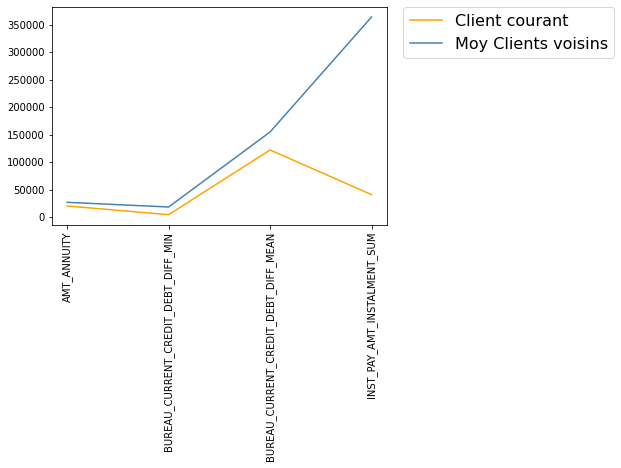

In [125]:
# Lineplot de comparaison des features importances client courant/voisins
plt.figure(figsize=(6, 4))
plt.plot(x_gp1, y_feat_client_gp1, color='Orange',
         label='Client courant')
plt.plot(x_gp1, y_moy_feat_voisins_gp3, color='SteelBlue',
         label='Moy Clients voisins')
plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,
         fontsize=16)
plt.show()

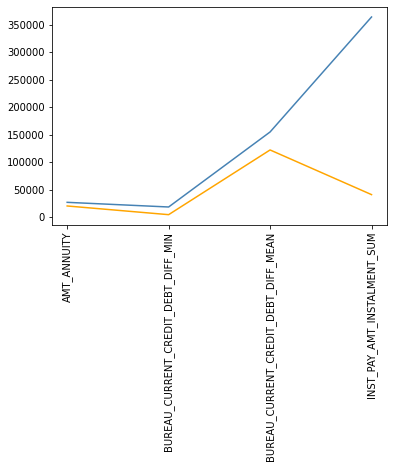

In [126]:
# Lineplot de comparaison des features importances client courant/voisins
plt.figure(figsize=(6, 4))
plt.plot(x_gp1, y_feat_client_gp1, color='Orange')
plt.plot(x_gp1, y_moy_feat_voisins_gp3, color='SteelBlue')
plt.xticks(rotation=90)
plt.show()

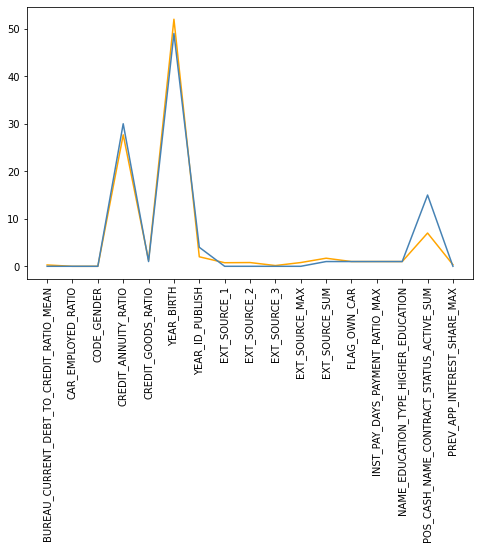

In [127]:
# Lineplot de comparaison des features importances client courant/voisins
plt.figure(figsize=(8, 5))
plt.plot(x_gp2, y_feat_client_gp2, color='Orange')
plt.plot(x_gp2, y_moy_feat_voisins_gp4, color='SteelBlue')
plt.xticks(rotation=90)
plt.show()

**go.Indicator bullets**

In [128]:
# ==============================================================
# Variable AMT_ANNUITY
# Annuité du prêt
# ==============================================================
amt_min = int(df_client.AMT_ANNUITY_MIN.values)
amt_q25 = int(df_client.AMT_ANNUITY_Q25.values)
amt_mean = int(df_client.AMT_ANNUITY_MEAN.values)
amt_q75 = int(df_client.AMT_ANNUITY_Q75.values)
amt_max = int(df_client.AMT_ANNUITY_MAX.values)
amt_client = int(df_dashboard[df_dashboard['SK_ID_CURR'] == 100001][
    'AMT_ANNUITY'].values)

fig = go.Figure()

fig.add_trace(go.Indicator(
    mode = "number+gauge+delta",
    value = amt_client,
    delta = {'reference': amt_mean,
             'increasing': {'color': 'Crimson'},
             'decreasing': {'color': 'Green'}},
    domain = {'x': [0.15, 1], 'y': [0.7, 0.9]},
    title = {'text': 'Annuité', 'font': {'size': 12},
             'align' : 'left'},
    gauge = {
        'shape': 'bullet',
        'axis': {'range': [amt_min, amt_max]},
        'threshold': {
            'line': {'color': 'black', 'width': 3},
            'thickness': 0.75,
            'value': amt_client},
        'steps': [
            {'range': [0, amt_min], 'color': 'white'},
            {'range': [amt_min, amt_q25], 'color': 'MediumOrchid'},
            {'range': [amt_q25, amt_mean], 'color': 'Thistle',
             'line': {'color': 'DarkSlateGray', 'width': 2}},
            {'range': [amt_mean, amt_q75],'color': 'Thistle',
             'line': {'color': 'DarkSlateGray', 'width': 2}},
            {'range': [amt_q75, amt_max], 'color': 'MediumOrchid'}],
        'bar': {'color': 'black'}}))

fig.update_layout(height=200,
                  margin={'t':0, 'b':0, 'l':0})

fig.show()

![image.png](attachment:image.png)

In [129]:
# ==============================================================
# Variable BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN
# Valeur minimum de la différence entre la limite de crédit actuelle
# de la carte de crédit et la dette actuelle sur le crédit
# ==============================================================
bccddm_min = int(df_client.BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN_MIN.values)
bccddm_q25 = int(df_client.BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN_Q25.values)
bccddm_mean = int(df_client.BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN_MEAN.values)
bccddm_q75 = int(df_client.BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN_Q75.values)
bccddm_max = int(df_client.BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN_MAX.values)
bccddm_client = int(df_dashboard[df_dashboard['SK_ID_CURR'] == 100001][
    'BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN'].values)

fig = go.Figure()

fig.add_trace(go.Indicator(
    mode = "number+gauge+delta",
    value = bccddm_client,
    delta = {'reference': bccddm_mean,
             'increasing': {'color': 'Crimson'},
             'decreasing': {'color': 'Green'}},
    domain = {'x': [0.35, 1], 'y': [0.7, 0.8]},
    title = {'text': 'BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN',
             'font': {'size': 9}, 'align' : 'left'},
    gauge = {
        'shape': 'bullet',
        'axis': {'range': [bccddm_min, bccddm_max]},
        'threshold': {
            'line': {'color': 'black', 'width': 3},
            'thickness': 0.75,
            'value': bccddm_client},
        'steps': [
            {'range': [0, bccddm_min], 'color': 'white'},
            {'range': [bccddm_min, bccddm_q25], 'color': 'MediumOrchid'},
            {'range': [bccddm_q25, bccddm_mean], 'color': 'Thistle',
             'line': {'color': 'DarkSlateGray', 'width': 2}},
            {'range': [bccddm_mean, bccddm_q75],'color': 'Thistle',
             'line': {'color': 'DarkSlateGray', 'width': 2}},
            {'range': [bccddm_q75, bccddm_max], 'color': 'MediumOrchid'}],
        'bar': {'color': 'black'}}))

fig.update_layout(height=300, width=700,
                  margin={'t':0, 'b':0, 'l':0})

fig.show()

![image.png](attachment:image.png)

In [130]:
# ==============================================================
# Variable BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN
# Valeur moyenne de la différence entre la limite de crédit actuelle
# de la carte de crédit et la dette actuelle sur le crédit
# ==============================================================
bccddmean_min = int(df_client.BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN_MIN.values)
bccddmean_q25 = int(df_client.BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN_Q25.values)
bccddmean_mean = int(df_client.BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN_MEAN.values)
bccddmean_q75 = int(df_client.BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN_Q75.values)
bccddmean_max = int(df_client.BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN_MAX.values)
bccddmean_client = int(df_dashboard[df_dashboard['SK_ID_CURR'] == 100001][
    'BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN'].values)

fig = go.Figure()

fig.add_trace(go.Indicator(
    mode = "number+gauge+delta",
    value = bccddmean_client,
    delta = {'reference': bccddmean_mean,
             'increasing': {'color': 'Crimson'},
             'decreasing': {'color': 'Green'}},
    domain = {'x': [0.4, 1], 'y': [0.7, 0.8]},
    title = {'text': 'BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN',
             'font': {'size': 9}, 'align' : 'left'},
    gauge = {
        'shape': 'bullet',
        'axis': {'range': [bccddmean_min, bccddmean_max]},
        'threshold': {
            'line': {'color': 'black', 'width': 3},
            'thickness': 0.75,
            'value': bccddmean_client},
        'steps': [
            {'range': [0, bccddmean_min], 'color': 'white'},
            {'range': [bccddmean_min, bccddmean_q25], 'color': 'MediumOrchid'},
            {'range': [bccddmean_q25, bccddmean_mean], 'color': 'Thistle',
             'line': {'color': 'DarkSlateGray', 'width': 2}},
            {'range': [bccddmean_mean, bccddmean_q75],'color': 'Thistle',
             'line': {'color': 'DarkSlateGray', 'width': 2}},
            {'range': [bccddmean_q75, bccddmean_max], 'color': 'MediumOrchid'}],
        'bar': {'color': 'black'}}))

fig.update_layout(height=300, width=700,
                  margin={'t':0, 'b':0, 'l':0})

fig.show()

![image.png](attachment:image.png)

In [131]:
# ==============================================================
# Variable BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN
# Moyenne de du ratio des prêts précédents sur d'autres institution de :
# la dette actuelle sur le crédit et la limite de crédit actuelle de la
# carte de crédit
# ==============================================================
bcdtcrm_min = int(df_client.BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN_MIN.values*100)
bcdtcrm_q25 = int(df_client.BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN_Q25.values*100)
bcdtcrm_mean = int(df_client.BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN_MEAN.values*100)
bcdtcrm_q75 = int(df_client.BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN_Q75.values*100)
bcdtcrm_max = int(df_client.BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN_MAX.values*100)
bcdtcrm_client = int(df_dashboard[df_dashboard['SK_ID_CURR'] == 100001][
    'BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN'].values*100)
bcdtcrm_max_axis = max(bcdtcrm_max, bcdtcrm_client)

cond = bcdtcrm_client == bcdtcrm_min and bcdtcrm_min == bcdtcrm_q25 \
    and bcdtcrm_q25 == bcdtcrm_mean and bcdtcrm_mean == bcdtcrm_q75 \
    and bcdtcrm_q75 == bcdtcrm_max

if not cond:
    fig = go.Figure()

    fig.add_trace(go.Indicator(
        mode = "number+gauge+delta",
        value = bcdtcrm_client,
        delta = {'reference': bcdtcrm_mean,
                 'increasing': {'color': 'Crimson'},
                 'decreasing': {'color': 'Green'}},
        domain = {'x': [0.5, 1], 'y': [0.7, 0.8]},
        title = {'text': 'BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN',
                 'font': {'size': 9}, 'align' : 'left'},
        gauge = {
            'shape': 'bullet',
            'axis': {'range': [bcdtcrm_min, bcdtcrm_max_axis]},
            'threshold': {
                'line': {'color': 'black', 'width': 3},
                'thickness': 0.75,
                'value': bcdtcrm_client},
            'steps': [
                {'range': [0, bcdtcrm_min], 'color': 'white'},
                {'range': [bcdtcrm_min, bcdtcrm_q25], 'color': 'MediumOrchid'},
                {'range': [bcdtcrm_q25, bcdtcrm_mean], 'color': 'Thistle',
                 'line': {'color': 'DarkSlateGray', 'width': 2}},
                {'range': [bcdtcrm_mean, bcdtcrm_q75],'color': 'Thistle',
                 'line': {'color': 'DarkSlateGray', 'width': 2}},
                {'range': [bcdtcrm_q75, bcdtcrm_max], 'color': 'MediumOrchid'}],
            'bar': {'color': 'black'}}))

    fig.update_layout(height=300, width=700,
                      margin={'t':0, 'b':0, 'l':0})

    fig.show()
else:
    print('Toutes les valeurs sont nulles.')

In [132]:
# ==============================================================
# Variable CAR_EMPLOYED_RATIO
# Ratio : Âge de la voiture du demandeur / Ancienneté dans l'emploi à la
# date de la demande
# ==============================================================
cer_max = int(df_client.CAR_EMPLOYED_RATIO_MIN.values*1000)
cer_q75 = int(df_client.CAR_EMPLOYED_RATIO_Q25.values*1000)
cer_mean = int(df_client.CAR_EMPLOYED_RATIO_MEAN.values*1000)
cer_q25 = int(df_client.CAR_EMPLOYED_RATIO_Q75.values*1000)
cer_min = int(df_client.CAR_EMPLOYED_RATIO_MAX.values*1000)
cer_client = int(df_dashboard[df_dashboard['SK_ID_CURR'] == 100001][
    'CAR_EMPLOYED_RATIO'].values*1000)
cer_max_axis = max(cer_max, cer_client)
cer_min_axis = max(cer_min, cer_client)

cond = cer_client == cer_min and cer_min == cer_q25 and \
    cer_q25 == cer_mean and cer_mean == cer_q75 and \
    cer_q75 == cer_max

if not cond:
    fig = go.Figure()

    fig.add_trace(go.Indicator(
        mode = "number+gauge+delta",
        value = cer_client,
        delta = {'reference': cer_mean,
                 'increasing': {'color': 'Crimson'},
                 'decreasing': {'color': 'Green'}},
        domain = {'x': [0.5, 1], 'y': [0.7, 0.8]},
        title = {'text': 'CAR_EMPLOYED_RATIO',
                 'font': {'size': 9}, 'align' : 'left'},
        gauge = {
            'shape': 'bullet',
            'axis': {'range': [cer_min_axis, cer_max_axis]},
            'threshold': {
                'line': {'color': 'black', 'width': 3},
                'thickness': 0.75,
                'value': cer_client},
            'steps': [
                {'range': [0, cer_min], 'color': 'white'},
                {'range': [cer_min, cer_q25], 'color': 'MediumOrchid'},
                {'range': [cer_q25, cer_mean], 'color': 'Thistle',
                 'line': {'color': 'DarkSlateGray', 'width': 2}},
                {'range': [cer_mean, cer_q75],'color': 'Thistle',
                 'line': {'color': 'DarkSlateGray', 'width': 2}},
                {'range': [cer_q75, cer_max], 'color': 'MediumOrchid'}],
            'bar': {'color': 'black'}}))

    fig.update_layout(height=300, width=700,
                      margin={'t':0, 'b':0, 'l':0})

    fig.show()
else:    
    print('Toutes les valeurs sont nulles.')

In [133]:
# ==============================================================
# Variable CODE_GENDER
# Ratio : Âge de la voiture du demandeur / Ancienneté dans l'emploi à la
# date de la demande
# ==============================================================
# Aucun intérêt : 0 ou 1.

In [134]:
# ==============================================================
# Variable CREDIT_ANNUITY_RATIO
# Ratio : montant du crédit du prêt / Annuité de prêt 
# ==============================================================
car_min = int(df_client.CREDIT_ANNUITY_RATIO_MIN.values)
car_q25 = int(df_client.CREDIT_ANNUITY_RATIO_Q25.values)
car_mean = int(df_client.CREDIT_ANNUITY_RATIO_MEAN.values)
car_q75 = int(df_client.CREDIT_ANNUITY_RATIO_Q75.values)
car_max = int(df_client.CREDIT_ANNUITY_RATIO_MAX.values)
car_client = int(df_dashboard[df_dashboard['SK_ID_CURR'] == 100001][
    'CREDIT_ANNUITY_RATIO'].values)

cond = car_client == car_min and car_min == car_q25 and \
    car_q25 == car_mean and car_mean == car_q75 \
    and car_q75 == car_max

if not cond:
    fig = go.Figure()

    fig.add_trace(go.Indicator(
        mode = "number+gauge+delta",
        value = car_client,
        delta = {'reference': car_mean,
                 'increasing': {'color': 'Crimson'},
                 'decreasing': {'color': 'Green'}},
        domain = {'x': [0.25, 1], 'y': [0.7, 0.8]},
        title = {'text': 'CREDIT_ANNUITY_RATIO',
                 'font': {'size': 9}, 'align' : 'left'},
        gauge = {
            'shape': 'bullet',
            'axis': {'range': [car_min, car_max]},
            'threshold': {
                'line': {'color': 'black', 'width': 3},
                'thickness': 0.75,
                'value': car_client},
            'steps': [
                {'range': [0, car_min], 'color': 'white'},
                {'range': [car_min, car_q25], 'color': 'MediumOrchid'},
                {'range': [car_q25, car_mean], 'color': 'Thistle',
                 'line': {'color': 'DarkSlateGray', 'width': 2}},
                {'range': [car_mean, car_q75],'color': 'Thistle',
                 'line': {'color': 'DarkSlateGray', 'width': 2}},
                {'range': [car_q75, car_max], 'color': 'MediumOrchid'}],
            'bar': {'color': 'black'}}))

    fig.update_layout(height=300, width=700,
                      margin={'t':0, 'b':0, 'l':0})

    fig.show()
else:    
    print('Toutes les valeurs sont nulles.')

![image.png](attachment:image.png)

In [135]:
# ==============================================================
# Variable CREDIT_GOODS_RATIO
# Ratio : Montant du crédit du prêt / prix des biens pour lesquels le prêt
# est accordé / Crédit est supérieur au prix des biens ?  
# ==============================================================
cgr_min = int(df_client.CREDIT_GOODS_RATIO_MIN.values)
cgr_q25 = int(df_client.CREDIT_GOODS_RATIO_Q25.values)
cgr_mean = int(df_client.CREDIT_GOODS_RATIO_MEAN.values)
cgr_q75 = int(df_client.CREDIT_GOODS_RATIO_Q75.values)
cgr_max = int(df_client.CREDIT_GOODS_RATIO_MAX.values)
cgr_client = int(df_dashboard[df_dashboard['SK_ID_CURR'] == 100001][
    'CREDIT_GOODS_RATIO'].values)

cond = cgr_client == cgr_min and cgr_min == cgr_q25 \
    and cgr_q25 == cgr_mean and cgr_mean == cgr_q75 \
    and cgr_q75 == cgr_max

if not cond:
    fig = go.Figure()

    fig.add_trace(go.Indicator(
        mode = "number+gauge+delta",
        value = cgr_client,
        delta = {'reference': cgr_mean,
                 'increasing': {'color': 'Crimson'},
                 'decreasing': {'color': 'Green'}},
        domain = {'x': [0.25, 1], 'y': [0.7, 0.8]},
        title = {'text': 'CREDIT_GOODS_RATIO',
                 'font': {'size': 9}, 'align' : 'left'},
        gauge = {
            'shape': 'bullet',
            'axis': {'range': [cgr_min, cgr_max]},
            'threshold': {
                'line': {'color': 'black', 'width': 3},
                'thickness': 0.75,
                'value': cgr_client},
            'steps': [
                {'range': [0, cgr_min], 'color': 'white'},
                {'range': [cgr_min, cgr_q25], 'color': 'MediumOrchid'},
                {'range': [cgr_q25, cgr_mean], 'color': 'Thistle',
                 'line': {'color': 'DarkSlateGray', 'width': 2}},
                {'range': [cgr_mean, cgr_q75],'color': 'Thistle',
                 'line': {'color': 'DarkSlateGray', 'width': 2}},
                {'range': [cgr_q75, cgr_max], 'color': 'MediumOrchid'}],
            'bar': {'color': 'black'}}))

    fig.update_layout(height=300, width=700,
                      margin={'t':0, 'b':0, 'l':0})

    fig.show()
else:    
    print('Toutes les valeurs sont nulles.')

Toutes les valeurs sont nulles.


In [136]:
# ==============================================================
# Variable YEAR_BIRTH
# Âge (ans) 
# ==============================================================
age_max = int(-df_client.DAYS_BIRTH_MIN.values/365)
age_q75 = int(-df_client.DAYS_BIRTH_Q25.values/365)
age_mean = int(-df_client.DAYS_BIRTH_MEAN.values/365)
age_q25 = int(-df_client.DAYS_BIRTH_Q75.values/365)
age_min = int(-df_client.DAYS_BIRTH_MAX.values/365)
age_client = int(-df_dashboard[df_dashboard['SK_ID_CURR'] == 100001][
    'DAYS_BIRTH'].values/365)

cond = age_client == age_min and age_min == age_q25 and \
    age_q25 == age_mean and age_mean == age_q75 and age_q75 == age_max

if not cond:
    fig = go.Figure()

    fig.add_trace(go.Indicator(
        mode = "number+gauge+delta",
        value = age_client,
        delta = {'reference': age_mean,
                 'increasing': {'color': 'Crimson'},
                 'decreasing': {'color': 'Green'}},
        domain = {'x': [0.25, 1], 'y': [0.7, 0.8]},
        title = {'text': 'Âge',
                 'font': {'size': 9}, 'align' : 'left'},
        gauge = {
            'shape': 'bullet',
            'axis': {'range': [age_min, age_max]},
            'threshold': {
                'line': {'color': 'black', 'width': 3},
                'thickness': 0.75,
                'value': age_client},
            'steps': [
                {'range': [0, age_min], 'color': 'white'},
                {'range': [age_min, age_q25], 'color': 'MediumOrchid'},
                {'range': [age_q25, age_mean], 'color': 'Thistle',
                 'line': {'color': 'DarkSlateGray', 'width': 2}},
                {'range': [age_mean, age_q75],'color': 'Thistle',
                 'line': {'color': 'DarkSlateGray', 'width': 2}},
                {'range': [age_q75, age_max], 'color': 'MediumOrchid'}],
            'bar': {'color': 'black'}}))

    fig.update_layout(height=300, width=700,
                      margin={'t':0, 'b':0, 'l':0})

    fig.show()
else:    
    print('Toutes les valeurs sont nulles.')

![image.png](attachment:image.png)

In [137]:
# ==============================================================
# Variable DAYS_ID_PUBLISH
# Combien de jours avant la demande le client a-t-il changé la pièce
# d'identité avec laquelle il a demandé le prêt ? (ans) 
# ==============================================================
dip_max = int(-df_client.DAYS_ID_PUBLISH_MIN.values/365)
dip_q75 = int(-df_client.DAYS_ID_PUBLISH_Q25.values/365)
dip_mean = int(-df_client.DAYS_ID_PUBLISH_MEAN.values/365)
dip_q25 = int(-df_client.DAYS_ID_PUBLISH_Q75.values/365)
dip_min = int(-df_client.DAYS_ID_PUBLISH_MAX.values/365)
dip_client = int(-df_dashboard[df_dashboard['SK_ID_CURR'] == 100001][
    'DAYS_ID_PUBLISH'].values/365)

cond = dip_client == dip_min and dip_min == dip_q25 and \
    dip_q25 == dip_mean and dip_mean == dip_q75 and dip_q75 == dip_max

if not cond:
    fig = go.Figure()

    fig.add_trace(go.Indicator(
        mode = "number+gauge+delta",
        value = dip_client,
        delta = {'reference': dip_mean,
                 'increasing': {'color': 'Crimson'},
                 'decreasing': {'color': 'Green'}},
        domain = {'x': [0.25, 1], 'y': [0.7, 0.8]},
        title = {'text': 'DAYS_ID_PUBLISH',
                 'font': {'size': 9}, 'align' : 'left'},
        gauge = {
            'shape': 'bullet',
            'axis': {'range': [dip_min, dip_max]},
            'threshold': {
                'line': {'color': 'black', 'width': 3},
                'thickness': 0.75,
                'value': dip_client},
            'steps': [
                {'range': [0, dip_min], 'color': 'white'},
                {'range': [dip_min, dip_q25], 'color': 'MediumOrchid'},
                {'range': [dip_q25, dip_mean], 'color': 'Thistle',
                 'line': {'color': 'DarkSlateGray', 'width': 2}},
                {'range': [dip_mean, dip_q75],'color': 'Thistle',
                 'line': {'color': 'DarkSlateGray', 'width': 2}},
                {'range': [dip_q75, dip_max], 'color': 'MediumOrchid'}],
            'bar': {'color': 'black'}}))

    fig.update_layout(height=300, width=700,
                      margin={'t':0, 'b':0, 'l':0})

    fig.show()
else:    
    print('Toutes les valeurs sont nulles.')

![image.png](attachment:image.png)

In [140]:
es1_min, es1_q25

(0, 0)

In [139]:
# ==============================================================
# Variable EXT_SOURCE_1
# Source externe normalisée 
# ==============================================================
es1_min = int(df_client.EXT_SOURCE_1_MIN.values * 100)
es1_q25 = int(df_client.EXT_SOURCE_1_Q25.values * 100)
es1_mean = int(df_client.EXT_SOURCE_1_MEAN.values * 100)
es1_q75 = int(df_client.EXT_SOURCE_1_Q75.values * 100)
es1_max = int(df_client.EXT_SOURCE_1_MAX.values * 100)
es1_client = int(df_dashboard[df_dashboard['SK_ID_CURR'] == 100001][
    'EXT_SOURCE_1'].values * 100)
es1_axis_min = min(es1_min, es1_client)
es1_axis_max = max(es1_max, es1_client) 

cond = es1_client == es1_min and es1_min == es1_q25 and \
    es1_q25 == es1_mean and es1_mean == es1_q75 and \
    es1_q75 == es1_max

if not cond:
    fig = go.Figure()

    fig.add_trace(go.Indicator(
        mode = "number+gauge+delta",
        value = es1_client,
        delta = {'reference': es1_mean,
                 'increasing': {'color': 'Crimson'},
                 'decreasing': {'color': 'Green'}},
        domain = {'x': [0.5, 1], 'y': [0.7, 0.8]},
        title = {'text': 'EXT_SOURCE_1',
                 'font': {'size': 9}, 'align' : 'left'},
        gauge = {
            'shape': 'bullet',
            'axis': {'range': [es1_axis_min, es1_axis_max]},
            'threshold': {
                'line': {'color': 'black', 'width': 3},
                'thickness': 0.75,
                'value': es1_client},
            'steps': [
                {'range': [0, es1_min], 'color': 'white'},
                {'range': [es1_min, es1_q25], 'color': 'MediumOrchid'},
                {'range': [es1_q25, es1_mean], 'color': 'Thistle',
                 'line': {'color': 'DarkSlateGray', 'width': 2}},
                {'range': [es1_mean, es1_q75],'color': 'Thistle',
                 'line': {'color': 'DarkSlateGray', 'width': 2}},
                {'range': [es1_q75, es1_max], 'color': 'MediumOrchid'}],
            'bar': {'color': 'black'}}))

    fig.update_layout(height=300, width=700,
                      margin={'t':0, 'b':0, 'l':0})

    fig.show()
else:    
    print('Toutes les valeurs sont nulles.')

In [141]:
# ==============================================================
# Variable EXT_SOURCE_2
# Source externe normalisée 
# ==============================================================
es2_min = int(df_client.EXT_SOURCE_2_MIN.values * 100)
es2_q25 = int(df_client.EXT_SOURCE_2_Q25.values * 100)
es2_mean = int(df_client.EXT_SOURCE_2_MEAN.values * 100)
es2_q75 = int(df_client.EXT_SOURCE_2_Q75.values * 100)
es2_max = int(df_client.EXT_SOURCE_2_MAX.values * 100)
es2_client = int(df_dashboard[df_dashboard['SK_ID_CURR'] == 100001][
    'EXT_SOURCE_2'].values * 100)
es2_axis_min = min(es2_min, es2_client)
es2_axis_max = max(es2_max, es2_client) 
    
cond = es2_client == es2_min and es2_min == es2_q25 and \
    es2_q25 == es2_mean and es2_mean == es2_q75 and \
    es2_q75 == es2_max

if not cond:
    fig = go.Figure()

    fig.add_trace(go.Indicator(
        mode = "number+gauge+delta",
        value = es2_client,
        delta = {'reference': es2_mean,
                 'increasing': {'color': 'Crimson'},
                 'decreasing': {'color': 'Green'}},
        domain = {'x': [0.5, 1], 'y': [0.8, 1]},
        title = {'text': 'EXT_SOURCE_2',
                 'font': {'size': 9}, 'align' : 'left'},
        gauge = {
            'shape': 'bullet',
            'axis': {'range': [es2_axis_min, es2_axis_max]},
            'threshold': {
                'line': {'color': 'black', 'width': 3},
                'thickness': 0.75,
                'value': es2_client},
            'steps': [
                {'range': [0, es2_min], 'color': 'white'},
                {'range': [es2_min, es2_q25], 'color': 'MediumOrchid'},
                {'range': [es2_q25, es2_mean], 'color': 'Thistle',
                 'line': {'color': 'DarkSlateGray', 'width': 2}},
                {'range': [es2_mean, es2_q75],'color': 'Thistle',
                 'line': {'color': 'DarkSlateGray', 'width': 2}},
                {'range': [es2_q75, es2_max], 'color': 'MediumOrchid'}],
            'bar': {'color': 'black'}}))

    fig.update_layout(height=300, width=700,
                      margin={'t':0, 'b':0, 'l':0})

    fig.show()
else:    
    print('Toutes les valeurs sont nulles.')

In [142]:
# ==============================================================
# Variable EXT_SOURCE_3
# Source externe normalisée 
# ==============================================================
es3_min = int(df_client.EXT_SOURCE_3_MIN.values * 100)
es3_q25 = int(df_client.EXT_SOURCE_3_Q25.values * 100)
es3_mean = int(df_client.EXT_SOURCE_3_MEAN.values * 100)
es3_q75 = int(df_client.EXT_SOURCE_3_Q75.values * 100)
es3_max = int(df_client.EXT_SOURCE_3_MAX.values * 100)
es3_client = int(df_dashboard[df_dashboard['SK_ID_CURR'] == 100001][
    'EXT_SOURCE_3'].values * 100)
es3_axis_min = min(es3_min, es3_client)
es3_axis_max = max(es3_max, es3_client) 

cond = es3_client == es3_min and es3_min == es3_q25 and \
    es3_q25 == es3_mean and es3_mean == es3_q75 and \
    es3_q75 == es3_max

if not cond:
    fig = go.Figure()

    fig.add_trace(go.Indicator(
        mode = "number+gauge+delta",
        value = es3_client,
        delta = {'reference': es3_mean,
                 'increasing': {'color': 'Crimson'},
                 'decreasing': {'color': 'Green'}},
        domain = {'x': [0.5, 1], 'y': [0.8, 1]},
        title = {'text': 'EXT_SOURCE_3',
                 'font': {'size': 9}, 'align' : 'left'},
        gauge = {
            'shape': 'bullet',
            'axis': {'range': [es3_axis_min, es3_axis_max]},
            'threshold': {
                'line': {'color': 'black', 'width': 3},
                'thickness': 0.75,
                'value': es3_client},
            'steps': [
                {'range': [0, es3_min], 'color': 'white'},
                {'range': [es3_min, es3_q25], 'color': 'MediumOrchid'},
                {'range': [es3_q25, es3_mean], 'color': 'Thistle',
                 'line': {'color': 'DarkSlateGray', 'width': 2}},
                {'range': [es3_mean, es3_q75],'color': 'Thistle',
                 'line': {'color': 'DarkSlateGray', 'width': 2}},
                {'range': [es3_q75, es3_max], 'color': 'MediumOrchid'}],
            'bar': {'color': 'black'}}))

    fig.update_layout(height=300, width=700,
                      margin={'t':0, 'b':0, 'l':0})

    fig.show()
else:    
    print('Toutes les valeurs sont nulles.')

In [143]:
# ==============================================================
# Variable EXT_SOURCE_MAX
# Source externe normalisée 
# ==============================================================
esm_min = int(df_client.EXT_SOURCE_MAX_MIN.values * 100)
esm_q25 = int(df_client.EXT_SOURCE_MAX_Q25.values * 100)
esm_mean = int(df_client.EXT_SOURCE_MAX_MEAN.values * 100)
esm_q75 = int(df_client.EXT_SOURCE_MAX_Q75.values * 100)
esm_max = int(df_client.EXT_SOURCE_MAX_MAX.values * 100)
esm_client = int(df_dashboard[df_dashboard['SK_ID_CURR'] == 100001][
    'EXT_SOURCE_MAX'].values * 100)
esm_axis_min = min(esm_min, esm_client)
esm_axis_max = max(esm_max, esm_client) 

cond = esm_client == esm_min and esm_min == esm_q25 and \
    esm_q25 == esm_mean and esm_mean == esm_q75 and \
    esm_q75 == esm_max

if not cond:
    fig = go.Figure()

    fig.add_trace(go.Indicator(
        mode = "number+gauge+delta",
        value = esm_client,
        delta = {'reference': esm_mean,
                 'increasing': {'color': 'Crimson'},
                 'decreasing': {'color': 'Green'}},
        domain = {'x': [0.5, 1], 'y': [0.8, 1]},
        title = {'text': 'EXT_SOURCE_MAX',
                 'font': {'size': 9}, 'align' : 'left'},
        gauge = {
            'shape': 'bullet',
            'axis': {'range': [esm_axis_min, esm_axis_max]},
            'threshold': {
                'line': {'color': 'black', 'width': 3},
                'thickness': 0.75,
                'value': esm_client},
            'steps': [
                {'range': [0, esm_min], 'color': 'white'},
                {'range': [esm_min, esm_q25], 'color': 'MediumOrchid'},
                {'range': [esm_q25, esm_mean], 'color': 'Thistle',
                 'line': {'color': 'DarkSlateGray', 'width': 2}},
                {'range': [esm_mean, esm_q75],'color': 'Thistle',
                 'line': {'color': 'DarkSlateGray', 'width': 2}},
                {'range': [esm_q75, esm_max], 'color': 'MediumOrchid'}],
            'bar': {'color': 'black'}}))

    fig.update_layout(height=300, width=700,
                      margin={'t':0, 'b':0, 'l':0})

    fig.show()
else:    
    print('Toutes les valeurs sont nulles.')

In [144]:
# ==============================================================
# Variable EXT_SOURCE_SUM
# Source externe normalisée 
# ==============================================================
ess_min = int(df_client.EXT_SOURCE_SUM_MIN.values * 100)
ess_q25 = int(df_client.EXT_SOURCE_SUM_Q25.values * 100)
ess_mean = int(df_client.EXT_SOURCE_SUM_MEAN.values * 100)
ess_q75 = int(df_client.EXT_SOURCE_SUM_Q75.values * 100)
ess_max = int(df_client.EXT_SOURCE_SUM_MAX.values * 100)
ess_client = int(df_dashboard[df_dashboard['SK_ID_CURR'] == 100001][
    'EXT_SOURCE_SUM'].values * 100)
ess_axis_min = min(ess_min, ess_client)
ess_axis_max = max(ess_max, ess_client) 

cond = ess_client == ess_min and ess_min == ess_q25 and \
    ess_q25 == ess_mean and ess_mean == ess_q75 and \
    ess_q75 == ess_max

if not cond:
    fig = go.Figure()

    fig.add_trace(go.Indicator(
        mode = "number+gauge+delta",
        value = ess_client,
        delta = {'reference': ess_mean,
                 'increasing': {'color': 'Crimson'},
                 'decreasing': {'color': 'Green'}},
        domain = {'x': [0.5, 1], 'y': [0.8, 1]},
        title = {'text': 'EXT_SOURCE_SUM',
                 'font': {'size': 9}, 'align' : 'left'},
        gauge = {
            'shape': 'bullet',
            'axis': {'range': [ess_axis_min, ess_axis_max]},
            'threshold': {
                'line': {'color': 'black', 'width': 3},
                'thickness': 0.75,
                'value': ess_client},
            'steps': [
                {'range': [0, ess_min], 'color': 'white'},
                {'range': [ess_min, ess_q25], 'color': 'MediumOrchid'},
                {'range': [ess_q25, ess_mean], 'color': 'Thistle',
                 'line': {'color': 'DarkSlateGray', 'width': 2}},
                {'range': [ess_mean, ess_q75],'color': 'Thistle',
                 'line': {'color': 'DarkSlateGray', 'width': 2}},
                {'range': [ess_q75, ess_max], 'color': 'MediumOrchid'}],
            'bar': {'color': 'black'}}))

    fig.update_layout(height=300, width=700,
                      margin={'t':0, 'b':0, 'l':0})

    fig.show()
else:    
    print('Toutes les valeurs sont nulles.')

In [145]:
# ==============================================================
# Variable FLAG_OWN_CAR
# Indicateur si le client possède une voiture
# ==============================================================
# Aucun intérêt : 0 ou 1.

In [147]:
ipais_min

23391

In [146]:
# ==============================================================
# Variable INST_PAY_AMT_INSTALMENT_SUM
# Somme du montant de l'acompte prescrit des crédits précédents sur cet
# acompte
# ==============================================================
ipais_min = int(df_client.INST_PAY_AMT_INSTALMENT_SUM_MIN.values)
ipais_q25 = int(df_client.INST_PAY_AMT_INSTALMENT_SUM_Q25.values)
ipais_mean = int(df_client.INST_PAY_AMT_INSTALMENT_SUM_MEAN.values)
ipais_q75 = int(df_client.INST_PAY_AMT_INSTALMENT_SUM_Q75.values)
ipais_max = int(df_client.INST_PAY_AMT_INSTALMENT_SUM_MAX.values)
ipais_client = int(df_dashboard[df_dashboard['SK_ID_CURR'] == 100001][
    'INST_PAY_AMT_INSTALMENT_SUM'].values)
ipais_axis_min = min(ipais_min, ipais_client)
ipais_axis_max = max(ipais_max, ipais_client)

cond = ipais_client == ipais_min and ipais_min == ipais_q25 and \
    ipais_q25 == ipais_mean and ipais_mean == ipais_q75 and \
    ipais_q75 == ipais_max

if not cond:
    fig = go.Figure()

    fig.add_trace(go.Indicator(
        mode = "number+gauge+delta",
        value = ipais_client,
        delta = {'reference': ipais_mean,
                 'increasing': {'color': 'Crimson'},
                 'decreasing': {'color': 'Green'}},
        domain = {'x': [0.5, 1], 'y': [0.8, 1]},
        title = {'text': 'INST_PAY_AMT_INSTALMENT_SUM',
                 'font': {'size': 9}, 'align' : 'left'},
        gauge = {
            'shape': 'bullet',
            'axis': {'range': [ipais_axis_min, ipais_axis_max]},
            'threshold': {
                'line': {'color': 'black', 'width': 3},
                'thickness': 0.75,
                'value': ipais_client},
            'steps': [
                {'range': [0, ipais_min], 'color': 'white'},
                {'range': [ipais_min, ipais_q25], 'color': 'MediumOrchid'},
                {'range': [ipais_q25, ipais_mean], 'color': 'Thistle',
                 'line': {'color': 'DarkSlateGray', 'width': 2}},
                {'range': [ipais_mean, ipais_q75],'color': 'Thistle',
                 'line': {'color': 'DarkSlateGray', 'width': 2}},
                {'range': [ipais_q75, ipais_max], 'color': 'MediumOrchid'}],
            'bar': {'color': 'black'}}))

    fig.update_layout(height=300, width=700,
                      margin={'t':0, 'b':0, 'l':0})

    fig.show()
else:    
    print('Toutes les valeurs sont nulles.')

![image.png](attachment:image.png)

In [148]:
# ==============================================================
# Variable INST_PAY_DAYS_PAYMENT_RATIO_MAX
# Valeur maximal dans l'historique des précédents crédits remboursés
# dans Home Crédit du ratio : La date à laquelle le versement du crédit
# précédent était censé être payé (par rapport à la date de demande du
# prêt actuel) \ Quand les échéances du crédit précédent ont-elles été
# effectivement payées (par rapport à la date de demande du prêt 
# ==============================================================
ipdprm_min = int(df_client.INST_PAY_DAYS_PAYMENT_RATIO_MAX_MIN.values)
ipdprm_q25 = int(df_client.INST_PAY_DAYS_PAYMENT_RATIO_MAX_Q25.values)
ipdprm_mean = int(df_client.INST_PAY_DAYS_PAYMENT_RATIO_MAX_MEAN.values)
ipdprm_q75 = int(df_client.INST_PAY_DAYS_PAYMENT_RATIO_MAX_Q75.values)
ipdprm_max = int(df_client.INST_PAY_DAYS_PAYMENT_RATIO_MAX_MAX.values)
ipdprm_client = int(df_dashboard[df_dashboard['SK_ID_CURR'] == 100001][
    'INST_PAY_DAYS_PAYMENT_RATIO_MAX'].values)
ipdprm_axis_min = min(ipdprm_min, ipdprm_client)
ipdprm_axis_max = max(ipdprm_max, ipdprm_client)

cond = ipdprm_client == ipdprm_min and ipdprm_min == ipdprm_q25 and \
    ipdprm_q25 == ipdprm_mean and ipdprm_mean == ipdprm_q75 and \
    ipdprm_q75 == ipdprm_max

if not cond:
    fig = go.Figure()

    fig.add_trace(go.Indicator(
        mode = "number+gauge+delta",
        value = ipdprm_client,
        delta = {'reference': ipdprm_mean,
                 'increasing': {'color': 'Crimson'},
                 'decreasing': {'color': 'Green'}},
        domain = {'x': [0.5, 1], 'y': [0.8, 1]},
        title = {'text': 'INST_PAY_DAYS_PAYMENT_RATIO_MAX',
                 'font': {'size': 9}, 'align' : 'left'},
        gauge = {
            'shape': 'bullet',
            'axis': {'range': [ipdprm_axis_min, ipdprm_axis_max]},
            'threshold': {
                'line': {'color': 'black', 'width': 3},
                'thickness': 0.75,
                'value': ipdprm_client},
            'steps': [
                {'range': [0, ipdprm_min], 'color': 'white'},
                {'range': [ipdprm_min, ipdprm_q25], 'color': 'MediumOrchid'},
                {'range': [ipdprm_q25, ipdprm_mean], 'color': 'Thistle',
                 'line': {'color': 'DarkSlateGray', 'width': 2}},
                {'range': [ipdprm_mean, ipdprm_q75],'color': 'Thistle',
                 'line': {'color': 'DarkSlateGray', 'width': 2}},
                {'range': [ipdprm_q75, ipdprm_max], 'color': 'MediumOrchid'}],
            'bar': {'color': 'black'}}))

    fig.update_layout(height=300, width=700,
                      margin={'t':0, 'b':0, 'l':0})

    fig.show()
else:    
    print('Toutes les valeurs sont nulles.')

![image.png](attachment:image.png)

In [149]:
# ==============================================================
# Variable NAME_EDUCATION_TYPE_HIGHER_EDUCATION
# Niveau d'éducation le plus élévé 
# ==============================================================
# Aucun intérêt : 0 ou 1.

In [150]:
# ==============================================================
# Variable NAME_FAMILY_STATUS_MARRIED
# Situation de famille 
# ==============================================================
# Aucun intérêt : 0 ou 1.

In [151]:
# ==============================================================
# Variable POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_SUM
# Somme des contrats actifs au cours du mois 
# ==============================================================
pcncsas_min = int(df_client.POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_SUM_MIN.values)
pcncsas_q25 = int(df_client.POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_SUM_Q25.values)
pcncsas_mean = int(df_client.POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_SUM_MEAN.values)
pcncsas_q75 = int(df_client.POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_SUM_Q75.values)
pcncsas_max = int(df_client.POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_SUM_MAX.values)
pcncsas_client = int(df_dashboard[df_dashboard['SK_ID_CURR'] == 100001][
    'POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_SUM'].values)
pcncsas_axis_min = min(pcncsas_min, pcncsas_client)
pcncsas_axis_max = max(pcncsas_max, pcncsas_client)

cond = pcncsas_client == pcncsas_min and pcncsas_min == pcncsas_q25 and \
    pcncsas_q25 == pcncsas_mean and pcncsas_mean == pcncsas_q75 and \
    pcncsas_q75 == pcncsas_max

if not cond:
    fig = go.Figure()

    fig.add_trace(go.Indicator(
        mode = "number+gauge+delta",
        value = pcncsas_client,
        delta = {'reference': pcncsas_mean,
                 'increasing': {'color': 'Crimson'},
                 'decreasing': {'color': 'Green'}},
        domain = {'x': [0.5, 1], 'y': [0.8, 1]},
        title = {'text': 'POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_SUM',
                 'font': {'size': 9}, 'align' : 'left'},
        gauge = {
            'shape': 'bullet',
            'axis': {'range': [pcncsas_axis_min, pcncsas_axis_max]},
            'threshold': {
                'line': {'color': 'black', 'width': 3},
                'thickness': 0.75,
                'value': pcncsas_client},
            'steps': [
                {'range': [0, pcncsas_min], 'color': 'white'},
                {'range': [pcncsas_min, pcncsas_q25], 'color': 'MediumOrchid'},
                {'range': [pcncsas_q25, pcncsas_mean], 'color': 'Thistle',
                 'line': {'color': 'DarkSlateGray', 'width': 2}},
                {'range': [pcncsas_mean, pcncsas_q75],'color': 'Thistle',
                 'line': {'color': 'DarkSlateGray', 'width': 2}},
                {'range': [pcncsas_q75, pcncsas_max], 'color': 'MediumOrchid'}],
            'bar': {'color': 'black'}}))

    fig.update_layout(height=300, width=700,
                      margin={'t':0, 'b':0, 'l':0})

    fig.show()
else:    
    print('Toutes les valeurs sont nulles.')

![image.png](attachment:image.png)

In [152]:
# ==============================================================
# Variable PREV_APP_INTEREST_SHARE_MAX
# La valeur maximale de tous les précédents crédit dans d'autres
# institution : de la durée du crédit multiplié par l'annuité du prêt
# moins le montant final du crédit 
# ==============================================================
paism_min = int(df_client.PREV_APP_INTEREST_SHARE_MAX_MIN.values)
paism_q25 = int(df_client.PREV_APP_INTEREST_SHARE_MAX_Q25.values)
paism_mean = int(df_client.PREV_APP_INTEREST_SHARE_MAX_MEAN.values)
paism_q75 = int(df_client.PREV_APP_INTEREST_SHARE_MAX_Q75.values)
paism_max = int(df_client.PREV_APP_INTEREST_SHARE_MAX_MAX.values)
paism_client = int(df_dashboard[df_dashboard['SK_ID_CURR'] == 100001][
    'PREV_APP_INTEREST_SHARE_MAX'].values)
paism_axis_min = min(paism_min, paism_client)
paism_axis_max = max(paism_max, paism_client)

cond = paism_client == paism_min and paism_min == paism_q25 and \
    paism_q25 == paism_mean and paism_mean == paism_q75 and \
    paism_q75 == paism_max

if not cond:
    fig = go.Figure()

    fig.add_trace(go.Indicator(
        mode = "number+gauge+delta",
        value = paism_client,
        delta = {'reference': paism_mean,
                 'increasing': {'color': 'Crimson'},
                 'decreasing': {'color': 'Green'}},
        domain = {'x': [0.5, 1], 'y': [0.8, 1]},
        title = {'text': 'PREV_APP_INTEREST_SHARE_MAX',
                 'font': {'size': 9}, 'align' : 'left'},
        gauge = {
            'shape': 'bullet',
            'axis': {'range': [paism_axis_min, paism_axis_max]},
            'threshold': {
                'line': {'color': 'black', 'width': 3},
                'thickness': 0.75,
                'value': paism_client},
            'steps': [
                {'range': [0, paism_min], 'color': 'white'},
                {'range': [paism_min, paism_q25], 'color': 'MediumOrchid'},
                {'range': [paism_q25, paism_mean], 'color': 'Thistle',
                 'line': {'color': 'DarkSlateGray', 'width': 2}},
                {'range': [paism_mean, paism_q75],'color': 'Thistle',
                 'line': {'color': 'DarkSlateGray', 'width': 2}},
                {'range': [paism_q75, paism_max], 'color': 'MediumOrchid'}],
            'bar': {'color': 'black'}}))

    fig.update_layout(height=300, width=700,
                      margin={'t':0, 'b':0, 'l':0})

    fig.show()
else:    
    print('Toutes les valeurs sont nulles.')

Toutes les valeurs sont nulles.


#### <span style='background:Moccasin'>5.2.2. Dataframe de tous les clients du train set</span>

In [153]:
train_all = train_set.copy(deep=True)

In [154]:
# Ajout YEAR_BIRTH : DAYS_BIRTH en années positives
train_all['YEAR_BIRTH'] = \
    np.trunc(np.abs(train_all['DAYS_BIRTH'] / 365)).astype('int8')

In [155]:
# Ajout YEAR_EMPLOYED : DAYS_EMPLOYED en années positives
train_all['YEAR_EMPLOYED'] = \
    np.trunc(np.abs(train_all['DAYS_EMPLOYED'] / 365)).astype('int8')

In [156]:
# Ajout SEXE : de CODE_GENDER : 0 = Féminin et 1 = Masculin
train_all['SEXE'] = ['Féminin' if row == 0 else 'Masculin'
                     for row in train_all['CODE_GENDER']] 

In [157]:
train_all.columns.to_list()

['SK_ID_CURR',
 'TARGET',
 'TARGET_NEIGHBORS_500_MEAN',
 'PREV_APP_AMT_CREDIT_GOODS_RATIO_MIN',
 'PREV_APP_AMT_ANNUITY_MIN',
 'INST_PAY_DAYS_PAYMENT_DIFF_MIN',
 'INST_PAY_AMT_INSTALMENT_MIN',
 'PREV_APP_AMT_ANNUITY_MEAN',
 'NAME_INCOME_TYPE_WORKING',
 'PREV_APP_AMT_CREDIT_GOODS_RATIO_MEAN',
 'INST_PAY_DAYS_INSTALMENT_MAX',
 'INST_PAY_NUM_INSTALMENT_VERSION_SUM',
 'BUREAU_AMT_CREDIT_SUM_DEBT_SUM',
 'CREDIT_INCOME_RATIO',
 'BUREAU_DAYS_CREDIT_MEAN',
 'INST_PAY_AMT_PAYMENT_DIFF_MEAN',
 'ENQ_CREDIT_RATIO',
 'INST_PAY_DAYS_PAYMENT_RATIO_MIN',
 'INST_PAY_AMT_PAYMENT_RATIO_MEAN',
 'EXT_SOURCE_MAX',
 'PREV_APP_INTEREST_SHARE_MEAN',
 'CCB_CNT_DRAWINGS_ATM_CURRENT_MEAN',
 'PREV_APP_DAYS_FIRST_DUE_SUM',
 'FLAG_OWN_CAR',
 'INST_PAY_DAYS_PAYMENT_RATIO_MAX',
 'BUREAU_CREDIT_TYPE_MORTGAGE_MEAN',
 'PREV_APP_NAME_CONTRACT_STATUS_MEAN',
 'REGION_RATING_CLIENT',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'NAME_FAMILY_STATUS_MARRIED',
 'PREV_APP_CNT_PAYMENT_MEAN',
 'PREV_APP_AMT_DOWN_PAYMENT_MEAN',
 'CCB_BALANCE_LIMIT

In [158]:
# Récupération des valeurs min, max, mean pour toutes les variables
# impactantes numériques et mode pour les qualitatives
df_all_train_agg = \
    train_all.groupby(['TARGET']).agg({
    'AMT_ANNUITY': ['min', 'max', 'mean'],
    'BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN': ['min', 'max', 'mean'],
    'BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN': ['min', 'max', 'mean'],
    'BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN': ['min', 'max', 'mean'],
    'CAR_EMPLOYED_RATIO': ['min', 'max', 'mean'],
    'CODE_GENDER': ['min', 'max', 'mean'],
    'CREDIT_ANNUITY_RATIO': ['min', 'max', 'mean'],
    'CREDIT_GOODS_RATIO': ['min', 'max', 'mean'],
    'YEAR_BIRTH': ['min', 'max', 'mean'],
    'YEAR_EMPLOYED': ['min', 'max', 'mean'],
    'DAYS_ID_PUBLISH': ['min', 'max', 'mean'],
    'EXT_SOURCE_1': ['min', 'max', 'mean'],
    'EXT_SOURCE_2': ['min', 'max', 'mean'],
    'EXT_SOURCE_3': ['min', 'max', 'mean'],
    'EXT_SOURCE_MAX': ['min', 'max', 'mean'],
    'EXT_SOURCE_SUM': ['min', 'max', 'mean'],
    'FLAG_OWN_CAR': ['min', 'max', 'mean'],
    'INST_PAY_AMT_INSTALMENT_SUM': ['min', 'max', 'mean'],
    'INST_PAY_DAYS_PAYMENT_RATIO_MAX': ['min', 'max', 'mean'],
    'POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_SUM': ['min', 'max', 'mean'],
    'PREV_APP_INTEREST_SHARE_MAX': ['min', 'max', 'mean'],
    'AMT_CREDIT': ['min', 'max', 'mean'],
    'SEXE':  lambda x: pd.Series.mode(x)[0]
    })

In [159]:
# Ajout des colonnes sous forme nom_min ou max..
df_all_train_agg.columns = ['_'.join(tup).strip().upper()
                               for tup in df_all_train_agg.columns.values]

In [160]:
# Replace les index multiples comme simples colonnes
df_all_train_agg.reset_index(inplace=True) 

In [161]:
# Sauvegarde des scores de df_all_train_agg
fic_sav_df_all_train_agg = '/content/drive/My Drive/sauvegarde/dashboard/df_all_train_agg.pickle'
with open(fic_sav_df_all_train_agg, 'wb') as f:
    pickle.dump(df_all_train_agg, f, pickle.HIGHEST_PROTOCOL)
print(df_all_train_agg.shape)
df_all_train_agg.head(4)

(2, 68)


,TARGET,AMT_ANNUITY_MIN,AMT_ANNUITY_MAX,AMT_ANNUITY_MEAN,BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN_MIN,BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN_MAX,BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN_MEAN,BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN_MIN,BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN_MAX,BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN_MEAN,BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN_MIN,BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN_MAX,BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN_MEAN,CAR_EMPLOYED_RATIO_MIN,CAR_EMPLOYED_RATIO_MAX,CAR_EMPLOYED_RATIO_MEAN,CODE_GENDER_MIN,CODE_GENDER_MAX,CODE_GENDER_MEAN,CREDIT_ANNUITY_RATIO_MIN,CREDIT_ANNUITY_RATIO_MAX,CREDIT_ANNUITY_RATIO_MEAN,CREDIT_GOODS_RATIO_MIN,CREDIT_GOODS_RATIO_MAX,CREDIT_GOODS_RATIO_MEAN,YEAR_BIRTH_MIN,YEAR_BIRTH_MAX,YEAR_BIRTH_MEAN,YEAR_EMPLOYED_MIN,YEAR_EMPLOYED_MAX,YEAR_EMPLOYED_MEAN,DAYS_ID_PUBLISH_MIN,DAYS_ID_PUBLISH_MAX,DAYS_ID_PUBLISH_MEAN,EXT_SOURCE_1_MIN,EXT_SOURCE_1_MAX,EXT_SOURCE_1_MEAN,EXT_SOURCE_2_MIN,EXT_SOURCE_2_MAX,EXT_SOURCE_2_MEAN,EXT_SOURCE_3_MIN,EXT_SOURCE_3_MAX,EXT_SOURCE_3_MEAN,EXT_SOURCE_MAX_MIN,EXT_SOURCE_MAX_MAX,EXT_SOURCE_MAX_MEAN,EXT_SOURCE_SUM_MIN,EXT_SOURCE_SUM_MAX,EXT_SOURCE_SUM_MEAN,FLAG_OWN_CAR_MIN,FLAG_OWN_CAR_MAX,FLAG_OWN_CAR_MEAN,INST_PAY_AMT_INSTALMENT_SUM_MIN,INST_PAY_AMT_INSTALMENT_SUM_MAX,INST_PAY_AMT_INSTALMENT_SUM_MEAN,INST_PAY_DAYS_PAYMENT_RATIO_MAX_MIN,INST_PAY_DAYS_PAYMENT_RATIO_MAX_MAX,INST_PAY_DAYS_PAYMENT_RATIO_MAX_MEAN,POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_SUM_MIN,POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_SUM_MAX,POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_SUM_MEAN,PREV_APP_INTEREST_SHARE_MAX_MIN,PREV_APP_INTEREST_SHARE_MAX_MAX,PREV_APP_INTEREST_SHARE_MAX_MEAN,AMT_CREDIT_MIN,AMT_CREDIT_MAX,AMT_CREDIT_MEAN,SEXE_<LAMBDA>
0,0,1615.5,258025.5,27163.6289,-3.8875e+07,1.4229e+08,54044.3516,-1.8121e+07,1.9807e+08,193783.9219,-1.0375e+11,2.2333e+11,5343491.5,-9.0001,900000.0,3.1723,0,1,0.3340,6.3242,59.5625,21.6875,0.15,6.000,1.1201,20,69,43.7132,0,49,5.7798,-7197,0,-3017.2193,0.0146,0.9629,0.5083,5.9605e-08,0.855,0.5234,0.0005,0.894,0.5239,0.0601,0.9629,0.6475,0.1279,2.5605,1.5557,0,1,0.6568,0.000,2.3275e+07,659181.5625,0.1428,864.5,1.0908,0.0,271.0,26.8125,-1.0,2.6758,0.4546,45000.0,4050000.0,602651.1875,Féminin
1,1,2722.5,149211.0,26481.7441,-2.3758e+07,5.9591e+06,30454.0488,-2.0200e+06,7.0498e+06,137781.9219,-3.7636e+09,2.8549e+10,8454347.0,-11.5001,900000.0,36.2386,0,1,0.4292,8.0391,45.2812,20.7656,0.30,2.666,1.1514,21,68,40.2800,0,44,4.4215,-6207,0,-2732.0996,0.0147,0.9292,0.4578,5.0068e-06,0.812,0.4114,0.0005,0.896,0.4238,0.0330,0.9292,0.5771,0.0712,2.4160,1.2930,0,1,0.6948,1684.665,1.1494e+07,603106.6875,0.3181,834.5,1.1475,0.0,217.0,24.0938,-1.0,2.0000,0.5425,45000.0,4027680.0,557778.5000,Féminin


In [162]:
# Chargement du dataframe df_all_train_agg
fic_sav_df_all_train_agg ='/content/drive/My Drive/sauvegarde/dashboard/df_all_train_agg.pickle'
with open(fic_sav_df_all_train_agg, 'rb') as df_all_train_agg:
    df_all_train_agg = pickle.load(df_all_train_agg)
df_all_train_agg.shape

(2, 68)

In [163]:
filename =  '/content/drive/My Drive/sauvegarde/pickle/df_all_train_agg.pickle'
outfile = open(filename,'wb')
pickle.dump(df_all_train_agg, outfile)
outfile.close()

In [164]:
dump(df_all_train_agg,
     '/content/drive/My Drive/sauvegarde/joblib/df_all_train_agg.joblib', compress=1)

['/content/drive/My Drive/sauvegarde/joblib/df_all_train_agg.joblib']

In [165]:
# Récupération des valeurs min, max, mean pour toutes les variables
# impactantes numériques et mode pour les qualitatives
df_all_train_bis_agg = \
    application_train.groupby(['TARGET']).agg({
    'CNT_CHILDREN': ['min', 'max', 'mean'],
    'AMT_INCOME_TOTAL': ['min', 'max', 'mean'],
    'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
    'NAME_FAMILY_STATUS':  lambda x: pd.Series.mode(x)[0],
    'NAME_EDUCATION_TYPE':  lambda x: pd.Series.mode(x)[0],
    'NAME_INCOME_TYPE':  lambda x: pd.Series.mode(x)[0],
    'NAME_CONTRACT_TYPE':  lambda x: pd.Series.mode(x)[0],
    'NAME_HOUSING_TYPE':  lambda x: pd.Series.mode(x)[0]
    })

In [166]:
# Ajout des colonnes sous forme nom_min ou max..
df_all_train_bis_agg.columns = ['_'.join(tup).strip().upper()
                                for tup in df_all_train_bis_agg.columns.values]

In [167]:
# Replace les index multiples comme simples colonnes
df_all_train_bis_agg.reset_index(inplace=True) 

In [168]:
# Sauvegarde des scores df_voisins_train
fic_sav_df_all_train_bis_agg = '/content/drive/My Drive/sauvegarde/dashboard/df_all_train_bis_agg.pickle'
with open(fic_sav_df_all_train_bis_agg, 'wb') as f:
    pickle.dump(df_all_train_bis_agg, f, pickle.HIGHEST_PROTOCOL)
print(df_all_train_bis_agg.shape)
df_all_train_bis_agg.head(4)

(2, 15)


,TARGET,CNT_CHILDREN_MIN,CNT_CHILDREN_MAX,CNT_CHILDREN_MEAN,AMT_INCOME_TOTAL_MIN,AMT_INCOME_TOTAL_MAX,AMT_INCOME_TOTAL_MEAN,AMT_GOODS_PRICE_MIN,AMT_GOODS_PRICE_MAX,AMT_GOODS_PRICE_MEAN,NAME_FAMILY_STATUS_<LAMBDA>,NAME_EDUCATION_TYPE_<LAMBDA>,NAME_INCOME_TYPE_<LAMBDA>,NAME_CONTRACT_TYPE_<LAMBDA>,NAME_HOUSING_TYPE_<LAMBDA>
0,0,0,19,0.4129,25650.0,1.8000e+07,169077.4722,40500.0,4050000.0,542738.5068,Married,Secondary / secondary special,Working,Cash loans,House / apartment
1,1,0,11,0.4638,25650.0,1.1700e+08,165611.7609,45000.0,3600000.0,488972.4126,Married,Secondary / secondary special,Working,Cash loans,House / apartment


In [169]:
# Chargement du dataframe df_all_train_agg
fic_sav_df_all_train_bis_agg ='/content/drive/My Drive/sauvegarde/dashboard/df_all_train_bis_agg.pickle'
with open(fic_sav_df_all_train_bis_agg, 'rb') as df_all_train_bis_agg:
    df_all_train_bis_agg = pickle.load(df_all_train_bis_agg)
df_all_train_bis_agg.shape

(2, 15)

**Lineplot**

Affiche les valeurs les plus déterminantes sur la prédiction pour :
- le client courant,
- les 10 clients voisins du train set,
- la moyenne pour tous les non-défaillants,
- et la moyenne pour tous les défaillants,

In [170]:
# Exemple id_client = 100001
df_client = \
    df_voisin_train_agg[df_voisin_train_agg['ID_CLIENT'] == 100001].astype(int)

In [171]:
group_val1 = ['AMT_ANNUITY',
              'BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN',
              'BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN',
              'BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN',
              'INST_PAY_AMT_INSTALMENT_SUM']

In [172]:
group_val2 = ['CAR_EMPLOYED_RATIO', 'CODE_GENDER',
              'CREDIT_ANNUITY_RATIO', 'CREDIT_GOODS_RATIO',
              'YEAR_BIRTH', 'YEAR_ID_PUBLISH',
              'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
              'EXT_SOURCE_MAX', 'EXT_SOURCE_SUM',
              'FLAG_OWN_CAR',
              'INST_PAY_DAYS_PAYMENT_RATIO_MAX',
              'POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_SUM',
              'PREV_APP_INTEREST_SHARE_MAX']

In [173]:
# Valeurs moyennes des features importances pour le client courant
df_client_courant = \
    df_dashboard[df_dashboard['SK_ID_CURR'] == 100001]
df_feat_client  = df_client_courant[['SK_ID_CURR', 'AMT_ANNUITY',
           'BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN',
           'BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN',
           'BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN',
           'CAR_EMPLOYED_RATIO', 'CODE_GENDER',
           'CREDIT_ANNUITY_RATIO', 'CREDIT_GOODS_RATIO',
           'DAYS_BIRTH', 'DAYS_ID_PUBLISH',
           'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
           'EXT_SOURCE_MAX', 'EXT_SOURCE_SUM',
           'FLAG_OWN_CAR', 'INST_PAY_AMT_INSTALMENT_SUM',
           'INST_PAY_DAYS_PAYMENT_RATIO_MAX',
           'POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_SUM',
           'PREV_APP_INTEREST_SHARE_MAX']]
df_feat_client['YEAR_BIRTH'] = \
    np.trunc(np.abs(df_feat_client['DAYS_BIRTH'] / 365)).astype('int8')
df_feat_client['YEAR_ID_PUBLISH'] = \
    np.trunc(np.abs(df_feat_client['DAYS_ID_PUBLISH'] / 365)).astype('int8')
df_feat_client.drop(columns=['DAYS_BIRTH', 'DAYS_ID_PUBLISH'],
                    inplace=True)
df_feat_client_gp1 = df_feat_client[group_val1]
df_feat_client_gp2 = df_feat_client[group_val2]
# X
x_gp1 = df_feat_client_gp1.columns.to_list()
x_gp2 = df_feat_client_gp2.columns.to_list()
# y
y_feat_client_gp1 = df_feat_client_gp1.values[0].tolist()
y_feat_client_gp2 = df_feat_client_gp2.values[0].tolist()

In [174]:
group_val3 = ['AMT_ANNUITY_MEAN',
              'BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN_MEAN',
              'BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN_MEAN',
              'BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN_MEAN',
              'INST_PAY_AMT_INSTALMENT_SUM_MEAN']

In [175]:
group_val4 = ['CAR_EMPLOYED_RATIO_MEAN', 'CODE_GENDER_MEAN',
              'CREDIT_ANNUITY_RATIO_MEAN', 'CREDIT_GOODS_RATIO_MEAN',
              'YEAR_BIRTH_MEAN', 'YEAR_ID_PUBLISH_MEAN',
              'EXT_SOURCE_1_MEAN', 'EXT_SOURCE_2_MEAN', 'EXT_SOURCE_3_MEAN',
              'EXT_SOURCE_MAX_MEAN', 'EXT_SOURCE_SUM_MEAN',
              'FLAG_OWN_CAR_MEAN',
              'INST_PAY_DAYS_PAYMENT_RATIO_MAX_MEAN',
              'POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_SUM_MEAN',
              'PREV_APP_INTEREST_SHARE_MAX_MEAN']

In [176]:
# Valeurs moyennes des features importances pour les 10 voisins
df_moy_feat_voisins = df_client[['ID_CLIENT', 'AMT_ANNUITY_MEAN',
           'BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN_MEAN',
           'BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN_MEAN',
           'BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN_MEAN',
           'CAR_EMPLOYED_RATIO_MEAN', 'CODE_GENDER_MEAN',
           'CREDIT_ANNUITY_RATIO_MEAN', 'CREDIT_GOODS_RATIO_MEAN',
           'DAYS_BIRTH_MEAN', 'DAYS_ID_PUBLISH_MEAN',
           'EXT_SOURCE_1_MEAN', 'EXT_SOURCE_2_MEAN', 'EXT_SOURCE_3_MEAN',
           'EXT_SOURCE_MAX_MEAN', 'EXT_SOURCE_SUM_MEAN',
           'FLAG_OWN_CAR_MEAN', 'INST_PAY_AMT_INSTALMENT_SUM_MEAN',
           'INST_PAY_DAYS_PAYMENT_RATIO_MAX_MEAN',
           'POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_SUM_MEAN',
           'PREV_APP_INTEREST_SHARE_MAX_MEAN']]
df_moy_feat_voisins['YEAR_BIRTH_MEAN'] = \
    np.trunc(np.abs(df_moy_feat_voisins['DAYS_BIRTH_MEAN'] / 365)).astype('int8')
df_moy_feat_voisins['YEAR_ID_PUBLISH_MEAN'] = \
    np.trunc(np.abs(df_moy_feat_voisins['DAYS_ID_PUBLISH_MEAN'] / 365)).astype('int8')
df_moy_feat_voisins.drop(columns=['DAYS_BIRTH_MEAN', 'DAYS_ID_PUBLISH_MEAN'],
                    inplace=True)
df_moy_feat_voisins_gp3 = df_moy_feat_voisins[group_val3]
df_moy_feat_voisins_gp4 = df_moy_feat_voisins[group_val4]
# y
y_moy_feat_voisins_gp3 = df_moy_feat_voisins_gp3.values[0].tolist()
y_moy_feat_voisins_gp4 = df_moy_feat_voisins_gp4.values[0].tolist()

In [177]:
# Valeurs moyennes de tous les clients non-défaillants/défaillants du train sets
df_all_train = df_all_train_agg[['TARGET', 'AMT_ANNUITY_MEAN',
           'BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN_MEAN',
           'BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN_MEAN',
           'BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN_MEAN',
           'CAR_EMPLOYED_RATIO_MEAN', 'CODE_GENDER_MEAN',
           'CREDIT_ANNUITY_RATIO_MEAN', 'CREDIT_GOODS_RATIO_MEAN',
           'YEAR_BIRTH_MEAN', 'DAYS_ID_PUBLISH_MEAN',
           'EXT_SOURCE_1_MEAN', 'EXT_SOURCE_2_MEAN', 'EXT_SOURCE_3_MEAN',
           'EXT_SOURCE_MAX_MEAN', 'EXT_SOURCE_SUM_MEAN',
           'FLAG_OWN_CAR_MEAN', 'INST_PAY_AMT_INSTALMENT_SUM_MEAN',
           'INST_PAY_DAYS_PAYMENT_RATIO_MAX_MEAN',
           'POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_SUM_MEAN',
           'PREV_APP_INTEREST_SHARE_MAX_MEAN']]
df_all_train['YEAR_ID_PUBLISH_MEAN'] = \
    np.trunc(np.abs(df_all_train['DAYS_ID_PUBLISH_MEAN'] / 365)).astype('int8')
df_all_train.drop(columns=['DAYS_ID_PUBLISH_MEAN'],
                    inplace=True)
# Non-défaillants
df_all_train_nondef_gp3 = df_all_train[df_all_train['TARGET'] == 0][group_val3]
df_all_train_nondef_gp4 = df_all_train[df_all_train['TARGET'] == 0][group_val4]
# Défaillants
df_all_train_def_gp3 = df_all_train[df_all_train['TARGET'] == 1][group_val3]
df_all_train_def_gp4 = df_all_train[df_all_train['TARGET'] == 1][group_val4]
# y
# Non-défaillants
y_all_train_nondef_gp3 = df_all_train_nondef_gp3.values[0].tolist()
y_all_train_nondef_gp4 = df_all_train_nondef_gp4.values[0].tolist()
# Défaillants
y_all_train_def_gp3 = df_all_train_def_gp3.values[0].tolist()
y_all_train_def_gp4 = df_all_train_def_gp4.values[0].tolist()

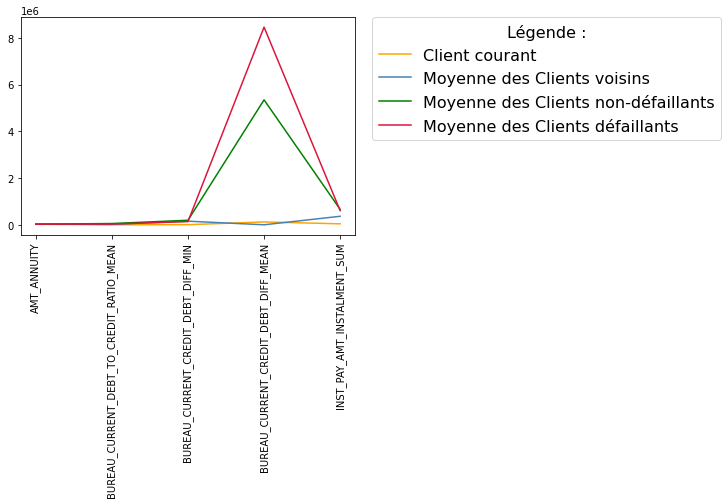

In [178]:
# Lineplot de comparaison des features importances client courant/voisins
plt.figure(figsize=(6, 4))
plt.plot(x_gp1, y_feat_client_gp1, color='Orange',
         label='Client courant')
plt.plot(x_gp1, y_moy_feat_voisins_gp3, color='SteelBlue',
         label='Moyenne des Clients voisins')
plt.plot(x_gp1, y_all_train_nondef_gp3, color='Green',
         label='Moyenne des Clients non-défaillants')
plt.plot(x_gp1, y_all_train_def_gp3, color='Crimson',
         label='Moyenne des Clients défaillants')
plt.xticks(rotation=90)
plt.legend(title='Légende :', title_fontsize=16, 
           bbox_to_anchor=(1.05, 1),
           loc=2, borderaxespad=0., fontsize=16)
plt.show()

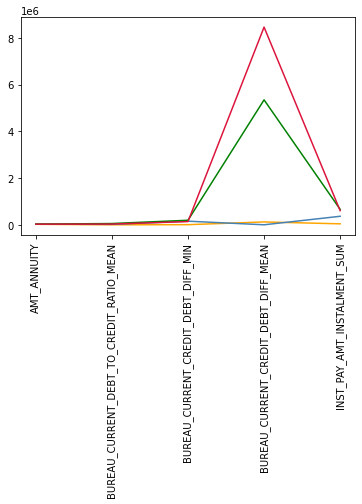

In [179]:
# Lineplot de comparaison des features importances client courant/voisins
plt.figure(figsize=(6, 4))
plt.plot(x_gp1, y_feat_client_gp1, color='Orange')
plt.plot(x_gp1, y_moy_feat_voisins_gp3, color='SteelBlue')
plt.plot(x_gp1, y_all_train_nondef_gp3, color='Green')
plt.plot(x_gp1, y_all_train_def_gp3, color='Crimson')
plt.xticks(rotation=90)
plt.show()

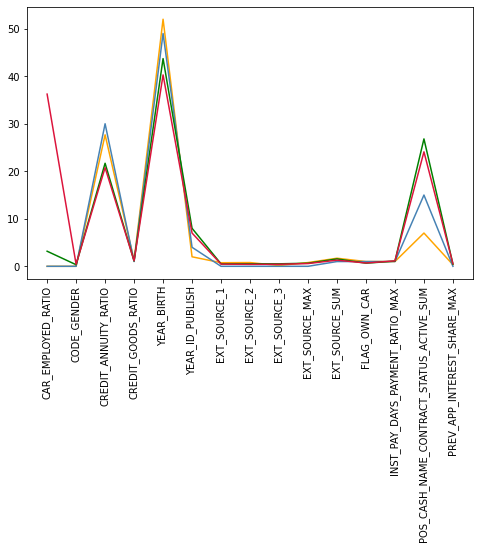

In [180]:
# Lineplot de comparaison des features importances client courant/voisins
plt.figure(figsize=(8, 5))
plt.plot(x_gp2, y_feat_client_gp2, color='Orange')
plt.plot(x_gp2, y_moy_feat_voisins_gp4, color='SteelBlue')
plt.plot(x_gp2, y_all_train_nondef_gp4, color='Green')
plt.plot(x_gp2, y_all_train_def_gp4, color='Crimson')
plt.xticks(rotation=90)
plt.show()

#### <span style='background:Moccasin'>5.2.3. Dataframe de tous les clients du test set</span>

In [181]:
# Les variables les plus déterminantes
feat_imp

['AMT_ANNUITY',
 'BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN',
 'BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN',
 'BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN',
 'CAR_EMPLOYED_RATIO',
 'CODE_GENDER',
 'CREDIT_ANNUITY_RATIO',
 'CREDIT_GOODS_RATIO',
 'DAYS_BIRTH',
 'DAYS_ID_PUBLISH',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'EXT_SOURCE_MAX',
 'EXT_SOURCE_SUM',
 'FLAG_OWN_CAR',
 'INST_PAY_AMT_INSTALMENT_SUM',
 'INST_PAY_DAYS_PAYMENT_RATIO_MAX',
 'NAME_EDUCATION_TYPE_HIGHER_EDUCATION',
 'NAME_FAMILY_STATUS_MARRIED',
 'POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_SUM',
 'PREV_APP_INTEREST_SHARE_MAX']

<span style='background:Moccasin'>**YEAR_BIRTH - Âge du client**</span>

**Essai de graphique pour situer le client entre les défaillants/non défaillants**

***Distplot***

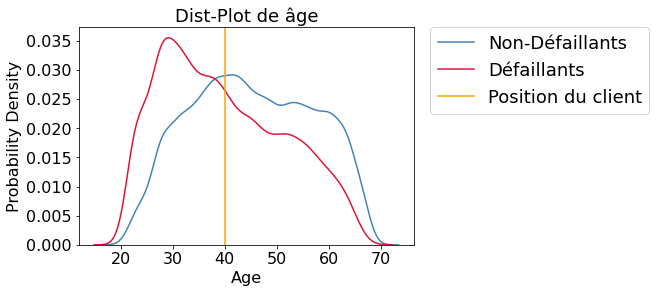

In [182]:
# Non-défaillants
sns.distplot(df_dashboard['YEAR_BIRTH'][df_dashboard[
    'PRED_CLASSE_CLIENT'] == 0],
             label='Non-Défaillants', hist=False, color='SteelBlue')
# Défaillants
sns.distplot(df_dashboard['YEAR_BIRTH'][df_dashboard[
    'PRED_CLASSE_CLIENT'] == 1],
             label='Défaillants', hist=False, color='Crimson')
plt.xlabel('Age', fontsize=16)
plt.ylabel('Probability Density', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title('Dist-Plot de âge', fontsize=18)
# Position du client
plt.axvline(x=40,color='orange', label='Position du client')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=18)

plt.show()

***Boxplot***

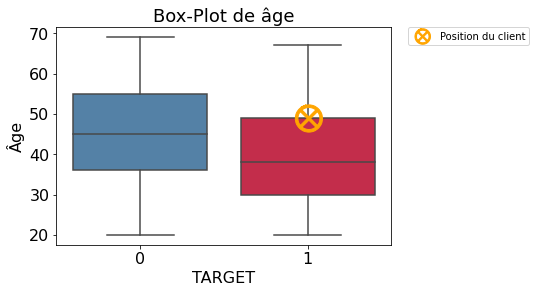

In [183]:
sns.boxplot(x='PRED_CLASSE_CLIENT',
            y='YEAR_BIRTH',
            data=df_dashboard,
            palette=['SteelBlue', 'Crimson'])
plt.title("Box-Plot de âge", fontsize=18)
plt.xlabel('TARGET', fontsize=16)
plt.ylabel('Âge', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

df_client = df_dashboard.iloc[1]
plt.plot(df_client['PRED_CLASSE_CLIENT'],
         df_client['YEAR_BIRTH'],
         color="orange",
         marker="$\\bigotimes$", markersize=28)
import matplotlib.lines as mlines
client = mlines.Line2D([], [], color='orange', marker='$\\bigotimes$',
                       linestyle='None',
                       markersize=16, label='Position du client')
plt.legend(handles=[client],
               bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

***ViolinPlot***

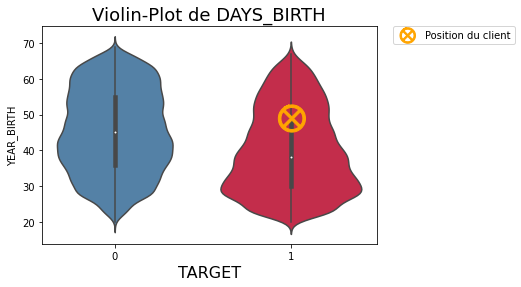

In [184]:
sns.violinplot(x='PRED_CLASSE_CLIENT', y='YEAR_BIRTH',
               data=df_dashboard,
               palette=['SteelBlue', 'Crimson'])
plt.title("Violin-Plot de DAYS_BIRTH", fontsize=18)
df_client = df_dashboard.iloc[1]
plt.plot(df_client['PRED_CLASSE_CLIENT'],
         df_client['YEAR_BIRTH'],
         color="orange",
         marker="$\\bigotimes$", markersize=28)
plt.xlabel('TARGET', fontsize=16)
client = mlines.Line2D([], [], color='orange', marker='$\\bigotimes$',
                       linestyle='None',
                       markersize=16, label='Position du client')
plt.legend(handles=[client], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

<span style='background:Moccasin'>**AMT_ANNUITY -Annuité du prêt**</span>

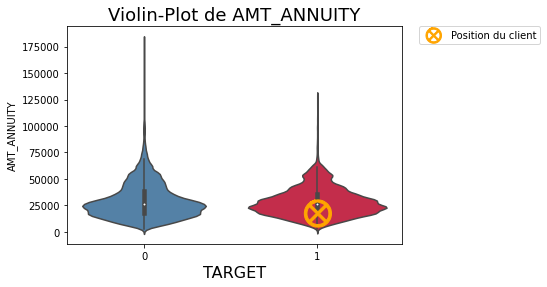

In [185]:
sns.violinplot(x='PRED_CLASSE_CLIENT', y='AMT_ANNUITY',
               data=df_dashboard,
               palette=['SteelBlue', 'Crimson'])
plt.title("Violin-Plot de AMT_ANNUITY", fontsize=18)
df_client = df_dashboard.iloc[1]
plt.plot(df_client['PRED_CLASSE_CLIENT'],
         df_client['AMT_ANNUITY'],
         color="orange",
         marker="$\\bigotimes$", markersize=28)
plt.xlabel('TARGET', fontsize=16)
client = mlines.Line2D([], [], color='orange', marker='$\\bigotimes$',
                       linestyle='None',
                       markersize=16, label='Position du client')
plt.legend(handles=[client], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

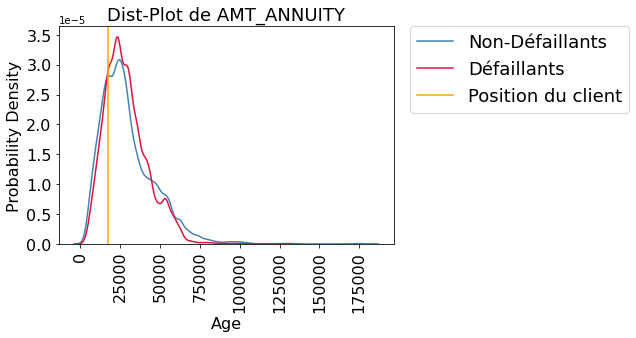

In [186]:
# Non-défaillants
sns.distplot(df_dashboard['AMT_ANNUITY'][df_dashboard[
    'PRED_CLASSE_CLIENT'] == 0],
             label='Non-Défaillants', hist=False, color='SteelBlue')
# Défaillants
sns.distplot(df_dashboard['AMT_ANNUITY'][df_dashboard[
    'PRED_CLASSE_CLIENT'] == 1],
             label='Défaillants', hist=False, color='Crimson')
plt.xlabel('Age', fontsize=16)
plt.ylabel('Probability Density', fontsize=16)
plt.xticks(fontsize=16, rotation=90)
plt.yticks(fontsize=16)
plt.title('Dist-Plot de AMT_ANNUITY', fontsize=18)
# Position du client
plt.axvline(x=df_client['AMT_ANNUITY'], color='orange', label='Position du client')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=18)

plt.show()

<span style='background:Moccasin'>**BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN**</span>

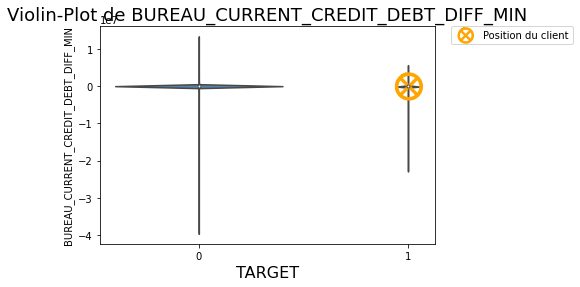

In [187]:
sns.violinplot(x='PRED_CLASSE_CLIENT', y='BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN',
               data=df_dashboard,
               palette=['SteelBlue', 'Crimson'])
plt.title("Violin-Plot de BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN", fontsize=18)
df_client = df_dashboard.iloc[1]
plt.plot(df_client['PRED_CLASSE_CLIENT'],
         df_client['BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN'],
         color="orange",
         marker="$\\bigotimes$", markersize=28)
plt.xlabel('TARGET', fontsize=16)
client = mlines.Line2D([], [], color='orange', marker='$\\bigotimes$',
                       linestyle='None',
                       markersize=16, label='Position du client')
plt.legend(handles=[client], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

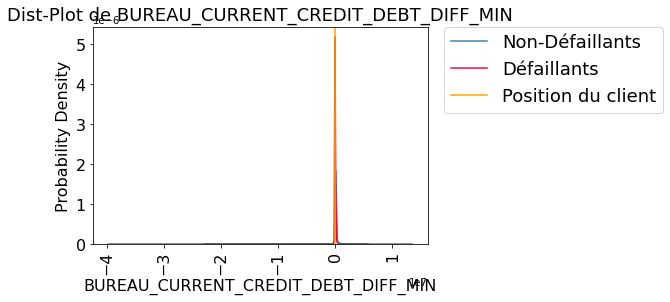

In [188]:
# Non-défaillants
sns.distplot(df_dashboard['BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN'][df_dashboard[
    'PRED_CLASSE_CLIENT'] == 0],
             label='Non-Défaillants', hist=False, color='SteelBlue')
# Défaillants
sns.distplot(df_dashboard['BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN'][df_dashboard[
    'PRED_CLASSE_CLIENT'] == 1],
             label='Défaillants', hist=False, color='Crimson')
plt.xlabel('BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN', fontsize=16)
plt.ylabel('Probability Density', fontsize=16)
plt.xticks(fontsize=16, rotation=90)
plt.yticks(fontsize=16)
plt.title('Dist-Plot de BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN', fontsize=18)
# Position du client
plt.axvline(x=df_client['BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN'], color='orange', label='Position du client')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=18)

plt.show()

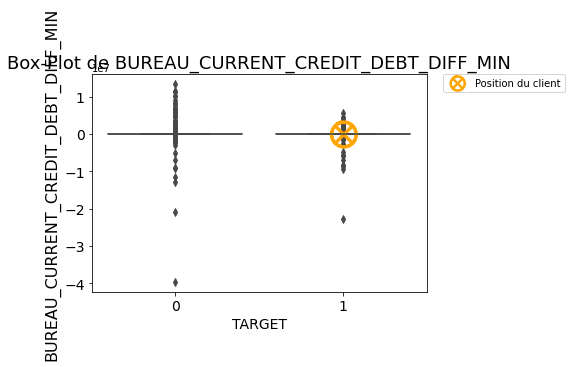

In [189]:
sns.boxplot(x='PRED_CLASSE_CLIENT',
            y='BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN',
            data=df_dashboard,
            palette=['SteelBlue', 'Crimson'])
plt.title("Box-Plot de BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN", fontsize=18)
plt.xlabel('TARGET', fontsize=14)
plt.ylabel('BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

df_client = df_dashboard.iloc[1]
plt.plot(df_client['PRED_CLASSE_CLIENT'],
         df_client['BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN'],
         color="orange",
         marker="$\\bigotimes$", markersize=28)
import matplotlib.lines as mlines
client = mlines.Line2D([], [], color='orange', marker='$\\bigotimes$',
                       linestyle='None',
                       markersize=16, label='Position du client')
plt.legend(handles=[client],
               bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

### <span style='background:PowderBlue'>5.3. Score du client</span>

**Prédiction pour un client**

In [190]:
# Sélection des variables du clients
client_id = 100001
X_test = test_set[test_set['SK_ID_CURR'] == client_id]
X_test

,SK_ID_CURR,TARGET_NEIGHBORS_500_MEAN,PREV_APP_AMT_CREDIT_GOODS_RATIO_MIN,PREV_APP_AMT_ANNUITY_MIN,INST_PAY_DAYS_PAYMENT_DIFF_MIN,INST_PAY_AMT_INSTALMENT_MIN,PREV_APP_AMT_ANNUITY_MEAN,NAME_INCOME_TYPE_WORKING,PREV_APP_AMT_CREDIT_GOODS_RATIO_MEAN,INST_PAY_DAYS_INSTALMENT_MAX,INST_PAY_NUM_INSTALMENT_VERSION_SUM,BUREAU_AMT_CREDIT_SUM_DEBT_SUM,CREDIT_INCOME_RATIO,BUREAU_DAYS_CREDIT_MEAN,INST_PAY_AMT_PAYMENT_DIFF_MEAN,ENQ_CREDIT_RATIO,INST_PAY_DAYS_PAYMENT_RATIO_MIN,INST_PAY_AMT_PAYMENT_RATIO_MEAN,EXT_SOURCE_MAX,PREV_APP_INTEREST_SHARE_MEAN,CCB_CNT_DRAWINGS_ATM_CURRENT_MEAN,PREV_APP_DAYS_FIRST_DUE_SUM,FLAG_OWN_CAR,INST_PAY_DAYS_PAYMENT_RATIO_MAX,BUREAU_CREDIT_TYPE_MORTGAGE_MEAN,PREV_APP_NAME_CONTRACT_STATUS_MEAN,REGION_RATING_CLIENT,DEF_30_CNT_SOCIAL_CIRCLE,NAME_FAMILY_STATUS_MARRIED,PREV_APP_CNT_PAYMENT_MEAN,PREV_APP_AMT_DOWN_PAYMENT_MEAN,CCB_BALANCE_LIMIT_RATIO_MEAN,PREV_APP_AMT_CREDIT_GOODS_RATIO_MAX,POS_CASH_SK_DPD_DEF_MEAN,NAME_EDUCATION_TYPE_HIGHER_EDUCATION,POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_MEAN,BUREAU_AMT_CREDIT_SUM_DEBT_MEAN,POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_SUM,CODE_GENDER,INST_PAY_AMT_INSTALMENT_SUM,BUREAU_AMT_CREDIT_MAX_OVERDUE_MAX,CAR_EMPLOYED_RATIO,DAYS_ID_PUBLISH,PREV_APP_DAYS_FIRST_LAST_DUE_DIFF_MEAN,ANNUITY_INCOME_RATIO,INST_PAY_DAYS_PAYMENT_RATIO_MEAN,PREV_APP_DAYS_LAST_DUE_MAX,EXT_SOURCE_2,CREDIT_GOODS_RATIO,BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN,PREV_APP_INTEREST_SHARE_MAX,POS_CASH_CNT_INSTALMENT_MEAN,INST_PAY_AMT_INSTALMENT_MAX,BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN,EXT_SOURCE_1,AMT_CREDIT,BUREAU_DAYS_CREDIT_MAX,EXT_SOURCE_SUM,DAYS_EMPLOYED,EXT_SOURCE_3,PREV_APP_SELLERPLACE_AREA_MEAN,BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN,BUREAU_AMT_CREDIT_SUM_MEAN,BUREAU_AMT_CREDIT_SUM_SUM,AMT_ANNUITY,DAYS_BIRTH,REGION_POPULATION_RELATIVE,DAYS_LAST_PHONE_CHANGE,INST_PAY_DAYS_INSTALMENT_MIN,PREV_APP_AMT_INTEREST_MEAN,PREV_APP_AMT_ANNUITY_SUM,INCOME_GOODS_DIFF,FLOORSMAX_AVG,PREV_APP_PRODUCT_COMBINATION_POS_INDUSTRY_WITH_INTEREST_MEAN,PREV_APP_LOAN_RATE_MEAN,PREV_APP_ANNUITY_MEAN,OWN_CAR_AGE,INST_PAY_NUM_INSTALMENT_NUMBER_MAX,BUREAU_CREDIT_ACTIVE_ACTIVE_COUNT,PKPRET_BUREAU_BALANCE_STATUS_SUM_MEAN,PREV_APP_AMT_CREDIT_GOODS_DIFF_MAX,PREV_APP_CODE_REJECT_REASON_XAP_MEAN,PREV_APP_ANNUITY_GOODS_MEAN,PREV_APP_DAYS_DECISION_MEAN,BUREAU_CREDIT_TYPE_MICROLOAN_MEAN,PREV_APP_HOUR_APPR_PROCESS_START_MEAN,PREV_APP_APPLICATION_AMT_TO_DECISION_RATIO_MEAN,CREDIT_ANNUITY_RATIO,EXT_SOURCE_VAR,INST_PAY_DAYS_PAYMENT_DIFF_MAX,DAYS_REGISTRATION,INST_PAY_DAYS_PAYMENT_DIFF_MEAN,CCB_AMT_BALANCE_MEAN,REG_CITY_NOT_LIVE_CITY,INST_PAY_NUM_INSTALMENT_VERSION_MEAN,YEARS_BEGINEXPLUATATION_AVG,PKPRET_BUREAU_BALANCE_MONTHS_BALANCE_MAX_MEAN,PREV_APP_INTEREST_RATE_MAX,INST_PAY_AMT_INSTALMENT_MEAN
0,100001,0.056,0.9578,3951.0,-10.0,3951.0,3951.0,1.0,0.9578,-1619.0,8.0,596686.5,4.2148,-735.0,0.0,0.0,0.979,1.0,0.7896,0.3289,0.2106,-1709.0,1,1.0039,0.0,0.0,2,0.0,1.0,8.0,2520.0,0.1145,0.9578,0.7778,1.0,0.7778,85240.9297,7.0,0,41195.9258,0.0,-0.0039,-812,90.0,0.1523,0.9951,-1619.0,0.7896,1.2637,122382.6406,0.3289,4.0,17397.9004,4761.0,0.7524,568800.0,-49.0,1.7012,-2328.0,0.1595,23.0,0.2825,207623.5781,1453365.0,20560.5,-19241,0.0188,-1740.0,-2916.0,7821.0,3951.0,0.3,0.125,0.0,0.1661,2973.375,9.0,4.0,7.0,13.0,-1048.5,1.0,3104.4375,-1740.0,0.0,13.0,14.2733,27.6719,0.0833,36.0,-5168.0,7.4297,16381.5674,0,1.1426,0.9731,23.5781,0.877,5885.1323


In [191]:
# Score des prédictions de probabiltés
y_proba = best_model.predict_proba(X_test.drop('SK_ID_CURR', axis=1))[:, 1]

In [192]:
# Score du client en pourcentage arrondi et nombre entier
y_proba_client = int(np.rint(y_proba * 100))
y_proba_client

35

**Jauge pour le score du client**

[Source_plotly_jauge](https://plotly.com/python/gauge-charts/)

In [193]:
fig = go.Figure(go.Indicator(
    mode = 'gauge+number+delta',
    # Score du client en % df_dashboard['SCORE_CLIENT_%']
    value = y_proba_client,  
    domain = {'x': [0, 1], 'y': [0, 1]},
    title = {'text': 'Crédit score du client', 'font': {'size': 24}},
    # Score des 10 voisins test set
    # df_dashboard['SCORE_10_VOISINS_MEAN_TEST']
    delta = {'reference': 76,
             'increasing': {'color': 'Crimson'},
             'decreasing': {'color': 'Green'}},
    gauge = {'axis': {'range': [None, 100],
                      'tickwidth': 3,
                      'tickcolor': 'darkblue'},
             'bar': {'color': 'white', 'thickness' : 0.25},
             'bgcolor': 'white',
             'borderwidth': 2,
             'bordercolor': 'gray',
             'steps': [{'range': [0, 25], 'color': 'Green'},
                       {'range': [25, 49.49], 'color': 'LimeGreen'},
                       {'range': [49.5, 50.5], 'color': 'red'},
                       {'range': [50.51, 75], 'color': 'Orange'},
                       {'range': [75, 100], 'color': 'Crimson'}],
             'threshold': {'line': {'color': 'white', 'width': 10},
                           'thickness': 0.8,
                           # Score du client en %
                           # df_dashboard['SCORE_CLIENT_%']
                           'value': y_proba_client}}))

fig.update_layout(paper_bgcolor='white',
                  height=400, width=600,
                  font={'color': 'darkblue', 'family': 'Arial'})

fig.show()

![image.png](attachment:image.png)

### <span style='background:PowderBlue'>5.4. SHAP Values</span>

In [194]:
# Test set sans l'identifiant
X_test = test_set.set_index('SK_ID_CURR')

In [195]:
# Entraînement de shap sur le train set
shap_explainer = shap.Explainer(best_model, X_test)
shap_values = shap_explainer(X_test, check_additivity=False)

100%|===================| 48531/48744 [01:06<00:00]       

In [197]:
# Sauvegarde du shap explainer
filename = '/content/drive/My Drive/sauvegarde/shap/shap_explainer.pickle'
outfile = open(filename,'wb')
pickle.dump(shap_explainer, outfile)
outfile.close()

In [198]:
# Sauvegarde des shap values 
filename = '/content/drive/My Drive/sauvegarde/shap/shap_values.pickle'
outfile = open(filename,'wb')
pickle.dump(shap_values, outfile)
outfile.close()

In [199]:
shap_values

.values =
array([[-1.74025688e-01,  4.26764440e-03, -4.06659650e-03, ...,
        -1.39034390e-03, -1.85805492e-03, -5.01321267e-03],
       [ 4.93499870e-01, -1.58004078e-02, -6.77967491e-03, ...,
        -1.39034390e-03,  1.75797818e-03, -1.57240782e-03],
       [-9.43551138e-01,  2.89197285e-03, -4.87665720e-04, ...,
         1.35905445e-04,  1.89915411e-03, -3.16090755e-03],
       ...,
       [-7.72481199e-01, -1.95841864e-04, -6.81457040e-04, ...,
        -1.39034390e-03, -9.27648842e-03,  5.56122456e-04],
       [-3.36120431e-01,  5.05794920e-03, -4.08775173e-04, ...,
         1.35905445e-04, -1.00395143e-03,  4.06530838e-03],
       [ 7.88564309e-01,  2.00043259e-02, -9.02220607e-05, ...,
        -1.65998073e-03,  1.75797818e-03,  5.56122456e-04]])

.base_values =
array([-0.48465476, -0.48465476, -0.48465476, ..., -0.48465476,
       -0.48465476, -0.48465476])

.data =
array([[5.5999756e-02, 9.5778221e-01, 3.9510000e+03, ..., 2.3578125e+01,
        8.7695312e-01, 5.8851323e+03]

In [200]:
# SHAP values
shap_values.values.shape

(48744, 98)

In [201]:
# Données X_test
shap_values.data

array([[5.5999756e-02, 9.5778221e-01, 3.9510000e+03, ..., 2.3578125e+01,
        8.7695312e-01, 5.8851323e+03],
       [1.1798096e-01, 8.9994955e-01, 4.8132002e+03, ..., 6.0000000e+00,
        8.0957031e-01, 6.2402051e+03],
       [1.6006470e-02, 9.3932980e-01, 4.7424150e+03, ..., 5.6500000e+01,
        7.9394531e-01, 1.0897898e+04],
       ...,
       [2.7999878e-02, 8.9997631e-01, 1.2640950e+04, ..., 1.7406250e+01,
        4.2504883e-01, 2.3158992e+04],
       [4.4006348e-02, 9.6615815e-01, 5.5199248e+03, ..., 5.7187500e+01,
        8.4765625e-01, 1.7269234e+04],
       [1.9604492e-01, 1.0000000e+00, 7.8476851e+03, ..., 2.8000000e+01,
        7.8417969e-01, 1.3238063e+04]], dtype=float32)

In [202]:
# Seuil de décision
shap_values.base_values

array([-0.48465476, -0.48465476, -0.48465476, ..., -0.48465476,
       -0.48465476, -0.48465476])

**Graphiques Globaux**

***BarPlot***

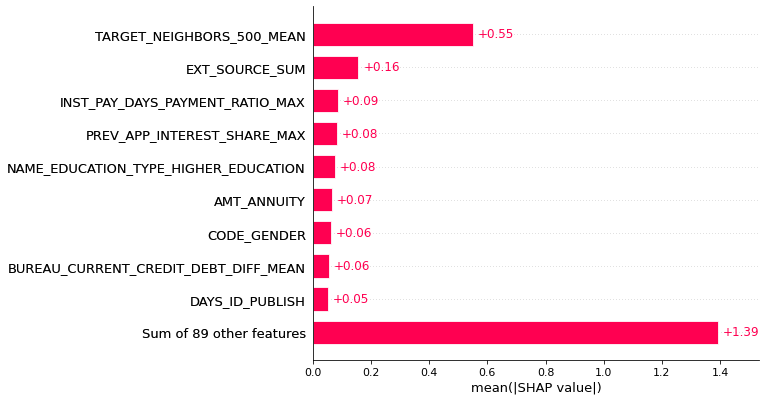

In [203]:
shap.plots.bar(shap_values)

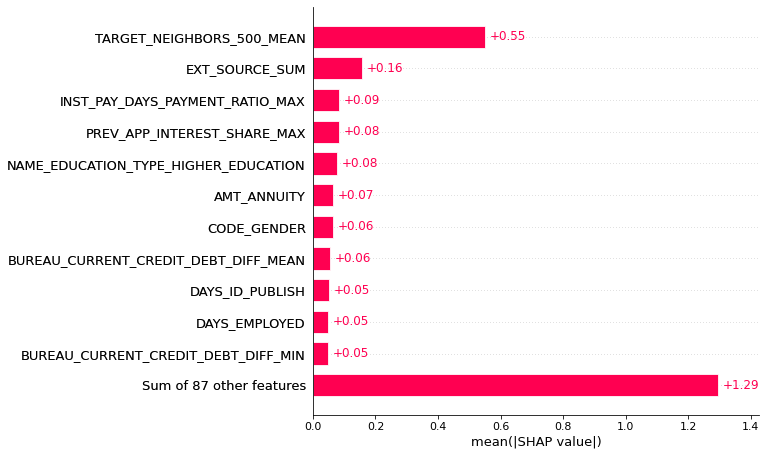

In [204]:
shap.plots.bar(shap_values, max_display=12)

***Beeswarm***

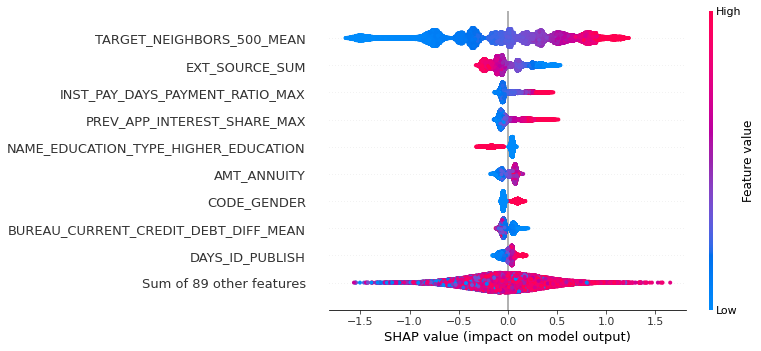

In [205]:
shap.plots.beeswarm(shap_values)

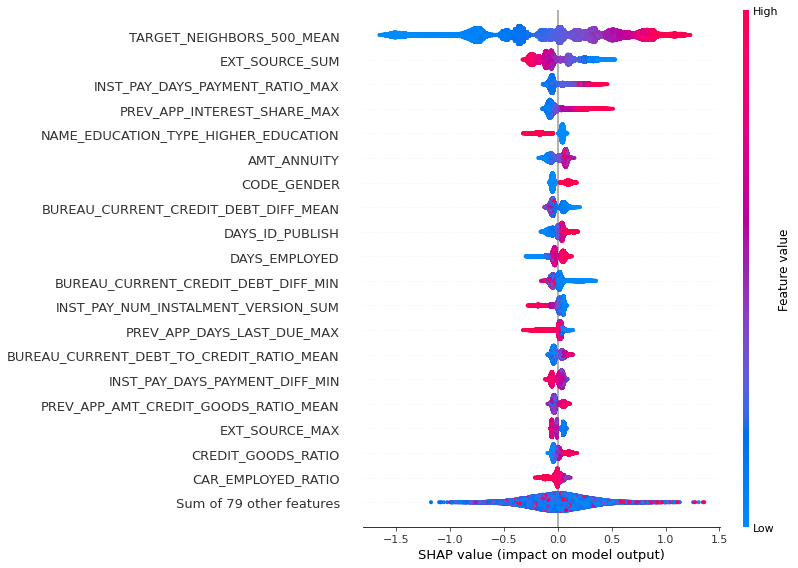

In [206]:
shap.plots.beeswarm(shap_values, max_display=20)

**Graphiques Locaux**

***BarPlot***

In [207]:
client_index = test_set[test_set['SK_ID_CURR'] == 100005].index.item()

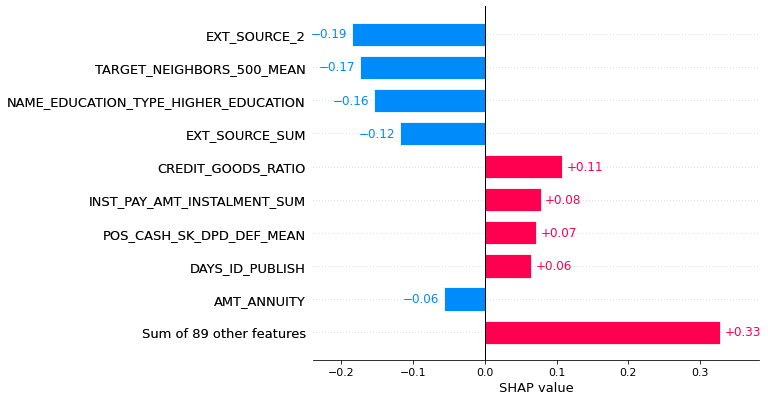

In [208]:
shap.plots.bar(shap_values[0])

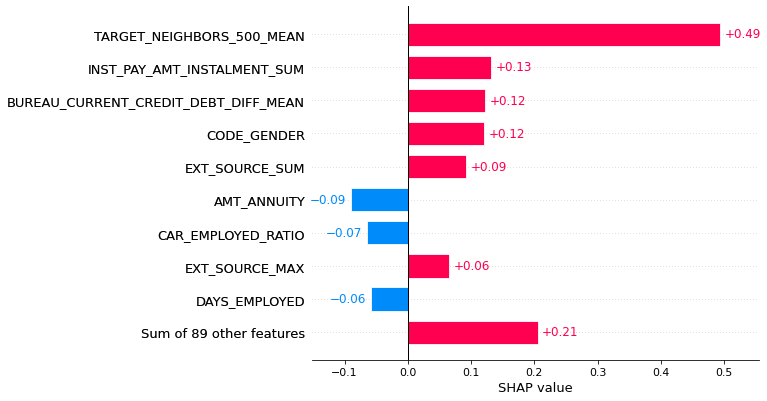

In [209]:
shap.plots.bar(shap_values[1])

In [210]:
shap_values[0,"AMT_ANNUITY"]

.values =
-0.05678796590305865

.base_values =
-0.4846547554690903

.data =
20560.5

***Waterfall Plot***

In [211]:
client_index = test_set[test_set['SK_ID_CURR'] == 100001].index.item()

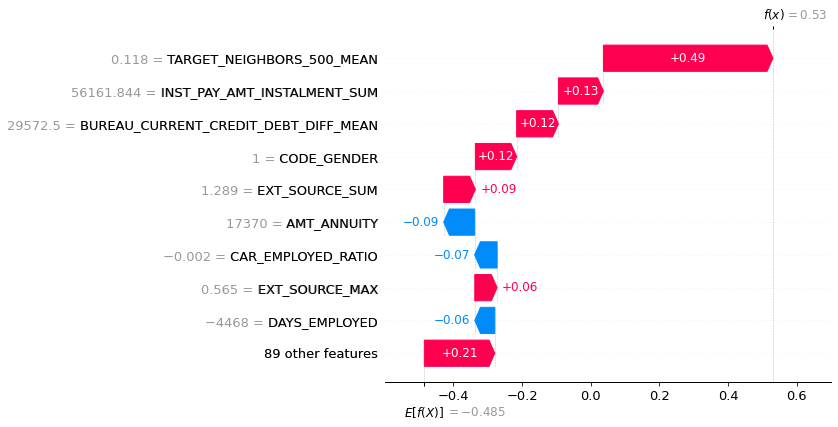

In [212]:
# Classe négative
shap.plots.waterfall(shap_values[1])

***ForcePlot***

In [213]:
explainer = shap.TreeExplainer(best_model)

In [214]:
X_test_0 = X_test.iloc[0]
X_test_0_array = X_test_0.values.reshape(1, -1)

In [216]:
shap_values_0 = explainer.shap_values(X_test_0_array)

In [217]:
# Plot SHAP force_plot [1] pour classe positive
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values_0[1],
                X_test_0)

In [218]:
# Plot SHAP force_plot [0] pour classe négative
shap.force_plot(explainer.expected_value[0], shap_values_0[0],
                X_test_0)

***Decision Plot***

**Client 100001**

In [219]:
explainer = shap.TreeExplainer(best_model)

In [220]:
X_test_0 = X_test.iloc[0]
X_test_0_array = X_test_0.values.reshape(1, -1)

In [221]:
shap_values_0 = explainer.shap_values(X_test_0_array)

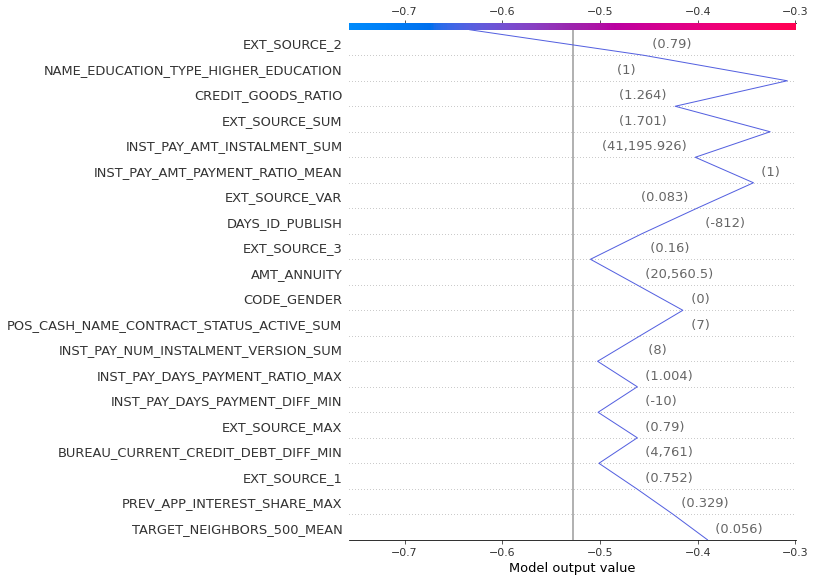

In [222]:
# Decision plot classe négative
shap.decision_plot(explainer.expected_value[1], shap_values_0[1],
                   X_test_0)

***

**Client 100005**

In [223]:
explainer = shap.TreeExplainer(best_model)

In [224]:
X_test_1 = X_test.iloc[1]
X_test_1_array = X_test_1.values.reshape(1, -1)

In [225]:
shap_values_1 = explainer.shap_values(X_test_1_array)

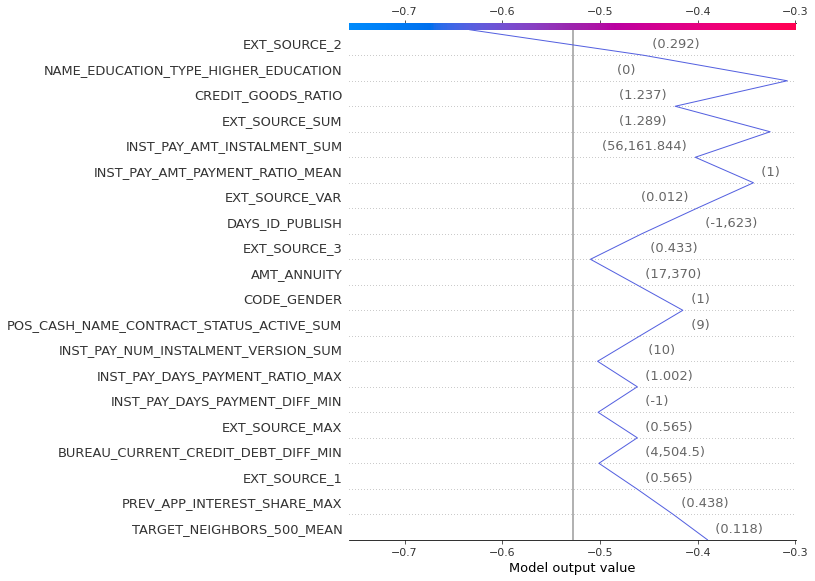

In [226]:
# Decision plot classe négative
shap.decision_plot(explainer.expected_value[1], shap_values_0[1],
                   X_test_1)

**Client 100038**

In [227]:
explainer = shap.TreeExplainer(best_model)

In [228]:
client_index = test_set[test_set['SK_ID_CURR'] == 100038].index.item()
X_test_1 = X_test.iloc[client_index]
X_test_1_array = X_test_1.values.reshape(1, -1)

In [229]:
shap_values_1 = explainer.shap_values(X_test_1_array)

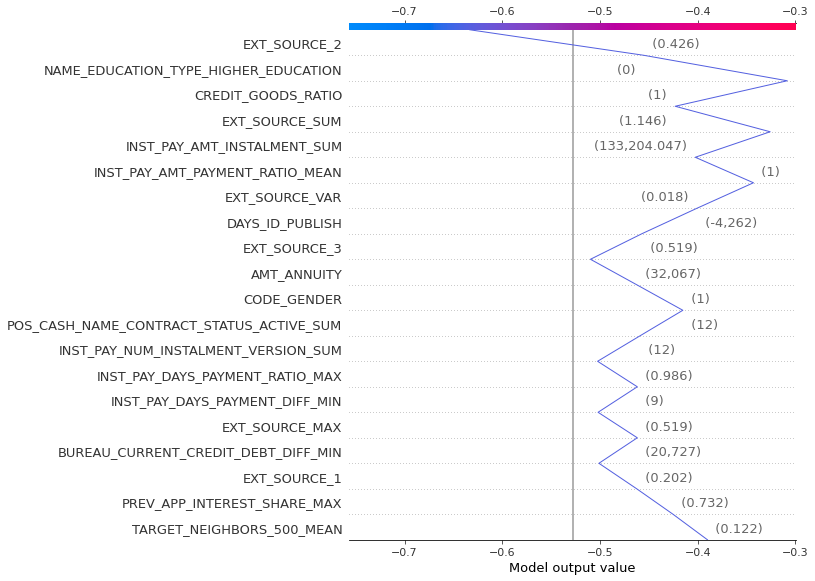

In [230]:
# Decision plot classe négative
shap.decision_plot(explainer.expected_value[1], shap_values_0[1],
                   X_test_1)

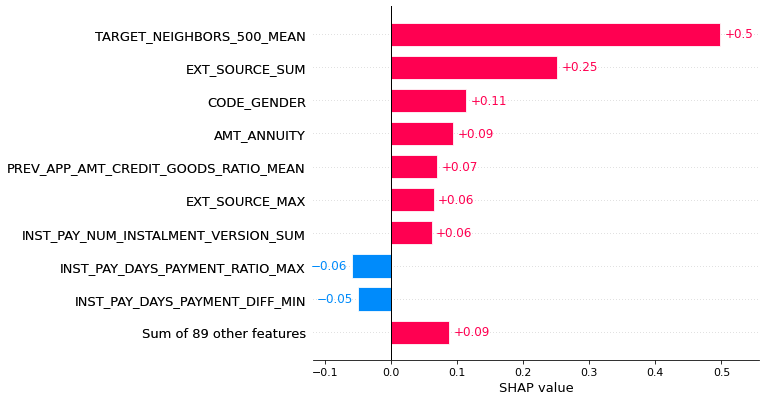

In [231]:
shap.plots.bar(shap_values[client_index])

In [232]:
client_index = test_set[test_set['SK_ID_CURR'] == 199344].index.item()
X_test_1 = X_test.iloc[client_index]
X_test_1_array = X_test_1.values.reshape(1, -1)

In [233]:
shap_values_1 = explainer.shap_values(X_test_1_array)

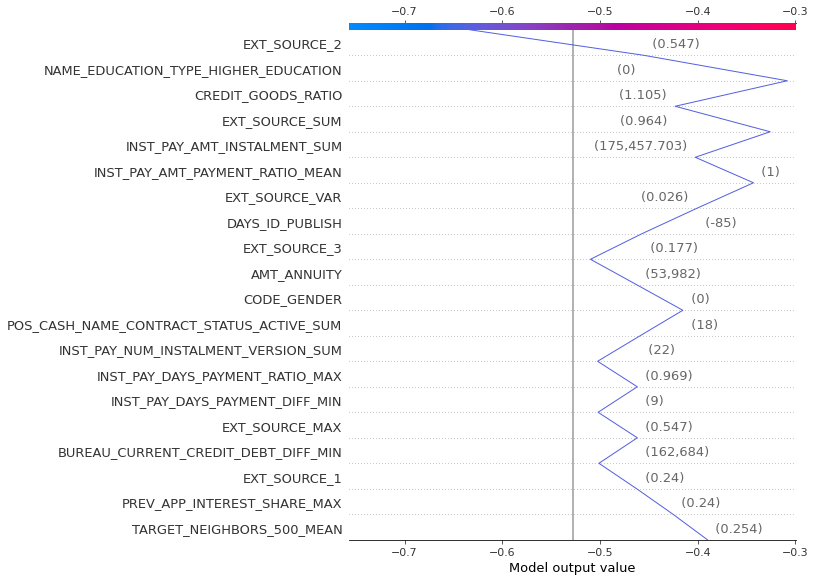

In [234]:
# Decision plot classe négative
shap.decision_plot(explainer.expected_value[1], shap_values_0[1],
                   X_test_1)

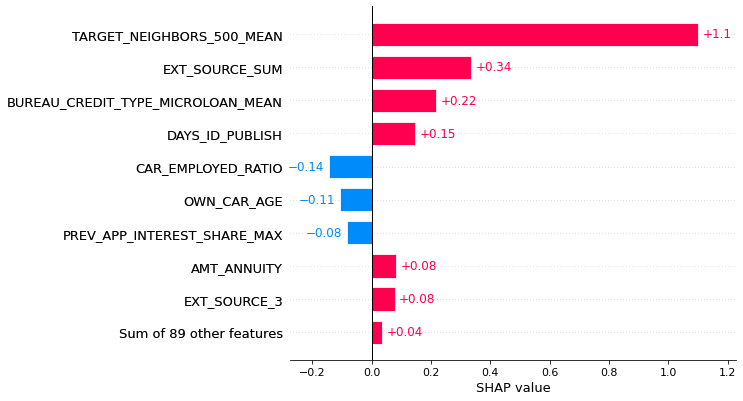

In [235]:
shap.plots.bar(shap_values[client_index])

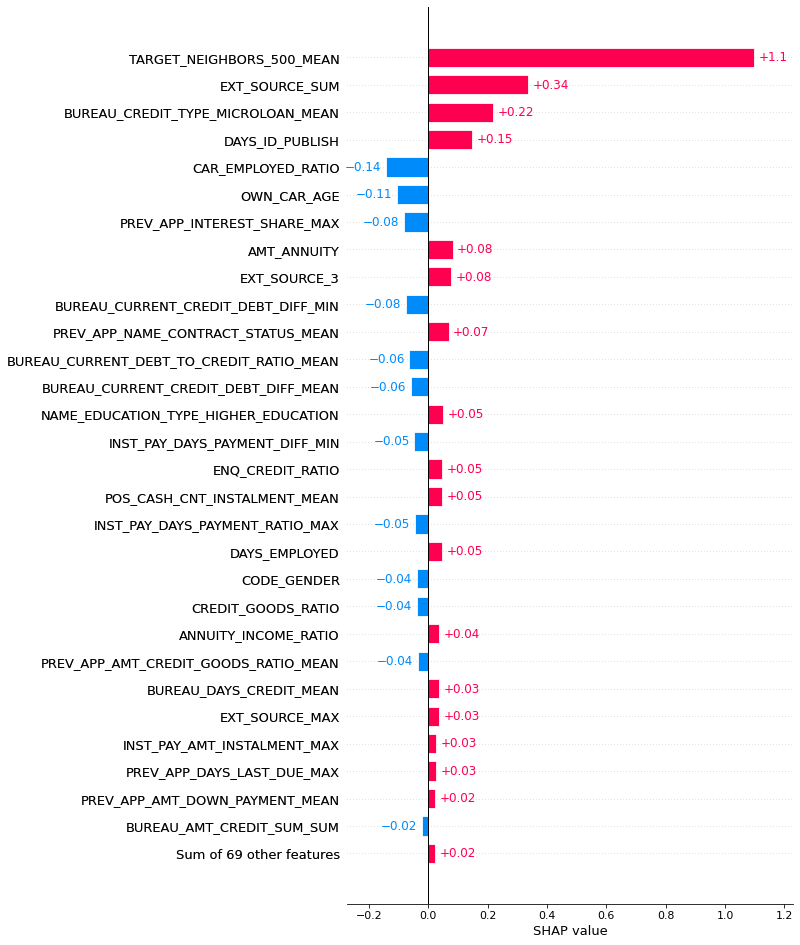

In [236]:
shap.plots.bar(shap_values[client_index], max_display=30)

In [237]:
client_index = test_set[test_set['SK_ID_CURR'] == 100001].index.item()
X_shap = test_set.set_index('SK_ID_CURR')
X_test_courant = pd.DataFrame(X_shap.iloc[client_index])

In [238]:
# Entraînement de shap sur le train set
shap_explainer = shap.Explainer(best_model, X_test_courant)
shap_values = shap_explainer(X_test_courant, check_additivity=False)

**Export de application_test pour affichage dashboard**

In [7]:
application_test = pd.read_csv('/content/drive/My Drive/data/application_test.csv')

In [8]:
application_test = outils_preprocessing.reduce_mem_usage(application_test)

-------------------------------------------------------------------------------
Memory usage du dataframe: 45.00 MB
Memory usage après optimization: 14.60 MB
Diminution de 67.6%
-------------------------------------------------------------------------------


In [9]:
filename =  '/content/drive/My Drive/sauvegarde/pickle/application_test.pickle'
outfile = open(filename,'wb')
pickle.dump(application_test, outfile)
outfile.close()